In [348]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import language_tool_python
import spacy
import copy
import json
import re
import torch
import itertools
from sklearn.utils.class_weight import compute_class_weight
from datasets import Dataset, DatasetDict
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from transformers import (
    AutoModelForSequenceClassification,
    AutoModel,
    AutoTokenizer,
    Trainer,
    TrainingArguments,
    EvalPrediction
)
from transformers import AutoTokenizer, BertForSequenceClassification
from functions import preprocess_tweet,replace_emoji,analyze_sentiment,create_tokenize_function
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## Introduction


* The following code aims at using pretrained polish BERT models for tweet classifications. 
* Dataset has been labeled to classify all netrual/not relevant tweets as neutral.
* This allows for filtering out noise - tweets that aren't aimed at specific company.
* Models used were chose based on the KLEJ bechmark t(https://klejbenchmark.com/leaderboard/).

### Preparing training dataset

In [278]:
dataset_1 = pd.read_excel('annotation_dataset_labeled.xlsx',index_col=0)
dataset_1 = dataset_1[['text','label']]
dataset_1 =  dataset_1.rename(columns={'label':'labels'})
dataset_1.head(5)

,text,labels
38253,"@lila_h17 Ja te znalazłam na Allegro,po 8 zł :p ale jak gdzieś szukałam to już te nowsze",0.0
59140,"@_rmrmg_ @PSlopnicki @PervWizz @Mecenas_Kon_ Daj spokój, typowe branżowe mity. Już widzę jak Żabka znajduje w kącie paletę mleka i jeździ po województwie, wciskając przerażonym ajentom po kilka kartonów.",0.0
57205,@FNkejz_ @Qlpik1 Daje mu unv bo jest zjebem i tyle a jak ktoś ma sobie zmarnować CCC bo ma z nim zagrać to proszę bardzo,0.0
60259,Melduję się z Bukaresztu - Żabka podbija ziemię rumuńską. 🐸🇷🇴 https://t.co/S56Gi1vDyg,1.0
33346,"@jakubhajost @RBrzoska Gratulacje dla @RBrzoska i zespołu InPost! Imponujące wyniki zwiększenia wolumenów i przychodów. To świetne, że firma osiąga dwucyfrowy wzrost i lepsze marże. Przejście na 9 miliardów przychodu brzmi obiecująco!",1.0


In [ ]:
dataset_labeled = dataset_1
dataset_labeled['labels'] = dataset_labeled['labels'] + 1
dataset_labeled['labels'] = dataset_labeled['labels'].astype(int)
dataset_labeled = dataset_labeled.dropna()
dataset_labeled = dataset_labeled.drop_duplicates(subset='text')
dataset_labeled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1923 entries, 38253 to 48370
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1923 non-null   object
 1   labels  1923 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 45.1+ KB


In [228]:
dataset_labeled.head(5)

,text,labels
0,Powoli kończy się sasinada w polskiej energetyce. Z głównych pomysłów Sasina NABE właśnie skreślono. Czas na to samo w przypadku mrzonek PGE + ZE PAK + KHNP. Niech PGE zajmie się OZE a nie projektami większymi NIŻ JEJ KAPITALIZACJA.,0
1,PO sprzedało KGHM dobrze ten gość przypomina. #debata,1
2,KGHM stawia na kształcenie elektryków. Uruchomił kolejną klasę patronacką. @wnppl https://t.co/JrTT9aBf0K,2
3,"@sjkaleta Ja już dostałem prognozę z PGE. Do lipca płace 231 zł miesięcznie, a od lipca 378 zł. No ale to się nie liczy, to uśmiechnięta podwyżka...",0
4,"@hennigkloska @PL_2050 @Platforma_org @__Lewica @MiroslawSuchon @szymon_holownia @KancelariaSejmu A dlaczego tak wszyscy idą w wiatraki? Wielkie bum farm fotowoltaicznych pokazało to że operatorzy nie są przygotowani na odbiór energii od B2C, nie ma magazynów energii , zmiany w programach Mój prąd pokazuje tylko że Polak potrafi. Farmy wiatrowe to również PGE i Balcic Sea",0


##### Training dataset is imbalanced what will be addressed in the later stage of the analysis

<Axes: xlabel='labels'>

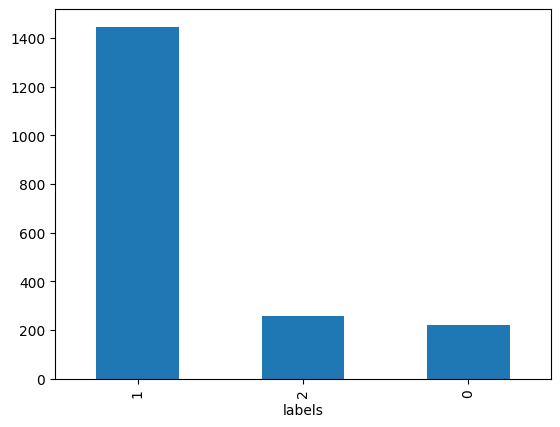

In [280]:
count = dataset_labeled['labels'].value_counts()
count.plot(kind='bar')

Max length will be set as 128. It covers more than 95% of observations

In [281]:
tokenizer = AutoTokenizer.from_pretrained("allegro/herbert-base-cased")
tweet_lengths = [len(tokenizer.tokenize(tweet)) for tweet in dataset_labeled["text"]]

loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "HerbertTokenizerFast",
  "transformers_version": "4.45.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 50000
}

loading file vocab.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c

In [282]:
print(f"95th percentile: {np.percentile(tweet_lengths, 95)}")  
print(f"Max tokens: {max(tweet_lengths)}")

95th percentile: 86.0
Max tokens: 260


# Evaluating Text Preprocessing Strategies for BERT Classification


To evaluate the impact of different text preprocessing techniques on BERT model performance using a systematic comparison approach.

#### Methodology
A baseline BERT model with default parameters was trained on each preprocessed version of the datasets. Due to class imbalance and the focus on positive/negative classification, the F1 score serves as the primary evaluation metric.

#### Preprocessing Strategies
We evaluated six distinct preprocessing approaches, incrementally adding complexity to assess the impact of each step:

1. Raw text without any preprocessing
2. Removal of non-textual characters
3. Conversion of emojis to corresponding text + Removal of non-textual characters
4. Removal of non-textual characters + Spelling correction
5. Removal of non-textual characters + Spelling correction + Lemmatization
6. Removal of non-textual characters + Spelling correction + Lemmatization + Stopword removal

Model performance is evaluated using the F1 score, which provides a balanced measure of precision and recall, particularly important for our imbalanced dataset classification task.

In [303]:
EMOJI_TO_POLISH = {
    # Twarze i emocje
    "😀": "usmiech ", "😃": "szeroki_usmiech ", "😄": "usmiech_z_oczami ", "😁": "szeroki_usmiech_z_oczami ",
    "😆": "usmiech_zmruzone_oczy ", "😅": "usmiech_pot ", "🤣": "tarzanie_sie_ze_smiechu ",
    "😂": "lzy_radosci ", "🙂": "lekki_usmiech ", "🙃": "odwrocona_twarz ", "😉": "mrugnięcie ",
    "😊": "usmiechniete_oczy ", "😇": "usmiech_aureola ", "🥰": "usmiech_serca ", "😍": "oczy_serca ",
    "🤩": "gwiazdy_w_oczach ", "😘": "przesylam_calusa ", "😗": "calus ", "☺️": "ciepły_usmiech ",
    "😚": "calus_z_zamknietymi_oczami ", "😙": "calus_z_usmiechnietymi_oczami ", "🥲": "usmiech_ze_lzą ",
    "😋": "mniam ", "😛": "jezyk_na_wierzchu ", "😜": "jezyk_mrugnięcie ", "🤪": "szalona_twarz ",
    "😝": "jezyk_zmruzone_oczy ", "🤑": "twarz_z_pieniędzmi ", "🤗": "przytulenie ", "🤭": "ups ",
    "🤫": "ciii ", "🤔": "zamyslenie ", "🤐": "milczenie ", "🤨": "uniesiona_brew ",
    "😐": "neutralna_twarz ", "😑": "bez_wyrazu ", "😶": "bez_ust ", "😏": "uśmieszek ",
    "😒": "niezadowolenie ", "🙄": "przewracanie_oczami ", "😬": "grymas ", "🤥": "kłamca ",
    "😌": "ulga ", "😔": "zaduma ", "😪": "sennosc ", "🤤": "slinka ", "😴": "spanie ",
    "😷": "maska_medyczna ", "🤒": "termometr ", "🤕": "bandaz ", "🤢": "mdłosci ",
    "🤮": "wymioty ", "🤧": "kichanie ", "🥵": "goraco ", "🥶": "zimno ",
    "🥴": "oszołomienie ", "😵": "zawroty_głowy ", "🤯": "eksplozja_mózgu ", "🤠": "kowboj ",
    "🥳": "impreza ", "😎": "cool ", "🤓": "kujon ", "🧐": "monokl ",
    "😕": "zmieszanie ", "😟": "zmartwienie ", "🙁": "lekki_smutek ", "☹️": "smutek ",
    "😮": "zdziwienie ", "😯": "osłupienie ", "😲": "szok ", "😳": "rumieniec ",
    "🥺": "błagalne_oczy ", "😦": "otwarte_usta ", "😧": "udręka ", "😨": "strach ",
    "😰": "zimny_pot ", "😥": "rozczarowanie_ulga ", "😢": "płacz ", "😭": "głośny_płacz ",
    "😱": "krzyk ", "😖": "zakłopotanie ", "😣": "wytrwałosc ", "😞": "rozczarowanie ",
    "😓": "pot ", "😩": "zmęczenie ", "😫": "wyczerpanie ", "🥱": "ziewanie ",
    
    # Gesty i ludzie
    "👋": "machanie ", "🤚": "uniesiona_dłoń ", "🖐️": "rozstawione_palce ", "✋": "wysoka_piątka ",
    "🖖": "vulcan ", "👌": "ok ", "🤌": "włoski_gest ", "🤏": "mały_gest ",
    "✌️": "victoria ", "🤞": "skrzyżowane_palce ", "🤟": "kocham_cię_gest ", "🤘": "rogi ",
    "🤙": "zadzwoń_do_mnie ", "👈": "wskazywanie_w_lewo ", "👉": "wskazywanie_w_prawo ", "👆": "wskazywanie_w_górę ",
    "🖕": "środkowy_palec ", "👇": "wskazywanie_w_dół ", "☝️": "wskazywanie_w_górę_palcem ", "👍": "kciuk_w_górę ",
    "👎": "kciuk_w_dół ", "✊": "pięść ", "👊": "pięść_naprzód ", "🤛": "pięść_w_lewo ",
    "🤜": "pięść_w_prawo ", "👏": "oklaski ", "🙌": "uniesione_ręce ", "👐": "otwarte_dłonie ",
    "🤲": "błagalne_ręce ", "🤝": "uścisk_dłoni ", "🙏": "złożone_ręce ", "✍️": "pisanie ",
    "💪": "biceps ", "🦾": "mechaniczne_ramię ", "🦿": "mechaniczna_noga ", "🦵": "noga ",
    "🦶": "stopa ", "👂": "ucho ", "🦻": "ucho_z_aparatem ", "👃": "nos ",
    "🧠": "mózg ", "🫀": "serce_anatomiczne ", "🫁": "płuca ", "🦷": "ząb ",
    "🦴": "kość ", "👀": "oczy ", "👁️": "oko ", "👅": "język ",
    "👄": "usta ", "👶": "dziecko ", "🧒": "dziecko ", "👦": "chłopiec ",
    "👧": "dziewczynka ", "🧑": "osoba ", "👱": "blondyn ", "👨": "mężczyzna ",
    "🧔": "brodacz ", "👩": "kobieta ", "🧓": "starsza_osoba ", "👴": "starszy_mężczyzna ",
    "👵": "starsza_kobieta ",
}

def replace_emoji(text: str) -> str:
    """
    Replaces emojis in a given text based on the emoji dictionary provided.

    Args:
        text (str): The input string containing emojis.
        emoji_dict (dict): A dictionary where keys are emojis and values are replacements.

    Returns:
        str: The text with emojis replaced.
    """
    for emoji, replacement in EMOJI_TO_POLISH.items():
        text = text.replace(emoji, f" {replacement}")
    return text


In [302]:
def preprocess_tweet(tweet):
    #tweet = tweet.lower()
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)
    tweet = re.sub(r'@\w+|#\w+', '', tweet)
    # Replace underscores with space
    tweet = re.sub(r'_', ' ', tweet)
    # Changed \w to use explicit character ranges instead
    tweet = re.sub(r'[^a-zA-Z0-9\s\u0105\u0107\u0119\u0142\u0144\u00f3\u015b\u017a\u017c]', '', tweet)
    tweet = re.sub(r'\s+', ' ', tweet).strip()
    return tweet

In [304]:
nlp = spacy.load("pl_core_news_lg")
def lemmatize_text(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

In [306]:
polish_stopwords = [
    'a', 'aby', 'ach', 'acz', 'aczkolwiek', 'aj', 'albo', 'ale', 'alez', 'ależ',
    'ani', 'az', 'aż', 'bardziej', 'bardzo', 'beda', 'bedzie', 'bez', 'deda', 'będą',
    'bede', 'będę', 'będzie', 'bo', 'bowiem', 'by', 'byc', 'być', 'byl', 'byla',
    'byli', 'bylo', 'byly', 'był', 'była', 'było', 'były', 'bynajmniej', 'cala',
    'cali', 'caly', 'cała', 'cały', 'ci', 'cie', 'ciebie', 'cię', 'co', 'cokolwiek',
    'cos', 'coś', 'czasami', 'czasem', 'czemu', 'czy', 'czyli', 'daleko', 'dla',
    'dlaczego', 'dlatego', 'do', 'dobrze', 'dokad', 'dokąd', 'dosc', 'dość', 'duzo',
    'dużo', 'dwa', 'dwaj', 'dwie', 'dwoje', 'dzis', 'dzisiaj', 'dziś', 'gdy', 'gdyby',
    'gdyz', 'gdyż', 'gdzie', 'gdziekolwiek', 'gdzies', 'gdzieś', 'go', 'i', 'ich',
    'ile', 'im', 'inna', 'inne', 'inny', 'innych', 'iz', 'iż', 'ja', 'jak', 'jakas',
    'jakaś', 'jakby', 'jaki', 'jakichs', 'jakichś', 'jakie', 'jakis', 'jakiś', 'jakiz',
    'jakiż', 'jakkolwiek', 'jako', 'jakos', 'jakoś', 'ją', 'je', 'jeden', 'jedna',
    'jednak', 'jednakze', 'jednakże', 'jedno', 'jego', 'jej', 'jemu', 'jesli', 'jest',
    'jestem', 'jeszcze', 'jeśli', 'jezeli', 'jeżeli', 'juz', 'już', 'kazdy', 'każdy',
    'kiedy', 'kilka', 'kims', 'kimś', 'kto', 'ktokolwiek', 'ktora', 'ktore', 'ktorego',
    'ktorej', 'ktory', 'ktorych', 'ktorym', 'ktorzy', 'ktos', 'ktoś', 'która', 'które',
    'którego', 'której', 'który', 'których', 'którym', 'którzy', 'ku', 'lat', 'lecz',
    'lub', 'ma', 'mają', 'mało', 'mam', 'mi', 'miedzy', 'między', 'mimo', 'mna', 'mną',
    'mnie', 'moga', 'mogą', 'moi', 'moim', 'moj', 'moja', 'moje', 'moze', 'mozliwe',
    'mozna', 'może', 'możliwe', 'można', 'mój', 'mu', 'musi', 'my', 'na', 'nad', 'nam',
    'nami', 'nas', 'nasi', 'nasz', 'nasza', 'nasze', 'naszego', 'naszych', 'natomiast',
    'natychmiast', 'nawet', 'nia', 'nią', 'nic', 'nich', 'niech', 'niego', 'niej',
    'niemu', 'nigdy', 'nim', 'nimi', 'niz', 'niż', 'no', 'o', 'obok', 'od', 'około',
    'on', 'ona', 'one', 'oni', 'ono', 'oraz', 'oto', 'owszem', 'pan', 'pana', 'pani',
    'po', 'pod', 'podczas', 'pomimo', 'ponad', 'poniewaz', 'ponieważ', 'powinien',
    'powinna', 'powinni', 'powinno', 'poza', 'prawie', 'przeciez', 'przecież', 'przed',
    'przede', 'przedtem', 'przez', 'przy', 'roku', 'rowniez', 'również', 'sam', 'sama',
    'są', 'sie', 'się', 'skad', 'skąd', 'soba', 'sobą', 'sobie', 'sposob', 'sposób',
    'swoje', 'ta', 'taka', 'taki', 'takie', 'takze', 'także', 'tam', 'te',
    'tego', 'tej', 'ten', 'teraz', 'też', 'to', 'toba', 'tobą', 'tobie', 'totez',
    'toteż', 'totobą', 'trzeba', 'tu', 'tutaj', 'twoi', 'twoim', 'twoj', 'twoja',
    'twoje', 'twój', 'twym', 'ty', 'tych', 'tylko', 'tym', 'u', 'w', 'wam', 'wami',
    'was', 'wasz', 'wasza', 'wasze', 'we', 'według', 'wiele', 'wielu', 'więc', 'więcej',
    'wlasnie', 'właśnie', 'wszyscy', 'wszystkich', 'wszystkie', 'wszystkim', 'wszystko',
    'wtedy', 'wy', 'z', 'za', 'zaden', 'zadna', 'zadne', 'zadnych', 'zapewne', 'zawsze',
    'ze', 'zeby', 'zeznowu', 'zł', 'znow', 'znowu', 'znów', 'zostal', 'został', 'żaden',
    'żadna', 'żadne', 'żadnych', 'że', 'żeby'
]

In [307]:
def remove_stops(text):
    if isinstance(text, str):
        words = text.split()
        filtered_words = [word for word in words if word.lower() not in polish_stopwords]
        return ' '.join(filtered_words)
    return text

In [308]:
#Dataset processing
datasets = {}

datasets['No_processing'] = dataset_labeled

dataset_labeled_basic_proc = copy.deepcopy(dataset_labeled)
dataset_labeled_basic_proc['text'] = dataset_labeled['text'].apply(lambda x:preprocess_tweet(x))
dataset_labeled_basic_proc = dataset_labeled_basic_proc.drop_duplicates(subset='text')
datasets['Basic_processing'] = dataset_labeled_basic_proc

dataset_labeled_proc_emoji = copy.deepcopy(dataset_labeled)
dataset_labeled_proc_emoji['text'] = dataset_labeled_proc_emoji['text'].apply(lambda x:replace_emoji(x))
dataset_labeled_proc_emoji['text'] = dataset_labeled_proc_emoji['text'].apply(lambda x:preprocess_tweet(x))
dataset_labeled_proc_emoji = dataset_labeled_proc_emoji.drop_duplicates(subset='text')
datasets['Basic_processing_emoji'] = dataset_labeled_proc_emoji

tool = language_tool_python.LanguageTool('pl')
dataset_labeled_proc_spell = copy.deepcopy(dataset_labeled)
dataset_labeled_proc_spell['text'] = dataset_labeled_proc_spell['text'].apply(lambda x:preprocess_tweet(x))
dataset_labeled_proc_spell['text'] = dataset_labeled_proc_spell['text'].apply(lambda x: tool.correct(x))
datasets['Basic_processing_spelling'] = dataset_labeled_proc_spell

dataset_labeled_proc_spell_lem = copy.deepcopy(dataset_labeled_proc_spell)
dataset_labeled_proc_spell_lem['text'] = dataset_labeled_proc_spell_lem['text'].map(lemmatize_text)
dataset_labeled_proc_spell_lem =dataset_labeled_proc_spell_lem.drop_duplicates(subset='text')
datasets['Basic_processing_spelling_lem'] = dataset_labeled_proc_spell_lem

dataset_labeled_proc_spell_lem_SP = copy.deepcopy(dataset_labeled_proc_spell_lem)
dataset_labeled_proc_spell_lem_SP['text'] = dataset_labeled_proc_spell_lem_SP['text'].map(remove_stops)
dataset_labeled_proc_spell_lem_SP =dataset_labeled_proc_spell_lem_SP.drop_duplicates(subset='text')
datasets['Basic_processing_spelling_lem_SP'] = dataset_labeled_proc_spell_lem_SP

In [ ]:

dataset = Dataset.from_pandas(dataset_labeled_proc_emoji)
tokenizer = AutoTokenizer.from_pretrained("allegro/herbert-base-cased")
tokenized_dataset = dataset.map(
    lambda examples: tokenizer(examples["text"], truncation=True, padding="max_length",max_length=128),
    batched=True,
    remove_columns=['text','__index_level_0__']
)
tokenized_dataset = tokenized_dataset.shuffle(seed=12).train_test_split(test_size=0.2)
tokenized_dataset.set_format("torch", columns=["input_ids", "token_type_ids", "attention_mask", "labels"])
tokenized_dataset

In [321]:
tokenized_datasets = {}
for key, df in datasets.items():
    dataset = Dataset.from_pandas(df)
    tokenizer = AutoTokenizer.from_pretrained("allegro/herbert-base-cased")
    tokenized_dataset = dataset.map(
    lambda examples: tokenizer(examples["text"], truncation=True, padding="max_length",max_length=128),
    batched=True,
    remove_columns=['text','__index_level_0__']
    )
    tokenized_dataset = tokenized_dataset.shuffle(seed=12).train_test_split(test_size=0.2)
    tokenized_dataset.set_format("torch", columns=["input_ids", "token_type_ids", "attention_mask", "labels"])
    tokenized_datasets[key] = tokenized_dataset


loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "HerbertTokenizerFast",
  "transformers_version": "4.45.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 50000
}

loading file vocab.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c

In [324]:
# Modified compute_metrics function
def compute_metrics(eval_pred: EvalPrediction):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1_macro": f1_score(labels, predictions, average="macro"),
        "f1_weighted": f1_score(labels, predictions, average="weighted"),
        "f1_0": f1_score(labels, predictions, average=None)[0],
        "f1_1": f1_score(labels, predictions, average=None)[1],
        "f1_2": f1_score(labels, predictions, average=None)[2],
    }

def train_and_evaluate(key, tokenized_dataset, base_model_name="allegro/herbert-base-cased"):
  
    # Reload model for each run to reset weights
    model = AutoModelForSequenceClassification.from_pretrained(base_model_name, num_labels=3)

    # Training arguments
    training_args = TrainingArguments(
        output_dir=f"./results_{key}",
        num_train_epochs=4,  #
        per_device_train_batch_size=16,  
        per_device_eval_batch_size=64,
        warmup_ratio=0.1,
        weight_decay=0.01,
        learning_rate=2e-5,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1_macro", 
        greater_is_better=True,
        seed=42,
        fp16=torch.cuda.is_available(),
        report_to="none",
        logging_steps=50,
        gradient_accumulation_steps=2,
    )

    # Initialize custom trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["test"],
        compute_metrics=compute_metrics
    )

    # Train and evaluate
    trainer.train()
    eval_results = trainer.evaluate()
    
    return eval_results

# Main comparison loop
results = []

for key, tokenized_dataset in tokenized_datasets.items():
    try:
        print(f"\n{'='*40}")
        print(f"Testing preprocessing variant: {key}")
        print(f"{'='*40}")
        
        metrics = train_and_evaluate(key, tokenized_dataset)
        
        results.append({
            "preprocessing": key,
            "accuracy": metrics["eval_accuracy"],
            "macro_f1": metrics["eval_f1_macro"],
            "weighted_f1": metrics["eval_f1_weighted"],
            "neutral_f1": metrics["eval_f1_0"],
            "positive_f1": metrics["eval_f1_1"],
            "negative_f1": metrics["eval_f1_2"],
            "epochs": metrics["epoch"]
        })
        
    except Exception as e:
        print(f"Error with variant {key}: {str(e)}")

# Save results
results_df = pd.DataFrame(results)
results_df.to_csv("preprocessing_comparison.csv", index=False)
print("\nComparison saved to preprocessing_comparison.csv")

loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "HerbertTokenizerFast",
  "transformers_version": "4.45.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "voca


Testing preprocessing variant: No_processing


loading weights file pytorch_model.bin from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\pytorch_model.bin
Some weights of the model checkpoint at allegro/herbert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.sso.sso_relationship.bias', 'cls.sso.sso_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoin

{'eval_loss': 0.7100661993026733, 'eval_accuracy': 0.7454545454545455, 'eval_f1_macro': 0.2847222222222222, 'eval_f1_weighted': 0.6367424242424242, 'eval_f1_0': 0.0, 'eval_f1_1': 0.8541666666666666, 'eval_f1_2': 0.0, 'eval_runtime': 46.8685, 'eval_samples_per_second': 8.214, 'eval_steps_per_second': 0.149, 'epoch': 0.99}


Saving model checkpoint to ./results_No_processing\checkpoint-48
Configuration saved in ./results_No_processing\checkpoint-48\config.json
Model weights saved in ./results_No_processing\checkpoint-48\model.safetensors
 26%|██▌       | 50/192 [05:59<52:41, 22.27s/it]  

{'loss': 0.7854, 'grad_norm': 2.5444118976593018, 'learning_rate': 1.6511627906976747e-05, 'epoch': 1.03}


 51%|█████     | 97/192 [09:23<06:07,  3.87s/it]
***** Running Evaluation *****
  Num examples = 385
  Batch size = 64

 51%|█████     | 97/192 [09:39<06:07,  3.87s/it]Saving model checkpoint to ./results_No_processing\checkpoint-97
Configuration saved in ./results_No_processing\checkpoint-97\config.json


{'eval_loss': 0.6817612648010254, 'eval_accuracy': 0.7480519480519481, 'eval_f1_macro': 0.2970513093463913, 'eval_f1_weighted': 0.6427934105494251, 'eval_f1_0': 0.0, 'eval_f1_1': 0.8554396423248882, 'eval_f1_2': 0.03571428571428571, 'eval_runtime': 15.3324, 'eval_samples_per_second': 25.11, 'eval_steps_per_second': 0.457, 'epoch': 2.0}


Model weights saved in ./results_No_processing\checkpoint-97\model.safetensors
 52%|█████▏    | 100/192 [10:01<12:02,  7.85s/it]

{'loss': 0.6821, 'grad_norm': 2.8615920543670654, 'learning_rate': 1.0697674418604651e-05, 'epoch': 2.06}


 76%|███████▌  | 145/192 [13:19<03:19,  4.25s/it]
***** Running Evaluation *****
  Num examples = 385
  Batch size = 64

 76%|███████▌  | 145/192 [13:34<03:19,  4.25s/it]Saving model checkpoint to ./results_No_processing\checkpoint-145
Configuration saved in ./results_No_processing\checkpoint-145\config.json


{'eval_loss': 0.65580815076828, 'eval_accuracy': 0.7506493506493507, 'eval_f1_macro': 0.30896395216897965, 'eval_f1_weighted': 0.6486682105535208, 'eval_f1_0': 0.0, 'eval_f1_1': 0.8567164179104477, 'eval_f1_2': 0.07017543859649122, 'eval_runtime': 15.1358, 'eval_samples_per_second': 25.436, 'eval_steps_per_second': 0.462, 'epoch': 2.99}


Model weights saved in ./results_No_processing\checkpoint-145\model.safetensors
 78%|███████▊  | 150/192 [14:02<04:07,  5.88s/it]

{'loss': 0.6072, 'grad_norm': 3.502885341644287, 'learning_rate': 4.883720930232559e-06, 'epoch': 3.09}


100%|██████████| 192/192 [17:06<00:00,  4.00s/it]Saving model checkpoint to ./results_No_processing\checkpoint-192
Configuration saved in ./results_No_processing\checkpoint-192\config.json
Model weights saved in ./results_No_processing\checkpoint-192\model.safetensors

***** Running Evaluation *****
  Num examples = 385
  Batch size = 64

100%|██████████| 192/192 [17:31<00:00,  4.00s/it]Saving model checkpoint to ./results_No_processing\checkpoint-192
Configuration saved in ./results_No_processing\checkpoint-192\config.json


{'eval_loss': 0.6529662013053894, 'eval_accuracy': 0.7558441558441559, 'eval_f1_macro': 0.34713915915379806, 'eval_f1_weighted': 0.669988674183979, 'eval_f1_0': 0.0, 'eval_f1_1': 0.8649468892261002, 'eval_f1_2': 0.17647058823529413, 'eval_runtime': 16.4714, 'eval_samples_per_second': 23.374, 'eval_steps_per_second': 0.425, 'epoch': 3.96}


Model weights saved in ./results_No_processing\checkpoint-192\model.safetensors


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results_No_processing\checkpoint-192 (score: 0.34713915915379806).
100%|██████████| 192/192 [17:38<00:00,  4.00s/it]

{'train_runtime': 1058.623, 'train_samples_per_second': 5.811, 'train_steps_per_second': 0.181, 'train_loss': 0.6610554258028666, 'epoch': 3.96}


100%|██████████| 192/192 [17:39<00:00,  5.52s/it]

***** Running Evaluation *****
  Num examples = 385
  Batch size = 64
100%|██████████| 7/7 [00:13<00:00,  1.95s/it]



Testing preprocessing variant: Basic_processing


loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "HerbertTokenizerFast",
  "transformers_version": "4.45.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "voca

{'eval_loss': 0.6460792422294617, 'eval_accuracy': 0.7780678851174935, 'eval_f1_macro': 0.29172785119921685, 'eval_f1_weighted': 0.6809522166373364, 'eval_f1_0': 0.0, 'eval_f1_1': 0.8751835535976505, 'eval_f1_2': 0.0, 'eval_runtime': 16.9332, 'eval_samples_per_second': 22.618, 'eval_steps_per_second': 0.354, 'epoch': 1.0}


Model weights saved in ./results_Basic_processing\checkpoint-48\model.safetensors
 26%|██▌       | 50/192 [04:30<26:56, 11.39s/it]

{'loss': 0.8059, 'grad_norm': 3.1425628662109375, 'learning_rate': 1.6511627906976747e-05, 'epoch': 1.04}


 50%|█████     | 96/192 [07:57<06:57,  4.35s/it]
***** Running Evaluation *****
  Num examples = 383
  Batch size = 64

 50%|█████     | 96/192 [08:13<06:57,  4.35s/it]Saving model checkpoint to ./results_Basic_processing\checkpoint-96
Configuration saved in ./results_Basic_processing\checkpoint-96\config.json


{'eval_loss': 0.6037546396255493, 'eval_accuracy': 0.793733681462141, 'eval_f1_macro': 0.45148666466724485, 'eval_f1_weighted': 0.7426388340127253, 'eval_f1_0': 0.19607843137254902, 'eval_f1_1': 0.8871951219512195, 'eval_f1_2': 0.2711864406779661, 'eval_runtime': 16.2818, 'eval_samples_per_second': 23.523, 'eval_steps_per_second': 0.369, 'epoch': 2.0}


Model weights saved in ./results_Basic_processing\checkpoint-96\model.safetensors
 52%|█████▏    | 100/192 [08:40<10:50,  7.07s/it]

{'loss': 0.6576, 'grad_norm': 4.727313995361328, 'learning_rate': 1.0697674418604651e-05, 'epoch': 2.08}


 75%|███████▌  | 144/192 [11:57<03:23,  4.24s/it]
***** Running Evaluation *****
  Num examples = 383
  Batch size = 64

 75%|███████▌  | 144/192 [12:13<03:23,  4.24s/it]Saving model checkpoint to ./results_Basic_processing\checkpoint-144
Configuration saved in ./results_Basic_processing\checkpoint-144\config.json


{'eval_loss': 0.5576422214508057, 'eval_accuracy': 0.7806788511749347, 'eval_f1_macro': 0.5202978271357099, 'eval_f1_weighted': 0.7594914032609636, 'eval_f1_0': 0.32786885245901637, 'eval_f1_1': 0.8785942492012779, 'eval_f1_2': 0.35443037974683544, 'eval_runtime': 15.5658, 'eval_samples_per_second': 24.605, 'eval_steps_per_second': 0.385, 'epoch': 3.0}


Model weights saved in ./results_Basic_processing\checkpoint-144\model.safetensors
 78%|███████▊  | 150/192 [12:50<04:06,  5.88s/it]

{'loss': 0.5493, 'grad_norm': 6.42683744430542, 'learning_rate': 4.883720930232559e-06, 'epoch': 3.12}


100%|██████████| 192/192 [15:59<00:00,  4.30s/it]Saving model checkpoint to ./results_Basic_processing\checkpoint-192
Configuration saved in ./results_Basic_processing\checkpoint-192\config.json
Model weights saved in ./results_Basic_processing\checkpoint-192\model.safetensors

***** Running Evaluation *****
  Num examples = 383
  Batch size = 64

100%|██████████| 192/192 [16:23<00:00,  4.30s/it]Saving model checkpoint to ./results_Basic_processing\checkpoint-192
Configuration saved in ./results_Basic_processing\checkpoint-192\config.json


{'eval_loss': 0.5560557842254639, 'eval_accuracy': 0.7702349869451697, 'eval_f1_macro': 0.5317892367035305, 'eval_f1_weighted': 0.7568059856649032, 'eval_f1_0': 0.3225806451612903, 'eval_f1_1': 0.8682926829268293, 'eval_f1_2': 0.4044943820224719, 'eval_runtime': 16.509, 'eval_samples_per_second': 23.199, 'eval_steps_per_second': 0.363, 'epoch': 4.0}


Model weights saved in ./results_Basic_processing\checkpoint-192\model.safetensors


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results_Basic_processing\checkpoint-192 (score: 0.5317892367035305).
100%|██████████| 192/192 [16:30<00:00,  4.30s/it]

{'train_runtime': 990.384, 'train_samples_per_second': 6.171, 'train_steps_per_second': 0.194, 'train_loss': 0.6254257758458456, 'epoch': 4.0}


100%|██████████| 192/192 [16:30<00:00,  5.16s/it]

***** Running Evaluation *****
  Num examples = 383
  Batch size = 64
100%|██████████| 6/6 [00:13<00:00,  2.28s/it]



Testing preprocessing variant: Basic_processing_emoji


loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "HerbertTokenizerFast",
  "transformers_version": "4.45.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "voca

{'eval_loss': 0.6644154787063599, 'eval_accuracy': 0.7676240208877284, 'eval_f1_macro': 0.2895125553914328, 'eval_f1_weighted': 0.6667103756011585, 'eval_f1_0': 0.0, 'eval_f1_1': 0.8685376661742984, 'eval_f1_2': 0.0, 'eval_runtime': 15.8031, 'eval_samples_per_second': 24.236, 'eval_steps_per_second': 0.38, 'epoch': 1.0}


Model weights saved in ./results_Basic_processing_emoji\checkpoint-48\model.safetensors
 26%|██▌       | 50/192 [04:13<22:24,  9.47s/it]

{'loss': 0.7731, 'grad_norm': 2.662282705307007, 'learning_rate': 1.6511627906976747e-05, 'epoch': 1.04}


 50%|█████     | 96/192 [07:46<07:06,  4.45s/it]
***** Running Evaluation *****
  Num examples = 383
  Batch size = 64

 50%|█████     | 96/192 [08:02<07:06,  4.45s/it]Saving model checkpoint to ./results_Basic_processing_emoji\checkpoint-96
Configuration saved in ./results_Basic_processing_emoji\checkpoint-96\config.json


{'eval_loss': 0.6246981024742126, 'eval_accuracy': 0.7702349869451697, 'eval_f1_macro': 0.33133020650120515, 'eval_f1_weighted': 0.6818270571328903, 'eval_f1_0': 0.046511627906976744, 'eval_f1_1': 0.8690476190476191, 'eval_f1_2': 0.0784313725490196, 'eval_runtime': 16.2493, 'eval_samples_per_second': 23.57, 'eval_steps_per_second': 0.369, 'epoch': 2.0}


Model weights saved in ./results_Basic_processing_emoji\checkpoint-96\model.safetensors
 52%|█████▏    | 100/192 [08:30<11:01,  7.19s/it]

{'loss': 0.6433, 'grad_norm': 3.773179531097412, 'learning_rate': 1.0697674418604651e-05, 'epoch': 2.08}


 75%|███████▌  | 144/192 [11:48<03:19,  4.16s/it]
***** Running Evaluation *****
  Num examples = 383
  Batch size = 64

 75%|███████▌  | 144/192 [12:04<03:19,  4.16s/it]Saving model checkpoint to ./results_Basic_processing_emoji\checkpoint-144
Configuration saved in ./results_Basic_processing_emoji\checkpoint-144\config.json


{'eval_loss': 0.6114988327026367, 'eval_accuracy': 0.7754569190600522, 'eval_f1_macro': 0.4431189619379106, 'eval_f1_weighted': 0.7275575291274975, 'eval_f1_0': 0.18181818181818182, 'eval_f1_1': 0.8788819875776398, 'eval_f1_2': 0.26865671641791045, 'eval_runtime': 15.9921, 'eval_samples_per_second': 23.949, 'eval_steps_per_second': 0.375, 'epoch': 3.0}


Model weights saved in ./results_Basic_processing_emoji\checkpoint-144\model.safetensors
 78%|███████▊  | 150/192 [12:42<04:12,  6.02s/it]

{'loss': 0.5058, 'grad_norm': 6.353649139404297, 'learning_rate': 4.883720930232559e-06, 'epoch': 3.12}


100%|██████████| 192/192 [15:50<00:00,  4.16s/it]Saving model checkpoint to ./results_Basic_processing_emoji\checkpoint-192
Configuration saved in ./results_Basic_processing_emoji\checkpoint-192\config.json
Model weights saved in ./results_Basic_processing_emoji\checkpoint-192\model.safetensors

***** Running Evaluation *****
  Num examples = 383
  Batch size = 64

100%|██████████| 192/192 [16:15<00:00,  4.16s/it]Saving model checkpoint to ./results_Basic_processing_emoji\checkpoint-192
Configuration saved in ./results_Basic_processing_emoji\checkpoint-192\config.json


{'eval_loss': 0.6152315735816956, 'eval_accuracy': 0.7571801566579635, 'eval_f1_macro': 0.4229626275677672, 'eval_f1_weighted': 0.7158300311681413, 'eval_f1_0': 0.1935483870967742, 'eval_f1_1': 0.8724409448818897, 'eval_f1_2': 0.2028985507246377, 'eval_runtime': 16.9674, 'eval_samples_per_second': 22.573, 'eval_steps_per_second': 0.354, 'epoch': 4.0}


Model weights saved in ./results_Basic_processing_emoji\checkpoint-192\model.safetensors


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results_Basic_processing_emoji\checkpoint-144 (score: 0.4431189619379106).
100%|██████████| 192/192 [16:22<00:00,  4.16s/it]

{'train_runtime': 982.0763, 'train_samples_per_second': 6.228, 'train_steps_per_second': 0.196, 'train_loss': 0.5959161917368571, 'epoch': 4.0}


100%|██████████| 192/192 [16:22<00:00,  5.12s/it]

***** Running Evaluation *****
  Num examples = 383
  Batch size = 64
100%|██████████| 6/6 [00:13<00:00,  2.24s/it]



Testing preprocessing variant: Basic_processing_spelling


loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "HerbertTokenizerFast",
  "transformers_version": "4.45.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "voca

{'eval_loss': 0.6697341799736023, 'eval_accuracy': 0.7714285714285715, 'eval_f1_macro': 0.2903225806451613, 'eval_f1_weighted': 0.671889400921659, 'eval_f1_0': 0.0, 'eval_f1_1': 0.8709677419354839, 'eval_f1_2': 0.0, 'eval_runtime': 16.2648, 'eval_samples_per_second': 23.671, 'eval_steps_per_second': 0.43, 'epoch': 0.99}


Model weights saved in ./results_Basic_processing_spelling\checkpoint-48\model.safetensors
 26%|██▌       | 50/192 [04:05<21:52,  9.25s/it]

{'loss': 0.7897, 'grad_norm': 2.878434419631958, 'learning_rate': 1.6511627906976747e-05, 'epoch': 1.03}


 51%|█████     | 97/192 [07:26<05:43,  3.62s/it]
***** Running Evaluation *****
  Num examples = 385
  Batch size = 64

 51%|█████     | 97/192 [07:41<05:43,  3.62s/it]Saving model checkpoint to ./results_Basic_processing_spelling\checkpoint-97
Configuration saved in ./results_Basic_processing_spelling\checkpoint-97\config.json


{'eval_loss': 0.6301880478858948, 'eval_accuracy': 0.7558441558441559, 'eval_f1_macro': 0.35166756880542954, 'eval_f1_weighted': 0.6908206254336079, 'eval_f1_0': 0.0, 'eval_f1_1': 0.8632218844984803, 'eval_f1_2': 0.1917808219178082, 'eval_runtime': 14.5703, 'eval_samples_per_second': 26.424, 'eval_steps_per_second': 0.48, 'epoch': 2.0}


Model weights saved in ./results_Basic_processing_spelling\checkpoint-97\model.safetensors
 52%|█████▏    | 100/192 [08:03<11:40,  7.62s/it]

{'loss': 0.645, 'grad_norm': 4.219155311584473, 'learning_rate': 1.0697674418604651e-05, 'epoch': 2.06}


 76%|███████▌  | 145/192 [11:10<03:15,  4.15s/it]
***** Running Evaluation *****
  Num examples = 385
  Batch size = 64

 76%|███████▌  | 145/192 [11:26<03:15,  4.15s/it]Saving model checkpoint to ./results_Basic_processing_spelling\checkpoint-145
Configuration saved in ./results_Basic_processing_spelling\checkpoint-145\config.json


{'eval_loss': 0.6224602460861206, 'eval_accuracy': 0.7688311688311689, 'eval_f1_macro': 0.42829312049047913, 'eval_f1_weighted': 0.722833836096367, 'eval_f1_0': 0.13333333333333333, 'eval_f1_1': 0.8730650154798761, 'eval_f1_2': 0.27848101265822783, 'eval_runtime': 14.6924, 'eval_samples_per_second': 26.204, 'eval_steps_per_second': 0.476, 'epoch': 2.99}


Model weights saved in ./results_Basic_processing_spelling\checkpoint-145\model.safetensors
 78%|███████▊  | 150/192 [11:54<04:13,  6.04s/it]

{'loss': 0.5477, 'grad_norm': 9.674766540527344, 'learning_rate': 4.883720930232559e-06, 'epoch': 3.09}


100%|██████████| 192/192 [15:04<00:00,  4.88s/it]Saving model checkpoint to ./results_Basic_processing_spelling\checkpoint-192
Configuration saved in ./results_Basic_processing_spelling\checkpoint-192\config.json
Model weights saved in ./results_Basic_processing_spelling\checkpoint-192\model.safetensors

***** Running Evaluation *****
  Num examples = 385
  Batch size = 64

100%|██████████| 192/192 [15:31<00:00,  4.88s/it]Saving model checkpoint to ./results_Basic_processing_spelling\checkpoint-192
Configuration saved in ./results_Basic_processing_spelling\checkpoint-192\config.json


{'eval_loss': 0.6285790801048279, 'eval_accuracy': 0.7532467532467533, 'eval_f1_macro': 0.4660055581447535, 'eval_f1_weighted': 0.7269506310581346, 'eval_f1_0': 0.26666666666666666, 'eval_f1_1': 0.8630573248407644, 'eval_f1_2': 0.2682926829268293, 'eval_runtime': 17.867, 'eval_samples_per_second': 21.548, 'eval_steps_per_second': 0.392, 'epoch': 3.96}


Model weights saved in ./results_Basic_processing_spelling\checkpoint-192\model.safetensors


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results_Basic_processing_spelling\checkpoint-192 (score: 0.4660055581447535).
100%|██████████| 192/192 [15:39<00:00,  4.89s/it]

***** Running Evaluation *****
  Num examples = 385
  Batch size = 64


{'train_runtime': 939.2101, 'train_samples_per_second': 6.55, 'train_steps_per_second': 0.204, 'train_loss': 0.6194236675898234, 'epoch': 3.96}


100%|██████████| 7/7 [00:14<00:00,  2.08s/it]



Testing preprocessing variant: Basic_processing_spelling_lem


loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "HerbertTokenizerFast",
  "transformers_version": "4.45.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "voca

{'eval_loss': 0.722029983997345, 'eval_accuracy': 0.7408376963350786, 'eval_f1_macro': 0.2837092731829574, 'eval_f1_weighted': 0.6305475731212848, 'eval_f1_0': 0.0, 'eval_f1_1': 0.8511278195488722, 'eval_f1_2': 0.0, 'eval_runtime': 18.0464, 'eval_samples_per_second': 21.168, 'eval_steps_per_second': 0.332, 'epoch': 1.0}


Model weights saved in ./results_Basic_processing_spelling_lem\checkpoint-48\model.safetensors
 26%|██▌       | 50/192 [04:30<24:33, 10.37s/it]

{'loss': 0.798, 'grad_norm': 1.7632604837417603, 'learning_rate': 1.6511627906976747e-05, 'epoch': 1.04}


 50%|█████     | 96/192 [08:21<07:14,  4.53s/it]
***** Running Evaluation *****
  Num examples = 382
  Batch size = 64

 50%|█████     | 96/192 [08:38<07:14,  4.53s/it]Saving model checkpoint to ./results_Basic_processing_spelling_lem\checkpoint-96
Configuration saved in ./results_Basic_processing_spelling_lem\checkpoint-96\config.json


{'eval_loss': 0.6692366003990173, 'eval_accuracy': 0.7408376963350786, 'eval_f1_macro': 0.31105499215367005, 'eval_f1_weighted': 0.6434518962957526, 'eval_f1_0': 0.046511627906976744, 'eval_f1_1': 0.8554033485540334, 'eval_f1_2': 0.03125, 'eval_runtime': 17.0665, 'eval_samples_per_second': 22.383, 'eval_steps_per_second': 0.352, 'epoch': 2.0}


Model weights saved in ./results_Basic_processing_spelling_lem\checkpoint-96\model.safetensors
 52%|█████▏    | 100/192 [09:14<12:27,  8.13s/it]

{'loss': 0.6403, 'grad_norm': 5.991548538208008, 'learning_rate': 1.0697674418604651e-05, 'epoch': 2.08}


 75%|███████▌  | 144/192 [12:37<03:24,  4.25s/it]
***** Running Evaluation *****
  Num examples = 382
  Batch size = 64

 75%|███████▌  | 144/192 [12:53<03:24,  4.25s/it]Saving model checkpoint to ./results_Basic_processing_spelling_lem\checkpoint-144
Configuration saved in ./results_Basic_processing_spelling_lem\checkpoint-144\config.json


{'eval_loss': 0.655320942401886, 'eval_accuracy': 0.7513089005235603, 'eval_f1_macro': 0.41048218029350103, 'eval_f1_weighted': 0.6889163291514374, 'eval_f1_0': 0.16666666666666666, 'eval_f1_1': 0.8647798742138365, 'eval_f1_2': 0.2, 'eval_runtime': 16.7502, 'eval_samples_per_second': 22.806, 'eval_steps_per_second': 0.358, 'epoch': 3.0}


Model weights saved in ./results_Basic_processing_spelling_lem\checkpoint-144\model.safetensors
 78%|███████▊  | 150/192 [13:36<04:29,  6.41s/it]

{'loss': 0.537, 'grad_norm': 4.500427722930908, 'learning_rate': 4.883720930232559e-06, 'epoch': 3.12}


100%|██████████| 192/192 [16:53<00:00,  4.26s/it]Saving model checkpoint to ./results_Basic_processing_spelling_lem\checkpoint-192
Configuration saved in ./results_Basic_processing_spelling_lem\checkpoint-192\config.json
Model weights saved in ./results_Basic_processing_spelling_lem\checkpoint-192\model.safetensors

***** Running Evaluation *****
  Num examples = 382
  Batch size = 64

100%|██████████| 192/192 [17:19<00:00,  4.26s/it]Saving model checkpoint to ./results_Basic_processing_spelling_lem\checkpoint-192
Configuration saved in ./results_Basic_processing_spelling_lem\checkpoint-192\config.json


{'eval_loss': 0.6597473621368408, 'eval_accuracy': 0.7513089005235603, 'eval_f1_macro': 0.4492142646625405, 'eval_f1_weighted': 0.7032466102832595, 'eval_f1_0': 0.23076923076923078, 'eval_f1_1': 0.864, 'eval_f1_2': 0.25287356321839083, 'eval_runtime': 16.9838, 'eval_samples_per_second': 22.492, 'eval_steps_per_second': 0.353, 'epoch': 4.0}


Model weights saved in ./results_Basic_processing_spelling_lem\checkpoint-192\model.safetensors


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results_Basic_processing_spelling_lem\checkpoint-192 (score: 0.4492142646625405).
100%|██████████| 192/192 [17:29<00:00,  5.46s/it]

***** Running Evaluation *****
  Num examples = 382
  Batch size = 64


{'train_runtime': 1049.1581, 'train_samples_per_second': 5.826, 'train_steps_per_second': 0.183, 'train_loss': 0.61900594830513, 'epoch': 4.0}


100%|██████████| 6/6 [00:14<00:00,  2.34s/it]



Testing preprocessing variant: Basic_processing_spelling_lem_SP


loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "HerbertTokenizerFast",
  "transformers_version": "4.45.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "voca

{'eval_loss': 0.7147764563560486, 'eval_accuracy': 0.743455497382199, 'eval_f1_macro': 0.28428428428428426, 'eval_f1_weighted': 0.634058141911545, 'eval_f1_0': 0.0, 'eval_f1_1': 0.8528528528528528, 'eval_f1_2': 0.0, 'eval_runtime': 16.4141, 'eval_samples_per_second': 23.273, 'eval_steps_per_second': 0.366, 'epoch': 1.0}


Model weights saved in ./results_Basic_processing_spelling_lem_SP\checkpoint-48\model.safetensors
 26%|██▌       | 50/192 [04:26<23:43, 10.03s/it]

{'loss': 0.7847, 'grad_norm': 2.6425821781158447, 'learning_rate': 1.6511627906976747e-05, 'epoch': 1.04}


 50%|█████     | 96/192 [08:11<07:28,  4.67s/it]
***** Running Evaluation *****
  Num examples = 382
  Batch size = 64

 50%|█████     | 96/192 [08:29<07:28,  4.67s/it]Saving model checkpoint to ./results_Basic_processing_spelling_lem_SP\checkpoint-96
Configuration saved in ./results_Basic_processing_spelling_lem_SP\checkpoint-96\config.json


{'eval_loss': 0.6581470370292664, 'eval_accuracy': 0.7408376963350786, 'eval_f1_macro': 0.2837092731829574, 'eval_f1_weighted': 0.6327756564185333, 'eval_f1_0': 0.0, 'eval_f1_1': 0.8511278195488722, 'eval_f1_2': 0.0, 'eval_runtime': 17.9503, 'eval_samples_per_second': 21.281, 'eval_steps_per_second': 0.334, 'epoch': 2.0}


Model weights saved in ./results_Basic_processing_spelling_lem_SP\checkpoint-96\model.safetensors
 52%|█████▏    | 100/192 [08:57<11:32,  7.53s/it]

{'loss': 0.6561, 'grad_norm': 4.145880699157715, 'learning_rate': 1.0697674418604651e-05, 'epoch': 2.08}


 75%|███████▌  | 144/192 [12:36<03:32,  4.42s/it]
***** Running Evaluation *****
  Num examples = 382
  Batch size = 64

 75%|███████▌  | 144/192 [12:52<03:32,  4.42s/it]Saving model checkpoint to ./results_Basic_processing_spelling_lem_SP\checkpoint-144
Configuration saved in ./results_Basic_processing_spelling_lem_SP\checkpoint-144\config.json


{'eval_loss': 0.6598867177963257, 'eval_accuracy': 0.743455497382199, 'eval_f1_macro': 0.3079365079365079, 'eval_f1_weighted': 0.6468461730241835, 'eval_f1_0': 0.0, 'eval_f1_1': 0.8571428571428571, 'eval_f1_2': 0.06666666666666667, 'eval_runtime': 16.2313, 'eval_samples_per_second': 23.535, 'eval_steps_per_second': 0.37, 'epoch': 3.0}


Model weights saved in ./results_Basic_processing_spelling_lem_SP\checkpoint-144\model.safetensors
 78%|███████▊  | 150/192 [13:31<04:22,  6.25s/it]

{'loss': 0.5868, 'grad_norm': 4.204592227935791, 'learning_rate': 4.883720930232559e-06, 'epoch': 3.12}


100%|██████████| 192/192 [16:59<00:00,  4.62s/it]Saving model checkpoint to ./results_Basic_processing_spelling_lem_SP\checkpoint-192
Configuration saved in ./results_Basic_processing_spelling_lem_SP\checkpoint-192\config.json
Model weights saved in ./results_Basic_processing_spelling_lem_SP\checkpoint-192\model.safetensors

***** Running Evaluation *****
  Num examples = 382
  Batch size = 64

100%|██████████| 192/192 [17:26<00:00,  4.62s/it]Saving model checkpoint to ./results_Basic_processing_spelling_lem_SP\checkpoint-192
Configuration saved in ./results_Basic_processing_spelling_lem_SP\checkpoint-192\config.json


{'eval_loss': 0.6541637778282166, 'eval_accuracy': 0.7460732984293194, 'eval_f1_macro': 0.4153751329029077, 'eval_f1_weighted': 0.6884955193194984, 'eval_f1_0': 0.14285714285714285, 'eval_f1_1': 0.8566929133858268, 'eval_f1_2': 0.2465753424657534, 'eval_runtime': 18.6333, 'eval_samples_per_second': 20.501, 'eval_steps_per_second': 0.322, 'epoch': 4.0}


Model weights saved in ./results_Basic_processing_spelling_lem_SP\checkpoint-192\model.safetensors


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results_Basic_processing_spelling_lem_SP\checkpoint-192 (score: 0.4153751329029077).
100%|██████████| 192/192 [17:35<00:00,  4.62s/it]

{'train_runtime': 1055.2616, 'train_samples_per_second': 5.788, 'train_steps_per_second': 0.182, 'train_loss': 0.6435764829317728, 'epoch': 4.0}


100%|██████████| 192/192 [17:35<00:00,  5.50s/it]

***** Running Evaluation *****
  Num examples = 382
  Batch size = 64
100%|██████████| 6/6 [00:15<00:00,  2.51s/it]



Comparison saved to preprocessing_comparison.csv


In [325]:
results_df

,preprocessing,accuracy,macro_f1,weighted_f1,neutral_f1,positive_f1,negative_f1,epochs
0,No_processing,0.755844,0.347139,0.669989,0.000000,0.864947,0.176471,3.958763
1,Basic_processing,0.770235,0.531789,0.756806,0.322581,0.868293,0.404494,4.000000
2,Basic_processing_emoji,0.775457,0.443119,0.727558,0.181818,0.878882,0.268657,4.000000
3,Basic_processing_spelling,0.753247,0.466006,0.726951,0.266667,0.863057,0.268293,3.958763
4,Basic_processing_spelling_lem,0.751309,0.449214,0.703247,0.230769,0.864000,0.252874,4.000000
5,Basic_processing_spelling_lem_SP,0.746073,0.415375,0.688496,0.142857,0.856693,0.246575,4.000000


In [ ]:

dataset = Dataset.from_pandas(dataset_labeled_proc_emoji)
tokenizer = AutoTokenizer.from_pretrained("allegro/herbert-base-cased")
tokenized_dataset = dataset.map(
    lambda examples: tokenizer(examples["text"], truncation=True, padding="max_length",max_length=128),
    batched=True,
    remove_columns=['text','__index_level_0__']
)
tokenized_dataset = tokenized_dataset.shuffle(seed=12).train_test_split(test_size=0.2)
tokenized_dataset.set_format("torch", columns=["input_ids", "token_type_ids", "attention_mask", "labels"])
tokenized_dataset

In [332]:
# Custom Trainer with enhanced class weighting
class WeightedTrainer(Trainer):
    def __init__(self, class_weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights.to(model.device))
        loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

def get_class_weights(labels, floor=1.0):
    """Robust weight calculation with missing class handling"""
    valid_classes = [0, 1, 2]
    label_counts = {cls: max(np.sum(labels == cls), 1) for cls in valid_classes}
    total_samples = sum(label_counts.values())
    
    weights = {
        cls: max(total_samples / (len(valid_classes) * count), floor)
        for cls, count in label_counts.items()
    }
    return torch.tensor([weights[cls] for cls in valid_classes], dtype=torch.float32)

def train_evaluate_grid(params, tokenized_dataset):
    # Get and validate labels
    train_labels = np.array(tokenized_dataset["train"]["labels"])
    
    # Class weight calculation with floor
    class_weights = get_class_weights(train_labels, floor=params.get("class_weight_floor", 1.0))

    # Model initialization
    model = AutoModelForSequenceClassification.from_pretrained(
        "allegro/herbert-base-cased", 
        num_labels=3
    )

    # Training arguments with imbalance optimizations
    args = TrainingArguments(
        output_dir=f"./grid_results/{hash(str(params))}",
        num_train_epochs=params["epochs"],
        per_device_train_batch_size=params["batch_size"],
        per_device_eval_batch_size=32,
        learning_rate=params["learning_rate"],
        weight_decay=params["weight_decay"],
        warmup_ratio=0.2,  
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1_macro",
        greater_is_better=True,
        seed=42,
        optim="adamw_torch",
        fp16=torch.cuda.is_available(),
        gradient_accumulation_steps=params.get("grad_accum_steps", 2),
        report_to="none",
        logging_steps=50,
        lr_scheduler_type="cosine"  
    )

    # Initialize trainer
    trainer = WeightedTrainer(
        class_weights=class_weights,
        model=model,
        args=args,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["test"],
        compute_metrics=compute_metrics,
    )

    # Train with validation checks
    try:
        trainer.train()
        eval_results = trainer.evaluate()
        return {
            **params,
            "accuracy": eval_results["eval_accuracy"],
            "macro_f1": eval_results["eval_f1_macro"],
            "weighted_f1": eval_results["eval_f1_weighted"],
            "neutral_f1": eval_results["eval_f1_0"],
            "positive_f1": eval_results["eval_f1_1"],
            "negative_f1": eval_results["eval_f1_2"],
        }
    except Exception as e:
        print(f"Training failed: {str(e)}")
        return None

# Parameter grid with class-aware parameters
param_grid = {
    "learning_rate": [1.5e-5, 2e-5],     
    "batch_size": [8, 16],               
    "epochs": [4, 5],                    
    "weight_decay": [0.01, 0.001],       
    "class_weight_floor": [0.5, 1.0]     
}

# Generate parameter combinations
all_params = [dict(zip(param_grid.keys(), values)) 
             for values in itertools.product(*param_grid.values())]

# Run grid search with progress tracking
results = []
for params in tqdm(all_params, desc="Grid Search"):
    try:
        result = train_evaluate_grid(params, tokenized_dataset)
        if result:  # Only store successful runs
            results.append(result)
    except Exception as e:
        print(f"Skipping failed params {params}: {str(e)}")

# Save and analyze results
if results:
    results_df = pd.DataFrame(results)
    results_df.to_csv("grid_search_results_robust.csv", index=False)
    print("Saved results to grid_search_results_robust.csv")
else:
    print("No successful runs completed")

Grid Search:   0%|          | 0/32 [00:00<?, ?it/s]C:\Users\szymo\AppData\Local\Temp\ipykernel_424\3025239944.py:29: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  train_labels = np.array(tokenized_dataset["train"]["labels"])
loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LAB

{'loss': 1.0828, 'grad_norm': 6.178417682647705, 'learning_rate': 9.868421052631579e-06, 'epoch': 0.52}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                   
Grid Search:   0%|          | 0/32 [04:25<?, ?it/s]
Saving model checkpoint to ./grid_results/-3797132400165030647\checkpoint-95
Configuration saved in ./grid_results/-3797132400165030647\checkpoint-95\config.json


{'eval_loss': 1.0364373922348022, 'eval_accuracy': 0.4621409921671018, 'eval_f1_macro': 0.3692101497470625, 'eval_f1_weighted': 0.5256156940230047, 'eval_f1_0': 0.2702702702702703, 'eval_f1_1': 0.6040268456375839, 'eval_f1_2': 0.23333333333333334, 'eval_runtime': 16.1654, 'eval_samples_per_second': 23.693, 'eval_steps_per_second': 0.742, 'epoch': 0.99}


Model weights saved in ./grid_results/-3797132400165030647\checkpoint-95\model.safetensors

Grid Search:   0%|          | 0/32 [04:47<?, ?it/s]

{'loss': 1.0701, 'grad_norm': 6.517819881439209, 'learning_rate': 1.4770501994544978e-05, 'epoch': 1.05}



Grid Search:   0%|          | 0/32 [06:56<?, ?it/s]

{'loss': 0.9653, 'grad_norm': 10.031152725219727, 'learning_rate': 1.2911770957897966e-05, 'epoch': 1.57}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                   
Grid Search:   0%|          | 0/32 [08:58<?, ?it/s]
Saving model checkpoint to ./grid_results/-3797132400165030647\checkpoint-191
Configuration saved in ./grid_results/-3797132400165030647\checkpoint-191\config.json


{'eval_loss': 0.8841254115104675, 'eval_accuracy': 0.6684073107049608, 'eval_f1_macro': 0.5351011103996052, 'eval_f1_weighted': 0.7036639697047318, 'eval_f1_0': 0.3790849673202614, 'eval_f1_1': 0.7871939736346516, 'eval_f1_2': 0.43902439024390244, 'eval_runtime': 17.4814, 'eval_samples_per_second': 21.909, 'eval_steps_per_second': 0.686, 'epoch': 2.0}


Model weights saved in ./grid_results/-3797132400165030647\checkpoint-191\model.safetensors

Grid Search:   0%|          | 0/32 [09:32<?, ?it/s]

{'loss': 0.8442, 'grad_norm': 11.051763534545898, 'learning_rate': 9.64002168186829e-06, 'epoch': 2.09}



Grid Search:   0%|          | 0/32 [11:34<?, ?it/s]

{'loss': 0.7485, 'grad_norm': 13.322094917297363, 'learning_rate': 5.809510829881456e-06, 'epoch': 2.62}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                   
Grid Search:   0%|          | 0/32 [13:14<?, ?it/s]
Saving model checkpoint to ./grid_results/-3797132400165030647\checkpoint-286
Configuration saved in ./grid_results/-3797132400165030647\checkpoint-286\config.json


{'eval_loss': 0.8227585554122925, 'eval_accuracy': 0.6736292428198434, 'eval_f1_macro': 0.5469349988433958, 'eval_f1_weighted': 0.7069448798067777, 'eval_f1_0': 0.4, 'eval_f1_1': 0.7862595419847328, 'eval_f1_2': 0.45454545454545453, 'eval_runtime': 14.5127, 'eval_samples_per_second': 26.391, 'eval_steps_per_second': 0.827, 'epoch': 2.99}


Model weights saved in ./grid_results/-3797132400165030647\checkpoint-286\model.safetensors

Grid Search:   0%|          | 0/32 [13:56<?, ?it/s]

{'loss': 0.6532, 'grad_norm': 13.985437393188477, 'learning_rate': 2.4203882128069435e-06, 'epoch': 3.14}



Grid Search:   0%|          | 0/32 [15:49<?, ?it/s]

{'loss': 0.5976, 'grad_norm': 19.82370948791504, 'learning_rate': 3.5755677843889197e-07, 'epoch': 3.66}


Saving model checkpoint to ./grid_results/-3797132400165030647\checkpoint-380
Configuration saved in ./grid_results/-3797132400165030647\checkpoint-380\config.json
Model weights saved in ./grid_results/-3797132400165030647\checkpoint-380\model.safetensors

***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                   
Grid Search:   0%|          | 0/32 [17:25<?, ?it/s]
Saving model checkpoint to ./grid_results/-3797132400165030647\checkpoint-380
Configuration saved in ./grid_results/-3797132400165030647\checkpoint-380\config.json


{'eval_loss': 0.8347712159156799, 'eval_accuracy': 0.6762402088772846, 'eval_f1_macro': 0.5319132822558419, 'eval_f1_weighted': 0.7058015272805691, 'eval_f1_0': 0.3595505617977528, 'eval_f1_1': 0.7917448405253283, 'eval_f1_2': 0.4444444444444444, 'eval_runtime': 16.0535, 'eval_samples_per_second': 23.858, 'eval_steps_per_second': 0.748, 'epoch': 3.98}


Model weights saved in ./grid_results/-3797132400165030647\checkpoint-380\model.safetensors


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./grid_results/-3797132400165030647\checkpoint-286 (score: 0.5469349988433958).

100%|██████████| 380/380 [17:29<00:00,  2.76s/it]s]

***** Running Evaluation *****
  Num examples = 383
  Batch size = 32


{'train_runtime': 1049.9197, 'train_samples_per_second': 5.821, 'train_steps_per_second': 0.362, 'train_loss': 0.828236921210038, 'epoch': 3.98}


Grid Search:   3%|▎         | 1/32 [17:51<9:13:24, 1071.13s/it]C:\Users\szymo\AppData\Local\Temp\ipykernel_424\3025239944.py:29: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  train_labels = np.array(tokenized_dataset["train"]["labels"])
loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1":

{'loss': 1.1133, 'grad_norm': 5.074554920196533, 'learning_rate': 9.868421052631579e-06, 'epoch': 0.52}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                               
Grid Search:   3%|▎         | 1/32 [21:46<9:13:24, 1071.13s/it]
Saving model checkpoint to ./grid_results/-3418545846365590156\checkpoint-95
Configuration saved in ./grid_results/-3418545846365590156\checkpoint-95\config.json


{'eval_loss': 0.9472247362136841, 'eval_accuracy': 0.7806788511749347, 'eval_f1_macro': 0.3066496163682864, 'eval_f1_weighted': 0.6870620288074363, 'eval_f1_0': 0.0, 'eval_f1_1': 0.8764705882352941, 'eval_f1_2': 0.043478260869565216, 'eval_runtime': 14.3486, 'eval_samples_per_second': 26.693, 'eval_steps_per_second': 0.836, 'epoch': 0.99}


Model weights saved in ./grid_results/-3418545846365590156\checkpoint-95\model.safetensors

Grid Search:   3%|▎         | 1/32 [22:06<9:13:24, 1071.13s/it]

{'loss': 0.9902, 'grad_norm': 5.795541763305664, 'learning_rate': 1.4770501994544978e-05, 'epoch': 1.05}



Grid Search:   3%|▎         | 1/32 [24:02<9:13:24, 1071.13s/it]

{'loss': 0.9095, 'grad_norm': 8.590526580810547, 'learning_rate': 1.2911770957897966e-05, 'epoch': 1.57}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                               
Grid Search:   3%|▎         | 1/32 [25:50<9:13:24, 1071.13s/it]
Saving model checkpoint to ./grid_results/-3418545846365590156\checkpoint-191
Configuration saved in ./grid_results/-3418545846365590156\checkpoint-191\config.json


{'eval_loss': 0.7995398044586182, 'eval_accuracy': 0.7545691906005222, 'eval_f1_macro': 0.5397607986021753, 'eval_f1_weighted': 0.7540645195910042, 'eval_f1_0': 0.37735849056603776, 'eval_f1_1': 0.8609715242881072, 'eval_f1_2': 0.38095238095238093, 'eval_runtime': 14.3311, 'eval_samples_per_second': 26.725, 'eval_steps_per_second': 0.837, 'epoch': 2.0}


Model weights saved in ./grid_results/-3418545846365590156\checkpoint-191\model.safetensors

Grid Search:   3%|▎         | 1/32 [26:19<9:13:24, 1071.13s/it]

{'loss': 0.8028, 'grad_norm': 7.530238151550293, 'learning_rate': 9.64002168186829e-06, 'epoch': 2.09}



Grid Search:   3%|▎         | 1/32 [28:13<9:13:24, 1071.13s/it]

{'loss': 0.724, 'grad_norm': 19.474069595336914, 'learning_rate': 5.809510829881456e-06, 'epoch': 2.62}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                               
Grid Search:   3%|▎         | 1/32 [29:49<9:13:24, 1071.13s/it]
Saving model checkpoint to ./grid_results/-3418545846365590156\checkpoint-286
Configuration saved in ./grid_results/-3418545846365590156\checkpoint-286\config.json


{'eval_loss': 0.7352597117424011, 'eval_accuracy': 0.7127937336814621, 'eval_f1_macro': 0.5263336391182275, 'eval_f1_weighted': 0.7272146886492109, 'eval_f1_0': 0.3333333333333333, 'eval_f1_1': 0.8266199649737302, 'eval_f1_2': 0.41904761904761906, 'eval_runtime': 13.8794, 'eval_samples_per_second': 27.595, 'eval_steps_per_second': 0.865, 'epoch': 2.99}


Model weights saved in ./grid_results/-3418545846365590156\checkpoint-286\model.safetensors

Grid Search:   3%|▎         | 1/32 [30:28<9:13:24, 1071.13s/it]

{'loss': 0.6784, 'grad_norm': 14.99860668182373, 'learning_rate': 2.4203882128069435e-06, 'epoch': 3.14}



Grid Search:   3%|▎         | 1/32 [32:20<9:13:24, 1071.13s/it]

{'loss': 0.5872, 'grad_norm': 16.280630111694336, 'learning_rate': 3.5755677843889197e-07, 'epoch': 3.66}


Saving model checkpoint to ./grid_results/-3418545846365590156\checkpoint-380
Configuration saved in ./grid_results/-3418545846365590156\checkpoint-380\config.json
Model weights saved in ./grid_results/-3418545846365590156\checkpoint-380\model.safetensors

***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                               
Grid Search:   3%|▎         | 1/32 [33:53<9:13:24, 1071.13s/it]
Saving model checkpoint to ./grid_results/-3418545846365590156\checkpoint-380
Configuration saved in ./grid_results/-3418545846365590156\checkpoint-380\config.json


{'eval_loss': 0.7193928360939026, 'eval_accuracy': 0.7310704960835509, 'eval_f1_macro': 0.5414918390152661, 'eval_f1_weighted': 0.7389155946230196, 'eval_f1_0': 0.345679012345679, 'eval_f1_1': 0.8364888123924269, 'eval_f1_2': 0.4423076923076923, 'eval_runtime': 14.0509, 'eval_samples_per_second': 27.258, 'eval_steps_per_second': 0.854, 'epoch': 3.98}


Model weights saved in ./grid_results/-3418545846365590156\checkpoint-380\model.safetensors


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./grid_results/-3418545846365590156\checkpoint-380 (score: 0.5414918390152661).

Grid Search:   3%|▎         | 1/32 [34:02<9:13:24, 1071.13s/it]

{'train_runtime': 969.4038, 'train_samples_per_second': 6.305, 'train_steps_per_second': 0.392, 'train_loss': 0.8052685737609864, 'epoch': 3.98}


100%|██████████| 380/380 [16:09<00:00,  2.55s/it]

***** Running Evaluation *****
  Num examples = 383
  Batch size = 32
Grid Search:   6%|▋         | 2/32 [34:17<8:30:36, 1021.21s/it]C:\Users\szymo\AppData\Local\Temp\ipykernel_424\3025239944.py:29: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  train_labels = np.array(tokenized_dataset["train"]["labels"])
loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": 

{'loss': 1.1319, 'grad_norm': 5.511590003967285, 'learning_rate': 9.868421052631579e-06, 'epoch': 0.52}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                               
Grid Search:   6%|▋         | 2/32 [38:04<8:30:36, 1021.21s/it]
Saving model checkpoint to ./grid_results/8422084521469549044\checkpoint-95
Configuration saved in ./grid_results/8422084521469549044\checkpoint-95\config.json


{'eval_loss': 1.0443320274353027, 'eval_accuracy': 0.6370757180156658, 'eval_f1_macro': 0.4472302331170392, 'eval_f1_weighted': 0.6668366837907388, 'eval_f1_0': 0.21052631578947367, 'eval_f1_1': 0.775, 'eval_f1_2': 0.3561643835616438, 'eval_runtime': 13.7164, 'eval_samples_per_second': 27.923, 'eval_steps_per_second': 0.875, 'epoch': 0.99}


Model weights saved in ./grid_results/8422084521469549044\checkpoint-95\model.safetensors

Grid Search:   6%|▋         | 2/32 [38:23<8:30:36, 1021.21s/it]

{'loss': 1.0751, 'grad_norm': 6.3630499839782715, 'learning_rate': 1.4770501994544978e-05, 'epoch': 1.05}



Grid Search:   6%|▋         | 2/32 [40:14<8:30:36, 1021.21s/it]

{'loss': 0.9864, 'grad_norm': 10.221540451049805, 'learning_rate': 1.2911770957897966e-05, 'epoch': 1.57}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                               
Grid Search:   6%|▋         | 2/32 [41:59<8:30:36, 1021.21s/it]
Saving model checkpoint to ./grid_results/8422084521469549044\checkpoint-191
Configuration saved in ./grid_results/8422084521469549044\checkpoint-191\config.json


{'eval_loss': 0.8944219350814819, 'eval_accuracy': 0.6135770234986945, 'eval_f1_macro': 0.47045450840021635, 'eval_f1_weighted': 0.6600801522869071, 'eval_f1_0': 0.3103448275862069, 'eval_f1_1': 0.7543520309477756, 'eval_f1_2': 0.3466666666666667, 'eval_runtime': 14.0762, 'eval_samples_per_second': 27.209, 'eval_steps_per_second': 0.853, 'epoch': 2.0}


Model weights saved in ./grid_results/8422084521469549044\checkpoint-191\model.safetensors

Grid Search:   6%|▋         | 2/32 [42:36<8:30:36, 1021.21s/it]

{'loss': 0.8835, 'grad_norm': 7.622568607330322, 'learning_rate': 9.64002168186829e-06, 'epoch': 2.09}



Grid Search:   6%|▋         | 2/32 [44:27<8:30:36, 1021.21s/it]

{'loss': 0.7938, 'grad_norm': 14.132046699523926, 'learning_rate': 5.809510829881456e-06, 'epoch': 2.62}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                               
Grid Search:   6%|▋         | 2/32 [46:00<8:30:36, 1021.21s/it]
Saving model checkpoint to ./grid_results/8422084521469549044\checkpoint-286
Configuration saved in ./grid_results/8422084521469549044\checkpoint-286\config.json


{'eval_loss': 0.7911185622215271, 'eval_accuracy': 0.6501305483028721, 'eval_f1_macro': 0.5407467868988391, 'eval_f1_weighted': 0.6857546877232635, 'eval_f1_0': 0.4166666666666667, 'eval_f1_1': 0.7578125, 'eval_f1_2': 0.44776119402985076, 'eval_runtime': 13.7499, 'eval_samples_per_second': 27.855, 'eval_steps_per_second': 0.873, 'epoch': 2.99}


Model weights saved in ./grid_results/8422084521469549044\checkpoint-286\model.safetensors

Grid Search:   6%|▋         | 2/32 [46:40<8:30:36, 1021.21s/it]

{'loss': 0.7054, 'grad_norm': 16.159067153930664, 'learning_rate': 2.4203882128069435e-06, 'epoch': 3.14}



Grid Search:   6%|▋         | 2/32 [48:31<8:30:36, 1021.21s/it]

{'loss': 0.6269, 'grad_norm': 15.850446701049805, 'learning_rate': 3.5755677843889197e-07, 'epoch': 3.66}


Saving model checkpoint to ./grid_results/8422084521469549044\checkpoint-380
Configuration saved in ./grid_results/8422084521469549044\checkpoint-380\config.json
Model weights saved in ./grid_results/8422084521469549044\checkpoint-380\model.safetensors

***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                               
Grid Search:   6%|▋         | 2/32 [50:01<8:30:36, 1021.21s/it]
Saving model checkpoint to ./grid_results/8422084521469549044\checkpoint-380
Configuration saved in ./grid_results/8422084521469549044\checkpoint-380\config.json


{'eval_loss': 0.786878764629364, 'eval_accuracy': 0.6945169712793734, 'eval_f1_macro': 0.5648758709581005, 'eval_f1_weighted': 0.7210260341111671, 'eval_f1_0': 0.425531914893617, 'eval_f1_1': 0.7985074626865671, 'eval_f1_2': 0.47058823529411764, 'eval_runtime': 14.1766, 'eval_samples_per_second': 27.016, 'eval_steps_per_second': 0.846, 'epoch': 3.98}


Model weights saved in ./grid_results/8422084521469549044\checkpoint-380\model.safetensors


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./grid_results/8422084521469549044\checkpoint-380 (score: 0.5648758709581005).

100%|██████████| 380/380 [15:51<00:00,  2.50s/it], 1021.21s/it]

***** Running Evaluation *****
  Num examples = 383
  Batch size = 32


{'train_runtime': 951.0615, 'train_samples_per_second': 6.427, 'train_steps_per_second': 0.4, 'train_loss': 0.8620653202659205, 'epoch': 3.98}


Grid Search:   9%|▉         | 3/32 [50:23<8:01:31, 996.27s/it] C:\Users\szymo\AppData\Local\Temp\ipykernel_424\3025239944.py:29: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  train_labels = np.array(tokenized_dataset["train"]["labels"])
loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1":

{'loss': 1.1133, 'grad_norm': 5.074616432189941, 'learning_rate': 9.868421052631579e-06, 'epoch': 0.52}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                              
Grid Search:   9%|▉         | 3/32 [54:09<8:01:31, 996.27s/it]
Saving model checkpoint to ./grid_results/-7997577208568208382\checkpoint-95
Configuration saved in ./grid_results/-7997577208568208382\checkpoint-95\config.json


{'eval_loss': 0.9472248554229736, 'eval_accuracy': 0.7806788511749347, 'eval_f1_macro': 0.3066496163682864, 'eval_f1_weighted': 0.6870620288074363, 'eval_f1_0': 0.0, 'eval_f1_1': 0.8764705882352941, 'eval_f1_2': 0.043478260869565216, 'eval_runtime': 13.6217, 'eval_samples_per_second': 28.117, 'eval_steps_per_second': 0.881, 'epoch': 0.99}


Model weights saved in ./grid_results/-7997577208568208382\checkpoint-95\model.safetensors

Grid Search:   9%|▉         | 3/32 [54:28<8:01:31, 996.27s/it]

{'loss': 0.9902, 'grad_norm': 5.795707702636719, 'learning_rate': 1.4770501994544978e-05, 'epoch': 1.05}



Grid Search:   9%|▉         | 3/32 [56:19<8:01:31, 996.27s/it]

{'loss': 0.9095, 'grad_norm': 8.588546752929688, 'learning_rate': 1.2911770957897966e-05, 'epoch': 1.57}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                              
Grid Search:   9%|▉         | 3/32 [58:04<8:01:31, 996.27s/it]
Saving model checkpoint to ./grid_results/-7997577208568208382\checkpoint-191
Configuration saved in ./grid_results/-7997577208568208382\checkpoint-191\config.json


{'eval_loss': 0.8028464913368225, 'eval_accuracy': 0.7493472584856397, 'eval_f1_macro': 0.5401484213414377, 'eval_f1_weighted': 0.7509683358786147, 'eval_f1_0': 0.3584905660377358, 'eval_f1_1': 0.8557046979865772, 'eval_f1_2': 0.40625, 'eval_runtime': 13.8316, 'eval_samples_per_second': 27.69, 'eval_steps_per_second': 0.868, 'epoch': 2.0}


Model weights saved in ./grid_results/-7997577208568208382\checkpoint-191\model.safetensors

Grid Search:   9%|▉         | 3/32 [58:33<8:01:31, 996.27s/it]

{'loss': 0.8041, 'grad_norm': 7.568936824798584, 'learning_rate': 9.64002168186829e-06, 'epoch': 2.09}



Grid Search:   9%|▉         | 3/32 [1:00:27<8:01:31, 996.27s/it]

{'loss': 0.7255, 'grad_norm': 10.184531211853027, 'learning_rate': 5.809510829881456e-06, 'epoch': 2.62}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                
Grid Search:   9%|▉         | 3/32 [1:02:03<8:01:31, 996.27s/it]
Saving model checkpoint to ./grid_results/-7997577208568208382\checkpoint-286
Configuration saved in ./grid_results/-7997577208568208382\checkpoint-286\config.json


{'eval_loss': 0.7344803214073181, 'eval_accuracy': 0.7180156657963447, 'eval_f1_macro': 0.5275148247531969, 'eval_f1_weighted': 0.7295696511913343, 'eval_f1_0': 0.3488372093023256, 'eval_f1_1': 0.8298611111111112, 'eval_f1_2': 0.40384615384615385, 'eval_runtime': 13.8456, 'eval_samples_per_second': 27.662, 'eval_steps_per_second': 0.867, 'epoch': 2.99}


Model weights saved in ./grid_results/-7997577208568208382\checkpoint-286\model.safetensors

Grid Search:   9%|▉         | 3/32 [1:02:46<8:01:31, 996.27s/it]

{'loss': 0.6803, 'grad_norm': 15.831894874572754, 'learning_rate': 2.4203882128069435e-06, 'epoch': 3.14}



Grid Search:   9%|▉         | 3/32 [1:04:36<8:01:31, 996.27s/it]

{'loss': 0.5868, 'grad_norm': 15.300342559814453, 'learning_rate': 3.5755677843889197e-07, 'epoch': 3.66}


Saving model checkpoint to ./grid_results/-7997577208568208382\checkpoint-380
Configuration saved in ./grid_results/-7997577208568208382\checkpoint-380\config.json
Model weights saved in ./grid_results/-7997577208568208382\checkpoint-380\model.safetensors

***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                
Grid Search:   9%|▉         | 3/32 [1:06:06<8:01:31, 996.27s/it]
Saving model checkpoint to ./grid_results/-7997577208568208382\checkpoint-380
Configuration saved in ./grid_results/-7997577208568208382\checkpoint-380\config.json


{'eval_loss': 0.7207823395729065, 'eval_accuracy': 0.7284595300261096, 'eval_f1_macro': 0.5359716749189497, 'eval_f1_weighted': 0.7360204237322276, 'eval_f1_0': 0.345679012345679, 'eval_f1_1': 0.8350515463917526, 'eval_f1_2': 0.42718446601941745, 'eval_runtime': 14.045, 'eval_samples_per_second': 27.269, 'eval_steps_per_second': 0.854, 'epoch': 3.98}


Model weights saved in ./grid_results/-7997577208568208382\checkpoint-380\model.safetensors


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./grid_results/-7997577208568208382\checkpoint-191 (score: 0.5401484213414377).

100%|██████████| 380/380 [16:00<00:00,  2.53s/it]31, 996.27s/it]

***** Running Evaluation *****
  Num examples = 383
  Batch size = 32


{'train_runtime': 960.3172, 'train_samples_per_second': 6.365, 'train_steps_per_second': 0.396, 'train_loss': 0.8058414409035131, 'epoch': 3.98}


Grid Search:  12%|█▎        | 4/32 [1:06:39<7:41:10, 988.23s/it]C:\Users\szymo\AppData\Local\Temp\ipykernel_424\3025239944.py:29: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  train_labels = np.array(tokenized_dataset["train"]["labels"])
loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1"

{'loss': 1.1362, 'grad_norm': 5.087227821350098, 'learning_rate': 7.894736842105263e-06, 'epoch': 0.52}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                
Grid Search:  12%|█▎        | 4/32 [1:10:27<7:41:10, 988.23s/it]
Saving model checkpoint to ./grid_results/30910608043593877\checkpoint-95
Configuration saved in ./grid_results/30910608043593877\checkpoint-95\config.json


{'eval_loss': 1.050794005393982, 'eval_accuracy': 0.6684073107049608, 'eval_f1_macro': 0.427069927069927, 'eval_f1_weighted': 0.6746205362393352, 'eval_f1_0': 0.1981981981981982, 'eval_f1_1': 0.7972972972972973, 'eval_f1_2': 0.2857142857142857, 'eval_runtime': 14.0729, 'eval_samples_per_second': 27.216, 'eval_steps_per_second': 0.853, 'epoch': 0.99}


Model weights saved in ./grid_results/30910608043593877\checkpoint-95\model.safetensors

Grid Search:  12%|█▎        | 4/32 [1:10:47<7:41:10, 988.23s/it]

{'loss': 1.0789, 'grad_norm': 5.93795108795166, 'learning_rate': 1.4993593187904756e-05, 'epoch': 1.05}



Grid Search:  12%|█▎        | 4/32 [1:12:40<7:41:10, 988.23s/it]

{'loss': 1.0041, 'grad_norm': 9.832590103149414, 'learning_rate': 1.4237932364189841e-05, 'epoch': 1.57}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                
Grid Search:  12%|█▎        | 4/32 [1:14:31<7:41:10, 988.23s/it]
Saving model checkpoint to ./grid_results/30910608043593877\checkpoint-191
Configuration saved in ./grid_results/30910608043593877\checkpoint-191\config.json


{'eval_loss': 0.9123504161834717, 'eval_accuracy': 0.618798955613577, 'eval_f1_macro': 0.47397146354725495, 'eval_f1_weighted': 0.6642082462998028, 'eval_f1_0': 0.3050847457627119, 'eval_f1_1': 0.7586206896551724, 'eval_f1_2': 0.3582089552238806, 'eval_runtime': 15.0876, 'eval_samples_per_second': 25.385, 'eval_steps_per_second': 0.795, 'epoch': 2.0}


Model weights saved in ./grid_results/30910608043593877\checkpoint-191\model.safetensors

Grid Search:  12%|█▎        | 4/32 [1:15:02<7:41:10, 988.23s/it]

{'loss': 0.9015, 'grad_norm': 8.58504867553711, 'learning_rate': 1.2347244283957055e-05, 'epoch': 2.09}



Grid Search:  12%|█▎        | 4/32 [1:16:57<7:41:10, 988.23s/it]

{'loss': 0.8006, 'grad_norm': 14.988029479980469, 'learning_rate': 9.64002168186829e-06, 'epoch': 2.62}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                
Grid Search:  12%|█▎        | 4/32 [1:18:35<7:41:10, 988.23s/it]
Saving model checkpoint to ./grid_results/30910608043593877\checkpoint-286
Configuration saved in ./grid_results/30910608043593877\checkpoint-286\config.json


{'eval_loss': 0.8225792646408081, 'eval_accuracy': 0.6866840731070496, 'eval_f1_macro': 0.5395527031088417, 'eval_f1_weighted': 0.7128917387314444, 'eval_f1_0': 0.3655913978494624, 'eval_f1_1': 0.7985212569316081, 'eval_f1_2': 0.45454545454545453, 'eval_runtime': 14.6843, 'eval_samples_per_second': 26.082, 'eval_steps_per_second': 0.817, 'epoch': 2.99}


Model weights saved in ./grid_results/30910608043593877\checkpoint-286\model.safetensors

Grid Search:  12%|█▎        | 4/32 [1:19:16<7:41:10, 988.23s/it]

{'loss': 0.7081, 'grad_norm': 14.260416984558105, 'learning_rate': 6.572305265479892e-06, 'epoch': 3.14}



Grid Search:  12%|█▎        | 4/32 [1:21:12<7:41:10, 988.23s/it]

{'loss': 0.5788, 'grad_norm': 24.68426513671875, 'learning_rate': 3.6608621318279945e-06, 'epoch': 3.66}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                
Grid Search:  12%|█▎        | 4/32 [1:22:40<7:41:10, 988.23s/it]
Saving model checkpoint to ./grid_results/30910608043593877\checkpoint-382
Configuration saved in ./grid_results/30910608043593877\checkpoint-382\config.json


{'eval_loss': 0.8158832788467407, 'eval_accuracy': 0.6814621409921671, 'eval_f1_macro': 0.5305350172168026, 'eval_f1_weighted': 0.7059206103951295, 'eval_f1_0': 0.3595505617977528, 'eval_f1_1': 0.7926605504587156, 'eval_f1_2': 0.4393939393939394, 'eval_runtime': 14.4175, 'eval_samples_per_second': 26.565, 'eval_steps_per_second': 0.832, 'epoch': 4.0}


Model weights saved in ./grid_results/30910608043593877\checkpoint-382\model.safetensors

Grid Search:  12%|█▎        | 4/32 [1:23:32<7:41:10, 988.23s/it]

{'loss': 0.4822, 'grad_norm': 16.932600021362305, 'learning_rate': 1.396134620473538e-06, 'epoch': 4.19}



Grid Search:  12%|█▎        | 4/32 [1:25:28<7:41:10, 988.23s/it]

{'loss': 0.4588, 'grad_norm': 16.136198043823242, 'learning_rate': 1.596236600448414e-07, 'epoch': 4.71}


Saving model checkpoint to ./grid_results/30910608043593877\checkpoint-475
Configuration saved in ./grid_results/30910608043593877\checkpoint-475\config.json
Model weights saved in ./grid_results/30910608043593877\checkpoint-475\model.safetensors

***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                
Grid Search:  12%|█▎        | 4/32 [1:26:53<7:41:10, 988.23s/it]
Saving model checkpoint to ./grid_results/30910608043593877\checkpoint-475
Configuration saved in ./grid_results/30910608043593877\checkpoint-475\config.json


{'eval_loss': 0.8254152536392212, 'eval_accuracy': 0.7023498694516971, 'eval_f1_macro': 0.5391267844167413, 'eval_f1_weighted': 0.7213626338797116, 'eval_f1_0': 0.3614457831325301, 'eval_f1_1': 0.8114901256732495, 'eval_f1_2': 0.4444444444444444, 'eval_runtime': 14.7965, 'eval_samples_per_second': 25.885, 'eval_steps_per_second': 0.811, 'epoch': 4.97}


Model weights saved in ./grid_results/30910608043593877\checkpoint-475\model.safetensors


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./grid_results/30910608043593877\checkpoint-286 (score: 0.5395527031088417).

100%|██████████| 475/475 [20:32<00:00,  2.59s/it]10, 988.23s/it]

***** Running Evaluation *****
  Num examples = 383
  Batch size = 32


{'train_runtime': 1232.3461, 'train_samples_per_second': 6.2, 'train_steps_per_second': 0.385, 'train_loss': 0.7747598346910979, 'epoch': 4.97}


Grid Search:  16%|█▌        | 5/32 [1:27:28<8:06:54, 1082.02s/it]C:\Users\szymo\AppData\Local\Temp\ipykernel_424\3025239944.py:29: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  train_labels = np.array(tokenized_dataset["train"]["labels"])
loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1

{'loss': 1.0618, 'grad_norm': 4.257857799530029, 'learning_rate': 7.894736842105263e-06, 'epoch': 0.52}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                 
Grid Search:  16%|█▌        | 5/32 [1:31:22<8:06:54, 1082.02s/it]
Saving model checkpoint to ./grid_results/3701228453904520582\checkpoint-95
Configuration saved in ./grid_results/3701228453904520582\checkpoint-95\config.json


{'eval_loss': 0.9485692977905273, 'eval_accuracy': 0.7754569190600522, 'eval_f1_macro': 0.2911764705882353, 'eval_f1_weighted': 0.6796651819996928, 'eval_f1_0': 0.0, 'eval_f1_1': 0.8735294117647059, 'eval_f1_2': 0.0, 'eval_runtime': 14.0298, 'eval_samples_per_second': 27.299, 'eval_steps_per_second': 0.855, 'epoch': 0.99}


Model weights saved in ./grid_results/3701228453904520582\checkpoint-95\model.safetensors

Grid Search:  16%|█▌        | 5/32 [1:31:43<8:06:54, 1082.02s/it]

{'loss': 0.991, 'grad_norm': 6.103188514709473, 'learning_rate': 1.4993593187904756e-05, 'epoch': 1.05}



Grid Search:  16%|█▌        | 5/32 [1:33:35<8:06:54, 1082.02s/it]

{'loss': 0.9338, 'grad_norm': 8.338629722595215, 'learning_rate': 1.4237932364189841e-05, 'epoch': 1.57}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                 
Grid Search:  16%|█▌        | 5/32 [1:35:28<8:06:54, 1082.02s/it]
Saving model checkpoint to ./grid_results/3701228453904520582\checkpoint-191
Configuration saved in ./grid_results/3701228453904520582\checkpoint-191\config.json


{'eval_loss': 0.7938119173049927, 'eval_accuracy': 0.7571801566579635, 'eval_f1_macro': 0.5547607266229858, 'eval_f1_weighted': 0.7578912876001771, 'eval_f1_0': 0.3925233644859813, 'eval_f1_1': 0.8590604026845637, 'eval_f1_2': 0.4126984126984127, 'eval_runtime': 16.4919, 'eval_samples_per_second': 23.223, 'eval_steps_per_second': 0.728, 'epoch': 2.0}


Model weights saved in ./grid_results/3701228453904520582\checkpoint-191\model.safetensors

Grid Search:  16%|█▌        | 5/32 [1:36:03<8:06:54, 1082.02s/it]

{'loss': 0.8153, 'grad_norm': 7.027233123779297, 'learning_rate': 1.2347244283957055e-05, 'epoch': 2.09}



Grid Search:  16%|█▌        | 5/32 [1:38:09<8:06:54, 1082.02s/it]

{'loss': 0.7359, 'grad_norm': 11.33475399017334, 'learning_rate': 9.64002168186829e-06, 'epoch': 2.62}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                 
Grid Search:  16%|█▌        | 5/32 [1:39:59<8:06:54, 1082.02s/it]
Saving model checkpoint to ./grid_results/3701228453904520582\checkpoint-286
Configuration saved in ./grid_results/3701228453904520582\checkpoint-286\config.json


{'eval_loss': 0.7277739644050598, 'eval_accuracy': 0.7597911227154047, 'eval_f1_macro': 0.5800147987541514, 'eval_f1_weighted': 0.7641424632364091, 'eval_f1_0': 0.4, 'eval_f1_1': 0.8551959114139693, 'eval_f1_2': 0.48484848484848486, 'eval_runtime': 16.6565, 'eval_samples_per_second': 22.994, 'eval_steps_per_second': 0.72, 'epoch': 2.99}


Model weights saved in ./grid_results/3701228453904520582\checkpoint-286\model.safetensors

Grid Search:  16%|█▌        | 5/32 [1:40:46<8:06:54, 1082.02s/it]

{'loss': 0.6613, 'grad_norm': 12.794477462768555, 'learning_rate': 6.572305265479892e-06, 'epoch': 3.14}



Grid Search:  16%|█▌        | 5/32 [1:42:55<8:06:54, 1082.02s/it]

{'loss': 0.546, 'grad_norm': 17.719409942626953, 'learning_rate': 3.6608621318279945e-06, 'epoch': 3.66}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                 
Grid Search:  16%|█▌        | 5/32 [1:44:34<8:06:54, 1082.02s/it]
Saving model checkpoint to ./grid_results/3701228453904520582\checkpoint-382
Configuration saved in ./grid_results/3701228453904520582\checkpoint-382\config.json


{'eval_loss': 0.7143239378929138, 'eval_accuracy': 0.7597911227154047, 'eval_f1_macro': 0.5763247100802854, 'eval_f1_weighted': 0.7622772468632306, 'eval_f1_0': 0.39473684210526316, 'eval_f1_1': 0.8542372881355932, 'eval_f1_2': 0.48, 'eval_runtime': 16.7009, 'eval_samples_per_second': 22.933, 'eval_steps_per_second': 0.719, 'epoch': 4.0}


Model weights saved in ./grid_results/3701228453904520582\checkpoint-382\model.safetensors

Grid Search:  16%|█▌        | 5/32 [1:45:33<8:06:54, 1082.02s/it]

{'loss': 0.4467, 'grad_norm': 10.087166786193848, 'learning_rate': 1.396134620473538e-06, 'epoch': 4.19}



Grid Search:  16%|█▌        | 5/32 [1:47:33<8:06:54, 1082.02s/it]

{'loss': 0.4292, 'grad_norm': 12.741214752197266, 'learning_rate': 1.596236600448414e-07, 'epoch': 4.71}


Saving model checkpoint to ./grid_results/3701228453904520582\checkpoint-475
Configuration saved in ./grid_results/3701228453904520582\checkpoint-475\config.json
Model weights saved in ./grid_results/3701228453904520582\checkpoint-475\model.safetensors

***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                 
Grid Search:  16%|█▌        | 5/32 [1:48:59<8:06:54, 1082.02s/it]
Saving model checkpoint to ./grid_results/3701228453904520582\checkpoint-475
Configuration saved in ./grid_results/3701228453904520582\checkpoint-475\config.json


{'eval_loss': 0.7191265821456909, 'eval_accuracy': 0.7493472584856397, 'eval_f1_macro': 0.5762954193427453, 'eval_f1_weighted': 0.758738393441759, 'eval_f1_0': 0.38461538461538464, 'eval_f1_1': 0.8486956521739131, 'eval_f1_2': 0.49557522123893805, 'eval_runtime': 15.7728, 'eval_samples_per_second': 24.282, 'eval_steps_per_second': 0.761, 'epoch': 4.97}


Model weights saved in ./grid_results/3701228453904520582\checkpoint-475\model.safetensors


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./grid_results/3701228453904520582\checkpoint-286 (score: 0.5800147987541514).

100%|██████████| 475/475 [21:54<00:00,  2.77s/it]54, 1082.02s/it]

***** Running Evaluation *****
  Num examples = 383
  Batch size = 32


{'train_runtime': 1314.266, 'train_samples_per_second': 5.813, 'train_steps_per_second': 0.361, 'train_loss': 0.7194648923371968, 'epoch': 4.97}


Grid Search:  19%|█▉        | 6/32 [1:49:39<8:25:39, 1166.89s/it]C:\Users\szymo\AppData\Local\Temp\ipykernel_424\3025239944.py:29: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  train_labels = np.array(tokenized_dataset["train"]["labels"])
loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1

{'loss': 1.0969, 'grad_norm': 5.579617023468018, 'learning_rate': 7.894736842105263e-06, 'epoch': 0.52}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                 
Grid Search:  19%|█▉        | 6/32 [1:53:54<8:25:39, 1166.89s/it]
Saving model checkpoint to ./grid_results/1965007059955465474\checkpoint-95
Configuration saved in ./grid_results/1965007059955465474\checkpoint-95\config.json


{'eval_loss': 1.050734043121338, 'eval_accuracy': 0.7728459530026109, 'eval_f1_macro': 0.46642675948321627, 'eval_f1_weighted': 0.7357012602597596, 'eval_f1_0': 0.23880597014925373, 'eval_f1_1': 0.8695652173913043, 'eval_f1_2': 0.2909090909090909, 'eval_runtime': 15.4194, 'eval_samples_per_second': 24.839, 'eval_steps_per_second': 0.778, 'epoch': 0.99}


Model weights saved in ./grid_results/1965007059955465474\checkpoint-95\model.safetensors

Grid Search:  19%|█▉        | 6/32 [1:54:15<8:25:39, 1166.89s/it]

{'loss': 1.0718, 'grad_norm': 11.665566444396973, 'learning_rate': 1.4993593187904756e-05, 'epoch': 1.05}



Grid Search:  19%|█▉        | 6/32 [1:56:17<8:25:39, 1166.89s/it]

{'loss': 1.0247, 'grad_norm': 10.479418754577637, 'learning_rate': 1.4237932364189841e-05, 'epoch': 1.57}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                 
Grid Search:  19%|█▉        | 6/32 [1:58:03<8:25:39, 1166.89s/it]
Saving model checkpoint to ./grid_results/1965007059955465474\checkpoint-191
Configuration saved in ./grid_results/1965007059955465474\checkpoint-191\config.json


{'eval_loss': 0.9098522067070007, 'eval_accuracy': 0.6527415143603134, 'eval_f1_macro': 0.5216052934407365, 'eval_f1_weighted': 0.6895072364922317, 'eval_f1_0': 0.3670886075949367, 'eval_f1_1': 0.7727272727272727, 'eval_f1_2': 0.425, 'eval_runtime': 14.2519, 'eval_samples_per_second': 26.874, 'eval_steps_per_second': 0.842, 'epoch': 2.0}


Model weights saved in ./grid_results/1965007059955465474\checkpoint-191\model.safetensors

Grid Search:  19%|█▉        | 6/32 [1:58:35<8:25:39, 1166.89s/it]

{'loss': 0.9066, 'grad_norm': 7.776177406311035, 'learning_rate': 1.2347244283957055e-05, 'epoch': 2.09}



Grid Search:  19%|█▉        | 6/32 [2:00:35<8:25:39, 1166.89s/it]

{'loss': 0.828, 'grad_norm': 13.276607513427734, 'learning_rate': 9.64002168186829e-06, 'epoch': 2.62}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                 
Grid Search:  19%|█▉        | 6/32 [2:02:20<8:25:39, 1166.89s/it]
Saving model checkpoint to ./grid_results/1965007059955465474\checkpoint-286
Configuration saved in ./grid_results/1965007059955465474\checkpoint-286\config.json


{'eval_loss': 0.8446640968322754, 'eval_accuracy': 0.6710182767624021, 'eval_f1_macro': 0.5388629135864872, 'eval_f1_weighted': 0.7011495129864506, 'eval_f1_0': 0.40816326530612246, 'eval_f1_1': 0.7819548872180451, 'eval_f1_2': 0.4264705882352941, 'eval_runtime': 15.4035, 'eval_samples_per_second': 24.864, 'eval_steps_per_second': 0.779, 'epoch': 2.99}


Model weights saved in ./grid_results/1965007059955465474\checkpoint-286\model.safetensors

Grid Search:  19%|█▉        | 6/32 [2:03:03<8:25:39, 1166.89s/it]

{'loss': 0.7105, 'grad_norm': 17.141130447387695, 'learning_rate': 6.572305265479892e-06, 'epoch': 3.14}



Grid Search:  19%|█▉        | 6/32 [2:05:05<8:25:39, 1166.89s/it]

{'loss': 0.592, 'grad_norm': 19.821670532226562, 'learning_rate': 3.6608621318279945e-06, 'epoch': 3.66}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                 
Grid Search:  19%|█▉        | 6/32 [2:06:39<8:25:39, 1166.89s/it]
Saving model checkpoint to ./grid_results/1965007059955465474\checkpoint-382
Configuration saved in ./grid_results/1965007059955465474\checkpoint-382\config.json


{'eval_loss': 0.8355993628501892, 'eval_accuracy': 0.7232375979112271, 'eval_f1_macro': 0.5668712602553821, 'eval_f1_weighted': 0.7406579298383336, 'eval_f1_0': 0.39080459770114945, 'eval_f1_1': 0.8264758497316637, 'eval_f1_2': 0.48333333333333334, 'eval_runtime': 15.586, 'eval_samples_per_second': 24.573, 'eval_steps_per_second': 0.77, 'epoch': 4.0}


Model weights saved in ./grid_results/1965007059955465474\checkpoint-382\model.safetensors

Grid Search:  19%|█▉        | 6/32 [2:07:31<8:25:39, 1166.89s/it]

{'loss': 0.5324, 'grad_norm': 27.09044075012207, 'learning_rate': 1.396134620473538e-06, 'epoch': 4.19}



Grid Search:  19%|█▉        | 6/32 [2:09:33<8:25:39, 1166.89s/it]

{'loss': 0.4897, 'grad_norm': 16.480667114257812, 'learning_rate': 1.596236600448414e-07, 'epoch': 4.71}


Saving model checkpoint to ./grid_results/1965007059955465474\checkpoint-475
Configuration saved in ./grid_results/1965007059955465474\checkpoint-475\config.json
Model weights saved in ./grid_results/1965007059955465474\checkpoint-475\model.safetensors

***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                 
Grid Search:  19%|█▉        | 6/32 [2:10:52<8:25:39, 1166.89s/it]
Saving model checkpoint to ./grid_results/1965007059955465474\checkpoint-475
Configuration saved in ./grid_results/1965007059955465474\checkpoint-475\config.json


{'eval_loss': 0.818594753742218, 'eval_accuracy': 0.7154046997389034, 'eval_f1_macro': 0.5756502581302818, 'eval_f1_weighted': 0.7381513731847579, 'eval_f1_0': 0.40860215053763443, 'eval_f1_1': 0.818348623853211, 'eval_f1_2': 0.5, 'eval_runtime': 14.4473, 'eval_samples_per_second': 26.51, 'eval_steps_per_second': 0.831, 'epoch': 4.97}


Model weights saved in ./grid_results/1965007059955465474\checkpoint-475\model.safetensors


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./grid_results/1965007059955465474\checkpoint-475 (score: 0.5756502581302818).

Grid Search:  19%|█▉        | 6/32 [2:11:00<8:25:39, 1166.89s/it]

{'train_runtime': 1279.0222, 'train_samples_per_second': 5.973, 'train_steps_per_second': 0.371, 'train_loss': 0.7894262113069234, 'epoch': 4.97}


100%|██████████| 475/475 [21:19<00:00,  2.69s/it]

***** Running Evaluation *****
  Num examples = 383
  Batch size = 32
Grid Search:  22%|██▏       | 7/32 [2:11:15<8:23:42, 1208.91s/it]C:\Users\szymo\AppData\Local\Temp\ipykernel_424\3025239944.py:29: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  train_labels = np.array(tokenized_dataset["train"]["labels"])
loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2"

{'loss': 1.0618, 'grad_norm': 4.257888317108154, 'learning_rate': 7.894736842105263e-06, 'epoch': 0.52}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                 
Grid Search:  22%|██▏       | 7/32 [2:15:09<8:23:42, 1208.91s/it]
Saving model checkpoint to ./grid_results/-7100026899492633663\checkpoint-95
Configuration saved in ./grid_results/-7100026899492633663\checkpoint-95\config.json


{'eval_loss': 0.9485697746276855, 'eval_accuracy': 0.7754569190600522, 'eval_f1_macro': 0.2911764705882353, 'eval_f1_weighted': 0.6796651819996928, 'eval_f1_0': 0.0, 'eval_f1_1': 0.8735294117647059, 'eval_f1_2': 0.0, 'eval_runtime': 14.3335, 'eval_samples_per_second': 26.721, 'eval_steps_per_second': 0.837, 'epoch': 0.99}


Model weights saved in ./grid_results/-7100026899492633663\checkpoint-95\model.safetensors

Grid Search:  22%|██▏       | 7/32 [2:15:27<8:23:42, 1208.91s/it]

{'loss': 0.991, 'grad_norm': 6.103382587432861, 'learning_rate': 1.4993593187904756e-05, 'epoch': 1.05}



Grid Search:  22%|██▏       | 7/32 [2:17:23<8:23:42, 1208.91s/it]

{'loss': 0.9338, 'grad_norm': 8.33857536315918, 'learning_rate': 1.4237932364189841e-05, 'epoch': 1.57}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                 
Grid Search:  22%|██▏       | 7/32 [2:19:12<8:23:42, 1208.91s/it]
Saving model checkpoint to ./grid_results/-7100026899492633663\checkpoint-191
Configuration saved in ./grid_results/-7100026899492633663\checkpoint-191\config.json


{'eval_loss': 0.793812096118927, 'eval_accuracy': 0.7571801566579635, 'eval_f1_macro': 0.5547607266229858, 'eval_f1_weighted': 0.7578912876001771, 'eval_f1_0': 0.3925233644859813, 'eval_f1_1': 0.8590604026845637, 'eval_f1_2': 0.4126984126984127, 'eval_runtime': 14.064, 'eval_samples_per_second': 27.233, 'eval_steps_per_second': 0.853, 'epoch': 2.0}


Model weights saved in ./grid_results/-7100026899492633663\checkpoint-191\model.safetensors

Grid Search:  22%|██▏       | 7/32 [2:19:40<8:23:42, 1208.91s/it]

{'loss': 0.8153, 'grad_norm': 7.027476787567139, 'learning_rate': 1.2347244283957055e-05, 'epoch': 2.09}



Grid Search:  22%|██▏       | 7/32 [2:21:34<8:23:42, 1208.91s/it]

{'loss': 0.7359, 'grad_norm': 11.41559886932373, 'learning_rate': 9.64002168186829e-06, 'epoch': 2.62}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                 
Grid Search:  22%|██▏       | 7/32 [2:23:11<8:23:42, 1208.91s/it]
Saving model checkpoint to ./grid_results/-7100026899492633663\checkpoint-286
Configuration saved in ./grid_results/-7100026899492633663\checkpoint-286\config.json


{'eval_loss': 0.7283068895339966, 'eval_accuracy': 0.7597911227154047, 'eval_f1_macro': 0.5800147987541514, 'eval_f1_weighted': 0.7641424632364091, 'eval_f1_0': 0.4, 'eval_f1_1': 0.8551959114139693, 'eval_f1_2': 0.48484848484848486, 'eval_runtime': 14.4145, 'eval_samples_per_second': 26.571, 'eval_steps_per_second': 0.832, 'epoch': 2.99}


Model weights saved in ./grid_results/-7100026899492633663\checkpoint-286\model.safetensors

Grid Search:  22%|██▏       | 7/32 [2:23:50<8:23:42, 1208.91s/it]

{'loss': 0.6617, 'grad_norm': 12.753382682800293, 'learning_rate': 6.572305265479892e-06, 'epoch': 3.14}



Grid Search:  22%|██▏       | 7/32 [2:25:44<8:23:42, 1208.91s/it]

{'loss': 0.5455, 'grad_norm': 17.87042808532715, 'learning_rate': 3.6608621318279945e-06, 'epoch': 3.66}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                 
Grid Search:  22%|██▏       | 7/32 [2:27:11<8:23:42, 1208.91s/it]
Saving model checkpoint to ./grid_results/-7100026899492633663\checkpoint-382
Configuration saved in ./grid_results/-7100026899492633663\checkpoint-382\config.json


{'eval_loss': 0.7156464457511902, 'eval_accuracy': 0.7571801566579635, 'eval_f1_macro': 0.5740921290770843, 'eval_f1_weighted': 0.7602053116693974, 'eval_f1_0': 0.39473684210526316, 'eval_f1_1': 0.8522920203735145, 'eval_f1_2': 0.4752475247524752, 'eval_runtime': 14.3948, 'eval_samples_per_second': 26.607, 'eval_steps_per_second': 0.834, 'epoch': 4.0}


Model weights saved in ./grid_results/-7100026899492633663\checkpoint-382\model.safetensors

Grid Search:  22%|██▏       | 7/32 [2:28:00<8:23:42, 1208.91s/it]

{'loss': 0.4462, 'grad_norm': 10.071828842163086, 'learning_rate': 1.396134620473538e-06, 'epoch': 4.19}



Grid Search:  22%|██▏       | 7/32 [2:30:02<8:23:42, 1208.91s/it]

{'loss': 0.4294, 'grad_norm': 12.814837455749512, 'learning_rate': 1.596236600448414e-07, 'epoch': 4.71}


Saving model checkpoint to ./grid_results/-7100026899492633663\checkpoint-475
Configuration saved in ./grid_results/-7100026899492633663\checkpoint-475\config.json
Model weights saved in ./grid_results/-7100026899492633663\checkpoint-475\model.safetensors

***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                 
Grid Search:  22%|██▏       | 7/32 [2:31:38<8:23:42, 1208.91s/it]
Saving model checkpoint to ./grid_results/-7100026899492633663\checkpoint-475
Configuration saved in ./grid_results/-7100026899492633663\checkpoint-475\config.json


{'eval_loss': 0.7207778692245483, 'eval_accuracy': 0.7493472584856397, 'eval_f1_macro': 0.5734406583626689, 'eval_f1_weighted': 0.7580785855466724, 'eval_f1_0': 0.38461538461538464, 'eval_f1_1': 0.8492201039861352, 'eval_f1_2': 0.4864864864864865, 'eval_runtime': 14.1311, 'eval_samples_per_second': 27.103, 'eval_steps_per_second': 0.849, 'epoch': 4.97}


Model weights saved in ./grid_results/-7100026899492633663\checkpoint-475\model.safetensors


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./grid_results/-7100026899492633663\checkpoint-286 (score: 0.5800147987541514).

100%|██████████| 475/475 [20:31<00:00,  2.59s/it]42, 1208.91s/it]

***** Running Evaluation *****
  Num examples = 383
  Batch size = 32


{'train_runtime': 1231.58, 'train_samples_per_second': 6.203, 'train_steps_per_second': 0.386, 'train_loss': 0.7194779968261719, 'epoch': 4.97}


Grid Search:  25%|██▌       | 8/32 [2:32:02<8:08:25, 1221.08s/it]C:\Users\szymo\AppData\Local\Temp\ipykernel_424\3025239944.py:29: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  train_labels = np.array(tokenized_dataset["train"]["labels"])
loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1

{'eval_loss': 1.0668338537216187, 'eval_accuracy': 0.6919060052219321, 'eval_f1_macro': 0.403902270656294, 'eval_f1_weighted': 0.6794815008917371, 'eval_f1_0': 0.10526315789473684, 'eval_f1_1': 0.8151815181518152, 'eval_f1_2': 0.2912621359223301, 'eval_runtime': 13.982, 'eval_samples_per_second': 27.392, 'eval_steps_per_second': 0.858, 'epoch': 1.0}


Model weights saved in ./grid_results/8677942715838026781\checkpoint-48\model.safetensors

Grid Search:  25%|██▌       | 8/32 [2:35:40<8:08:25, 1221.08s/it]

{'loss': 1.0943, 'grad_norm': 4.541919231414795, 'learning_rate': 1.4809503753311253e-05, 'epoch': 1.04}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                 
Grid Search:  25%|██▌       | 8/32 [2:38:58<8:08:25, 1221.08s/it]
Saving model checkpoint to ./grid_results/8677942715838026781\checkpoint-96
Configuration saved in ./grid_results/8677942715838026781\checkpoint-96\config.json


{'eval_loss': 0.9884774088859558, 'eval_accuracy': 0.6553524804177546, 'eval_f1_macro': 0.48017311182465444, 'eval_f1_weighted': 0.6883012463599386, 'eval_f1_0': 0.28, 'eval_f1_1': 0.7912885662431942, 'eval_f1_2': 0.36923076923076925, 'eval_runtime': 13.916, 'eval_samples_per_second': 27.522, 'eval_steps_per_second': 0.862, 'epoch': 2.0}


Model weights saved in ./grid_results/8677942715838026781\checkpoint-96\model.safetensors

Grid Search:  25%|██▌       | 8/32 [2:39:24<8:08:25, 1221.08s/it]

{'loss': 1.0226, 'grad_norm': 6.989912509918213, 'learning_rate': 9.846900304741159e-06, 'epoch': 2.08}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                 
Grid Search:  25%|██▌       | 8/32 [2:42:29<8:08:25, 1221.08s/it]
Saving model checkpoint to ./grid_results/8677942715838026781\checkpoint-144
Configuration saved in ./grid_results/8677942715838026781\checkpoint-144\config.json


{'eval_loss': 0.8869822025299072, 'eval_accuracy': 0.618798955613577, 'eval_f1_macro': 0.5119818089751306, 'eval_f1_weighted': 0.6594498464245466, 'eval_f1_0': 0.4028776978417266, 'eval_f1_1': 0.7330677290836654, 'eval_f1_2': 0.4, 'eval_runtime': 13.8843, 'eval_samples_per_second': 27.585, 'eval_steps_per_second': 0.864, 'epoch': 3.0}


Model weights saved in ./grid_results/8677942715838026781\checkpoint-144\model.safetensors

Grid Search:  25%|██▌       | 8/32 [2:43:00<8:08:25, 1221.08s/it]

{'loss': 0.8674, 'grad_norm': 7.707082271575928, 'learning_rate': 2.6203627484681864e-06, 'epoch': 3.12}


Saving model checkpoint to ./grid_results/8677942715838026781\checkpoint-192
Configuration saved in ./grid_results/8677942715838026781\checkpoint-192\config.json
Model weights saved in ./grid_results/8677942715838026781\checkpoint-192\model.safetensors

***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                 
Grid Search:  25%|██▌       | 8/32 [2:46:08<8:08:25, 1221.08s/it]
Saving model checkpoint to ./grid_results/8677942715838026781\checkpoint-192
Configuration saved in ./grid_results/8677942715838026781\checkpoint-192\config.json


{'eval_loss': 0.8805291652679443, 'eval_accuracy': 0.6135770234986945, 'eval_f1_macro': 0.5027781249900588, 'eval_f1_weighted': 0.6553698444250763, 'eval_f1_0': 0.39316239316239315, 'eval_f1_1': 0.731610337972167, 'eval_f1_2': 0.3835616438356164, 'eval_runtime': 14.4826, 'eval_samples_per_second': 26.446, 'eval_steps_per_second': 0.829, 'epoch': 4.0}


Model weights saved in ./grid_results/8677942715838026781\checkpoint-192\model.safetensors


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./grid_results/8677942715838026781\checkpoint-144 (score: 0.5119818089751306).

Grid Search:  25%|██▌       | 8/32 [2:46:16<8:08:25, 1221.08s/it]

{'train_runtime': 852.9415, 'train_samples_per_second': 7.166, 'train_steps_per_second': 0.225, 'train_loss': 0.9494467576344808, 'epoch': 4.0}


100%|██████████| 192/192 [14:13<00:00,  4.44s/it]

***** Running Evaluation *****
  Num examples = 383
  Batch size = 32
Grid Search:  28%|██▊       | 9/32 [2:46:30<7:05:49, 1110.86s/it]C:\Users\szymo\AppData\Local\Temp\ipykernel_424\3025239944.py:29: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  train_labels = np.array(tokenized_dataset["train"]["labels"])
loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2"

{'eval_loss': 0.9432957768440247, 'eval_accuracy': 0.7780678851174935, 'eval_f1_macro': 0.29172785119921685, 'eval_f1_weighted': 0.6809522166373364, 'eval_f1_0': 0.0, 'eval_f1_1': 0.8751835535976505, 'eval_f1_2': 0.0, 'eval_runtime': 13.8039, 'eval_samples_per_second': 27.746, 'eval_steps_per_second': 0.869, 'epoch': 1.0}


Model weights saved in ./grid_results/-110049970556425921\checkpoint-48\model.safetensors

Grid Search:  28%|██▊       | 9/32 [2:50:15<7:05:49, 1110.86s/it]

{'loss': 1.0251, 'grad_norm': 4.243741035461426, 'learning_rate': 1.4809503753311253e-05, 'epoch': 1.04}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                 
Grid Search:  28%|██▊       | 9/32 [2:53:27<7:05:49, 1110.86s/it]
Saving model checkpoint to ./grid_results/-110049970556425921\checkpoint-96
Configuration saved in ./grid_results/-110049970556425921\checkpoint-96\config.json


{'eval_loss': 0.8723844885826111, 'eval_accuracy': 0.6892950391644909, 'eval_f1_macro': 0.49078717175916303, 'eval_f1_weighted': 0.7104921957296513, 'eval_f1_0': 0.3088235294117647, 'eval_f1_1': 0.8197879858657244, 'eval_f1_2': 0.34375, 'eval_runtime': 13.671, 'eval_samples_per_second': 28.016, 'eval_steps_per_second': 0.878, 'epoch': 2.0}


Model weights saved in ./grid_results/-110049970556425921\checkpoint-96\model.safetensors

Grid Search:  28%|██▊       | 9/32 [2:53:54<7:05:49, 1110.86s/it]

{'loss': 0.9113, 'grad_norm': 5.6686530113220215, 'learning_rate': 9.846900304741159e-06, 'epoch': 2.08}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                 
Grid Search:  28%|██▊       | 9/32 [2:57:01<7:05:49, 1110.86s/it]
Saving model checkpoint to ./grid_results/-110049970556425921\checkpoint-144
Configuration saved in ./grid_results/-110049970556425921\checkpoint-144\config.json


{'eval_loss': 0.8052471876144409, 'eval_accuracy': 0.741514360313316, 'eval_f1_macro': 0.5467041549515776, 'eval_f1_weighted': 0.7513146593386694, 'eval_f1_0': 0.3333333333333333, 'eval_f1_1': 0.852233676975945, 'eval_f1_2': 0.45454545454545453, 'eval_runtime': 14.2734, 'eval_samples_per_second': 26.833, 'eval_steps_per_second': 0.841, 'epoch': 3.0}


Model weights saved in ./grid_results/-110049970556425921\checkpoint-144\model.safetensors

Grid Search:  28%|██▊       | 9/32 [2:57:34<7:05:49, 1110.86s/it]

{'loss': 0.7839, 'grad_norm': 8.890796661376953, 'learning_rate': 2.6203627484681864e-06, 'epoch': 3.12}


Saving model checkpoint to ./grid_results/-110049970556425921\checkpoint-192
Configuration saved in ./grid_results/-110049970556425921\checkpoint-192\config.json
Model weights saved in ./grid_results/-110049970556425921\checkpoint-192\model.safetensors

***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                 
Grid Search:  28%|██▊       | 9/32 [3:00:42<7:05:49, 1110.86s/it]
Saving model checkpoint to ./grid_results/-110049970556425921\checkpoint-192
Configuration saved in ./grid_results/-110049970556425921\checkpoint-192\config.json


{'eval_loss': 0.7974128127098083, 'eval_accuracy': 0.7467362924281984, 'eval_f1_macro': 0.5570814586667472, 'eval_f1_weighted': 0.7559414122458936, 'eval_f1_0': 0.3333333333333333, 'eval_f1_1': 0.8537005163511188, 'eval_f1_2': 0.4842105263157895, 'eval_runtime': 14.1258, 'eval_samples_per_second': 27.113, 'eval_steps_per_second': 0.85, 'epoch': 4.0}


Model weights saved in ./grid_results/-110049970556425921\checkpoint-192\model.safetensors


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./grid_results/-110049970556425921\checkpoint-192 (score: 0.5570814586667472).

Grid Search:  28%|██▊       | 9/32 [3:00:53<7:05:49, 1110.86s/it]

{'train_runtime': 861.0396, 'train_samples_per_second': 7.098, 'train_steps_per_second': 0.223, 'train_loss': 0.8628859917322794, 'epoch': 4.0}


100%|██████████| 192/192 [14:21<00:00,  4.49s/it]

***** Running Evaluation *****
  Num examples = 383
  Batch size = 32
Grid Search:  31%|███▏      | 10/32 [3:01:07<6:20:48, 1038.55s/it]C:\Users\szymo\AppData\Local\Temp\ipykernel_424\3025239944.py:29: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  train_labels = np.array(tokenized_dataset["train"]["labels"])
loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2

{'eval_loss': 1.0533950328826904, 'eval_accuracy': 0.5900783289817232, 'eval_f1_macro': 0.4353246209866108, 'eval_f1_weighted': 0.6366408727714205, 'eval_f1_0': 0.24096385542168675, 'eval_f1_1': 0.7362428842504743, 'eval_f1_2': 0.3287671232876712, 'eval_runtime': 13.7598, 'eval_samples_per_second': 27.835, 'eval_steps_per_second': 0.872, 'epoch': 1.0}


Model weights saved in ./grid_results/8783539188923247029\checkpoint-48\model.safetensors

Grid Search:  31%|███▏      | 10/32 [3:04:49<6:20:48, 1038.55s/it]

{'loss': 1.0895, 'grad_norm': 4.568072319030762, 'learning_rate': 1.4809503753311253e-05, 'epoch': 1.04}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                  
Grid Search:  31%|███▏      | 10/32 [3:08:04<6:20:48, 1038.55s/it]
Saving model checkpoint to ./grid_results/8783539188923247029\checkpoint-96
Configuration saved in ./grid_results/8783539188923247029\checkpoint-96\config.json


{'eval_loss': 0.9581890106201172, 'eval_accuracy': 0.5274151436031331, 'eval_f1_macro': 0.4125041142432447, 'eval_f1_weighted': 0.587738397750885, 'eval_f1_0': 0.2692307692307692, 'eval_f1_1': 0.6749482401656315, 'eval_f1_2': 0.29333333333333333, 'eval_runtime': 13.9771, 'eval_samples_per_second': 27.402, 'eval_steps_per_second': 0.859, 'epoch': 2.0}


Model weights saved in ./grid_results/8783539188923247029\checkpoint-96\model.safetensors

Grid Search:  31%|███▏      | 10/32 [3:08:28<6:20:48, 1038.55s/it]

{'loss': 0.9816, 'grad_norm': 8.353384017944336, 'learning_rate': 9.846900304741159e-06, 'epoch': 2.08}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                  
Grid Search:  31%|███▏      | 10/32 [3:11:32<6:20:48, 1038.55s/it]
Saving model checkpoint to ./grid_results/8783539188923247029\checkpoint-144
Configuration saved in ./grid_results/8783539188923247029\checkpoint-144\config.json


{'eval_loss': 0.9006218314170837, 'eval_accuracy': 0.6422976501305483, 'eval_f1_macro': 0.4940432326209776, 'eval_f1_weighted': 0.6773867956051625, 'eval_f1_0': 0.33043478260869563, 'eval_f1_1': 0.768361581920904, 'eval_f1_2': 0.38333333333333336, 'eval_runtime': 13.9213, 'eval_samples_per_second': 27.512, 'eval_steps_per_second': 0.862, 'epoch': 3.0}


Model weights saved in ./grid_results/8783539188923247029\checkpoint-144\model.safetensors

Grid Search:  31%|███▏      | 10/32 [3:12:04<6:20:48, 1038.55s/it]

{'loss': 0.8367, 'grad_norm': 9.37945556640625, 'learning_rate': 2.6203627484681864e-06, 'epoch': 3.12}


Saving model checkpoint to ./grid_results/8783539188923247029\checkpoint-192
Configuration saved in ./grid_results/8783539188923247029\checkpoint-192\config.json
Model weights saved in ./grid_results/8783539188923247029\checkpoint-192\model.safetensors

***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                  
Grid Search:  31%|███▏      | 10/32 [3:15:13<6:20:48, 1038.55s/it]
Saving model checkpoint to ./grid_results/8783539188923247029\checkpoint-192
Configuration saved in ./grid_results/8783539188923247029\checkpoint-192\config.json


{'eval_loss': 0.8949688673019409, 'eval_accuracy': 0.639686684073107, 'eval_f1_macro': 0.4965520891942712, 'eval_f1_weighted': 0.6747683011187037, 'eval_f1_0': 0.3177570093457944, 'eval_f1_1': 0.7628083491461101, 'eval_f1_2': 0.4090909090909091, 'eval_runtime': 14.1329, 'eval_samples_per_second': 27.1, 'eval_steps_per_second': 0.849, 'epoch': 4.0}


Model weights saved in ./grid_results/8783539188923247029\checkpoint-192\model.safetensors


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./grid_results/8783539188923247029\checkpoint-192 (score: 0.4965520891942712).

100%|██████████| 192/192 [14:13<00:00,  4.44s/it]:48, 1038.55s/it]

***** Running Evaluation *****
  Num examples = 383
  Batch size = 32


{'train_runtime': 853.383, 'train_samples_per_second': 7.162, 'train_steps_per_second': 0.225, 'train_loss': 0.9227468768755595, 'epoch': 4.0}


Grid Search:  34%|███▍      | 11/32 [3:15:36<5:45:18, 986.61s/it] C:\Users\szymo\AppData\Local\Temp\ipykernel_424\3025239944.py:29: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  train_labels = np.array(tokenized_dataset["train"]["labels"])
loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_

{'eval_loss': 0.9432957172393799, 'eval_accuracy': 0.7780678851174935, 'eval_f1_macro': 0.29172785119921685, 'eval_f1_weighted': 0.6809522166373364, 'eval_f1_0': 0.0, 'eval_f1_1': 0.8751835535976505, 'eval_f1_2': 0.0, 'eval_runtime': 14.4287, 'eval_samples_per_second': 26.544, 'eval_steps_per_second': 0.832, 'epoch': 1.0}


Model weights saved in ./grid_results/652980294361032930\checkpoint-48\model.safetensors

Grid Search:  34%|███▍      | 11/32 [3:19:20<5:45:18, 986.61s/it]

{'loss': 1.0251, 'grad_norm': 4.244510650634766, 'learning_rate': 1.4809503753311253e-05, 'epoch': 1.04}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                 
Grid Search:  34%|███▍      | 11/32 [3:22:40<5:45:18, 986.61s/it]
Saving model checkpoint to ./grid_results/652980294361032930\checkpoint-96
Configuration saved in ./grid_results/652980294361032930\checkpoint-96\config.json


{'eval_loss': 0.8688064217567444, 'eval_accuracy': 0.6919060052219321, 'eval_f1_macro': 0.485115945514962, 'eval_f1_weighted': 0.7112383328363819, 'eval_f1_0': 0.3088235294117647, 'eval_f1_1': 0.823943661971831, 'eval_f1_2': 0.3225806451612903, 'eval_runtime': 14.4427, 'eval_samples_per_second': 26.519, 'eval_steps_per_second': 0.831, 'epoch': 2.0}


Model weights saved in ./grid_results/652980294361032930\checkpoint-96\model.safetensors

Grid Search:  34%|███▍      | 11/32 [3:23:15<5:45:18, 986.61s/it]

{'loss': 0.9073, 'grad_norm': 5.69372034072876, 'learning_rate': 9.846900304741159e-06, 'epoch': 2.08}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                 
Grid Search:  34%|███▍      | 11/32 [3:26:33<5:45:18, 986.61s/it]
Saving model checkpoint to ./grid_results/652980294361032930\checkpoint-144
Configuration saved in ./grid_results/652980294361032930\checkpoint-144\config.json


{'eval_loss': 0.8054900169372559, 'eval_accuracy': 0.7362924281984334, 'eval_f1_macro': 0.5467790148194696, 'eval_f1_weighted': 0.7476416580628709, 'eval_f1_0': 0.3157894736842105, 'eval_f1_1': 0.846286701208981, 'eval_f1_2': 0.4782608695652174, 'eval_runtime': 13.9896, 'eval_samples_per_second': 27.377, 'eval_steps_per_second': 0.858, 'epoch': 3.0}


Model weights saved in ./grid_results/652980294361032930\checkpoint-144\model.safetensors

Grid Search:  34%|███▍      | 11/32 [3:27:06<5:45:18, 986.61s/it]

{'loss': 0.7807, 'grad_norm': 9.784893035888672, 'learning_rate': 2.6203627484681864e-06, 'epoch': 3.12}


Saving model checkpoint to ./grid_results/652980294361032930\checkpoint-192
Configuration saved in ./grid_results/652980294361032930\checkpoint-192\config.json
Model weights saved in ./grid_results/652980294361032930\checkpoint-192\model.safetensors

***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                 
Grid Search:  34%|███▍      | 11/32 [3:30:16<5:45:18, 986.61s/it]
Saving model checkpoint to ./grid_results/652980294361032930\checkpoint-192
Configuration saved in ./grid_results/652980294361032930\checkpoint-192\config.json


{'eval_loss': 0.7975374460220337, 'eval_accuracy': 0.7441253263707572, 'eval_f1_macro': 0.5515801044468291, 'eval_f1_weighted': 0.7523121760086806, 'eval_f1_0': 0.3146067415730337, 'eval_f1_1': 0.8507718696397941, 'eval_f1_2': 0.48936170212765956, 'eval_runtime': 14.2991, 'eval_samples_per_second': 26.785, 'eval_steps_per_second': 0.839, 'epoch': 4.0}


Model weights saved in ./grid_results/652980294361032930\checkpoint-192\model.safetensors


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./grid_results/652980294361032930\checkpoint-192 (score: 0.5515801044468291).

100%|██████████| 192/192 [14:48<00:00,  4.63s/it]:18, 986.61s/it]

***** Running Evaluation *****
  Num examples = 383
  Batch size = 32


{'train_runtime': 888.8054, 'train_samples_per_second': 6.877, 'train_steps_per_second': 0.216, 'train_loss': 0.8592751125494639, 'epoch': 4.0}


Grid Search:  38%|███▊      | 12/32 [3:30:40<5:20:31, 961.58s/it]C:\Users\szymo\AppData\Local\Temp\ipykernel_424\3025239944.py:29: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  train_labels = np.array(tokenized_dataset["train"]["labels"])
loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1

{'eval_loss': 1.0626901388168335, 'eval_accuracy': 0.5300261096605744, 'eval_f1_macro': 0.4039714203380149, 'eval_f1_weighted': 0.5886395899087825, 'eval_f1_0': 0.22950819672131148, 'eval_f1_1': 0.6800804828973843, 'eval_f1_2': 0.3023255813953488, 'eval_runtime': 14.0081, 'eval_samples_per_second': 27.341, 'eval_steps_per_second': 0.857, 'epoch': 1.0}


Model weights saved in ./grid_results/3068842257512392887\checkpoint-48\model.safetensors

Grid Search:  38%|███▊      | 12/32 [3:34:22<5:20:31, 961.58s/it]

{'loss': 1.092, 'grad_norm': 4.5021467208862305, 'learning_rate': 1.4995984406072743e-05, 'epoch': 1.04}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                 
Grid Search:  38%|███▊      | 12/32 [3:37:38<5:20:31, 961.58s/it]
Saving model checkpoint to ./grid_results/3068842257512392887\checkpoint-96
Configuration saved in ./grid_results/3068842257512392887\checkpoint-96\config.json


{'eval_loss': 0.9624460339546204, 'eval_accuracy': 0.5300261096605744, 'eval_f1_macro': 0.42207758665220313, 'eval_f1_weighted': 0.5900163220782206, 'eval_f1_0': 0.28703703703703703, 'eval_f1_1': 0.6736401673640168, 'eval_f1_2': 0.3055555555555556, 'eval_runtime': 14.0305, 'eval_samples_per_second': 27.298, 'eval_steps_per_second': 0.855, 'epoch': 2.0}


Model weights saved in ./grid_results/3068842257512392887\checkpoint-96\model.safetensors

Grid Search:  38%|███▊      | 12/32 [3:38:02<5:20:31, 961.58s/it]

{'loss': 0.9911, 'grad_norm': 8.269454956054688, 'learning_rate': 1.2445093613250517e-05, 'epoch': 2.08}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                 
Grid Search:  38%|███▊      | 12/32 [3:41:07<5:20:31, 961.58s/it]
Saving model checkpoint to ./grid_results/3068842257512392887\checkpoint-144
Configuration saved in ./grid_results/3068842257512392887\checkpoint-144\config.json


{'eval_loss': 0.8767108917236328, 'eval_accuracy': 0.6475195822454308, 'eval_f1_macro': 0.5088021331478423, 'eval_f1_weighted': 0.6807052763944014, 'eval_f1_0': 0.35714285714285715, 'eval_f1_1': 0.7660377358490567, 'eval_f1_2': 0.4032258064516129, 'eval_runtime': 13.815, 'eval_samples_per_second': 27.723, 'eval_steps_per_second': 0.869, 'epoch': 3.0}


Model weights saved in ./grid_results/3068842257512392887\checkpoint-144\model.safetensors

Grid Search:  38%|███▊      | 12/32 [3:41:40<5:20:31, 961.58s/it]

{'loss': 0.83, 'grad_norm': 8.966193199157715, 'learning_rate': 6.764871447528295e-06, 'epoch': 3.12}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                 
Grid Search:  38%|███▊      | 12/32 [3:44:39<5:20:31, 961.58s/it]
Saving model checkpoint to ./grid_results/3068842257512392887\checkpoint-192
Configuration saved in ./grid_results/3068842257512392887\checkpoint-192\config.json


{'eval_loss': 0.8702517151832581, 'eval_accuracy': 0.6892950391644909, 'eval_f1_macro': 0.5345333267126803, 'eval_f1_weighted': 0.7140050928034494, 'eval_f1_0': 0.3673469387755102, 'eval_f1_1': 0.8029197080291971, 'eval_f1_2': 0.43333333333333335, 'eval_runtime': 13.8808, 'eval_samples_per_second': 27.592, 'eval_steps_per_second': 0.865, 'epoch': 4.0}


Model weights saved in ./grid_results/3068842257512392887\checkpoint-192\model.safetensors

Grid Search:  38%|███▊      | 12/32 [3:45:19<5:20:31, 961.58s/it]

{'loss': 0.6812, 'grad_norm': 10.726954460144043, 'learning_rate': 1.5498499478157372e-06, 'epoch': 4.17}


Saving model checkpoint to ./grid_results/3068842257512392887\checkpoint-240
Configuration saved in ./grid_results/3068842257512392887\checkpoint-240\config.json
Model weights saved in ./grid_results/3068842257512392887\checkpoint-240\model.safetensors

***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                 
Grid Search:  38%|███▊      | 12/32 [3:48:19<5:20:31, 961.58s/it]
Saving model checkpoint to ./grid_results/3068842257512392887\checkpoint-240
Configuration saved in ./grid_results/3068842257512392887\checkpoint-240\config.json


{'eval_loss': 0.8696185350418091, 'eval_accuracy': 0.6527415143603134, 'eval_f1_macro': 0.5141335204204264, 'eval_f1_weighted': 0.6858558483975808, 'eval_f1_0': 0.3711340206185567, 'eval_f1_1': 0.7712665406427222, 'eval_f1_2': 0.4, 'eval_runtime': 14.4673, 'eval_samples_per_second': 26.474, 'eval_steps_per_second': 0.829, 'epoch': 5.0}


Model weights saved in ./grid_results/3068842257512392887\checkpoint-240\model.safetensors


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./grid_results/3068842257512392887\checkpoint-192 (score: 0.5345333267126803).

100%|██████████| 240/240 [17:46<00:00,  4.44s/it]:31, 961.58s/it]

***** Running Evaluation *****
  Num examples = 383
  Batch size = 32


{'train_runtime': 1066.6932, 'train_samples_per_second': 7.162, 'train_steps_per_second': 0.225, 'train_loss': 0.8517670234044393, 'epoch': 5.0}


Grid Search:  41%|████      | 13/32 [3:48:42<5:16:03, 998.08s/it]C:\Users\szymo\AppData\Local\Temp\ipykernel_424\3025239944.py:29: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  train_labels = np.array(tokenized_dataset["train"]["labels"])
loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1

{'eval_loss': 0.9521226286888123, 'eval_accuracy': 0.7780678851174935, 'eval_f1_macro': 0.29172785119921685, 'eval_f1_weighted': 0.6809522166373364, 'eval_f1_0': 0.0, 'eval_f1_1': 0.8751835535976505, 'eval_f1_2': 0.0, 'eval_runtime': 13.7876, 'eval_samples_per_second': 27.779, 'eval_steps_per_second': 0.87, 'epoch': 1.0}


Model weights saved in ./grid_results/-7756417612876348015\checkpoint-48\model.safetensors

Grid Search:  41%|████      | 13/32 [3:52:25<5:16:03, 998.08s/it]

{'loss': 1.1707, 'grad_norm': 4.2572221755981445, 'learning_rate': 1.4995984406072743e-05, 'epoch': 1.04}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                 
Grid Search:  41%|████      | 13/32 [3:55:39<5:16:03, 998.08s/it]
Saving model checkpoint to ./grid_results/-7756417612876348015\checkpoint-96
Configuration saved in ./grid_results/-7756417612876348015\checkpoint-96\config.json


{'eval_loss': 0.8792214393615723, 'eval_accuracy': 0.7702349869451697, 'eval_f1_macro': 0.3904004699070675, 'eval_f1_weighted': 0.7121969836930877, 'eval_f1_0': 0.0, 'eval_f1_1': 0.8698315467075038, 'eval_f1_2': 0.3013698630136986, 'eval_runtime': 13.6669, 'eval_samples_per_second': 28.024, 'eval_steps_per_second': 0.878, 'epoch': 2.0}


Model weights saved in ./grid_results/-7756417612876348015\checkpoint-96\model.safetensors

Grid Search:  41%|████      | 13/32 [3:56:05<5:16:03, 998.08s/it]

{'loss': 0.9374, 'grad_norm': 6.3940510749816895, 'learning_rate': 1.2445093613250517e-05, 'epoch': 2.08}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                 
Grid Search:  41%|████      | 13/32 [3:59:10<5:16:03, 998.08s/it]
Saving model checkpoint to ./grid_results/-7756417612876348015\checkpoint-144
Configuration saved in ./grid_results/-7756417612876348015\checkpoint-144\config.json


{'eval_loss': 0.8576995730400085, 'eval_accuracy': 0.7389033942558747, 'eval_f1_macro': 0.4429742993142661, 'eval_f1_weighted': 0.7172650550346998, 'eval_f1_0': 0.08163265306122448, 'eval_f1_1': 0.851063829787234, 'eval_f1_2': 0.39622641509433965, 'eval_runtime': 13.9142, 'eval_samples_per_second': 27.526, 'eval_steps_per_second': 0.862, 'epoch': 3.0}


Model weights saved in ./grid_results/-7756417612876348015\checkpoint-144\model.safetensors

Grid Search:  41%|████      | 13/32 [3:59:43<5:16:03, 998.08s/it]

{'loss': 0.8214, 'grad_norm': 7.699423313140869, 'learning_rate': 6.764871447528295e-06, 'epoch': 3.12}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                 
Grid Search:  41%|████      | 13/32 [4:02:41<5:16:03, 998.08s/it]
Saving model checkpoint to ./grid_results/-7756417612876348015\checkpoint-192
Configuration saved in ./grid_results/-7756417612876348015\checkpoint-192\config.json


{'eval_loss': 0.8451902866363525, 'eval_accuracy': 0.7362924281984334, 'eval_f1_macro': 0.488718471584978, 'eval_f1_weighted': 0.7335462836565239, 'eval_f1_0': 0.2318840579710145, 'eval_f1_1': 0.8542713567839196, 'eval_f1_2': 0.38, 'eval_runtime': 13.9154, 'eval_samples_per_second': 27.523, 'eval_steps_per_second': 0.862, 'epoch': 4.0}


Model weights saved in ./grid_results/-7756417612876348015\checkpoint-192\model.safetensors

Grid Search:  41%|████      | 13/32 [4:03:21<5:16:03, 998.08s/it]

{'loss': 0.7191, 'grad_norm': 9.10242748260498, 'learning_rate': 1.5498499478157372e-06, 'epoch': 4.17}


Saving model checkpoint to ./grid_results/-7756417612876348015\checkpoint-240
Configuration saved in ./grid_results/-7756417612876348015\checkpoint-240\config.json
Model weights saved in ./grid_results/-7756417612876348015\checkpoint-240\model.safetensors

***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                 
Grid Search:  41%|████      | 13/32 [4:06:20<5:16:03, 998.08s/it]
Saving model checkpoint to ./grid_results/-7756417612876348015\checkpoint-240
Configuration saved in ./grid_results/-7756417612876348015\checkpoint-240\config.json


{'eval_loss': 0.8482698798179626, 'eval_accuracy': 0.7023498694516971, 'eval_f1_macro': 0.47718995979865547, 'eval_f1_weighted': 0.7129503863525887, 'eval_f1_0': 0.2028985507246377, 'eval_f1_1': 0.8286713286713286, 'eval_f1_2': 0.4, 'eval_runtime': 14.2188, 'eval_samples_per_second': 26.936, 'eval_steps_per_second': 0.844, 'epoch': 5.0}


Model weights saved in ./grid_results/-7756417612876348015\checkpoint-240\model.safetensors


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./grid_results/-7756417612876348015\checkpoint-192 (score: 0.488718471584978).

100%|██████████| 240/240 [17:45<00:00,  4.44s/it]:03, 998.08s/it]

***** Running Evaluation *****
  Num examples = 383
  Batch size = 32


{'train_runtime': 1064.9593, 'train_samples_per_second': 7.174, 'train_steps_per_second': 0.225, 'train_loss': 0.8755263566970826, 'epoch': 5.0}


Grid Search:  44%|████▍     | 14/32 [4:06:43<5:06:52, 1022.94s/it]C:\Users\szymo\AppData\Local\Temp\ipykernel_424\3025239944.py:29: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  train_labels = np.array(tokenized_dataset["train"]["labels"])
loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_

{'eval_loss': 1.059545636177063, 'eval_accuracy': 0.6997389033942559, 'eval_f1_macro': 0.37880058144241363, 'eval_f1_weighted': 0.6729244719339276, 'eval_f1_0': 0.044444444444444446, 'eval_f1_1': 0.8174474959612278, 'eval_f1_2': 0.27450980392156865, 'eval_runtime': 14.7528, 'eval_samples_per_second': 25.961, 'eval_steps_per_second': 0.813, 'epoch': 1.0}


Model weights saved in ./grid_results/6463082759312890582\checkpoint-48\model.safetensors

Grid Search:  44%|████▍     | 14/32 [4:10:33<5:06:52, 1022.94s/it]

{'loss': 1.16, 'grad_norm': 5.645561218261719, 'learning_rate': 1.4995984406072743e-05, 'epoch': 1.04}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                  
Grid Search:  44%|████▍     | 14/32 [4:13:48<5:06:52, 1022.94s/it]
Saving model checkpoint to ./grid_results/6463082759312890582\checkpoint-96
Configuration saved in ./grid_results/6463082759312890582\checkpoint-96\config.json


{'eval_loss': 0.9777032732963562, 'eval_accuracy': 0.6240208877284595, 'eval_f1_macro': 0.45122826489086204, 'eval_f1_weighted': 0.6622019919845372, 'eval_f1_0': 0.22, 'eval_f1_1': 0.7660377358490567, 'eval_f1_2': 0.36764705882352944, 'eval_runtime': 14.1151, 'eval_samples_per_second': 27.134, 'eval_steps_per_second': 0.85, 'epoch': 2.0}


Model weights saved in ./grid_results/6463082759312890582\checkpoint-96\model.safetensors

Grid Search:  44%|████▍     | 14/32 [4:14:13<5:06:52, 1022.94s/it]

{'loss': 1.0123, 'grad_norm': 11.43327522277832, 'learning_rate': 1.2445093613250517e-05, 'epoch': 2.08}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                  
Grid Search:  44%|████▍     | 14/32 [4:17:20<5:06:52, 1022.94s/it]
Saving model checkpoint to ./grid_results/6463082759312890582\checkpoint-144
Configuration saved in ./grid_results/6463082759312890582\checkpoint-144\config.json


{'eval_loss': 0.930133044719696, 'eval_accuracy': 0.587467362924282, 'eval_f1_macro': 0.4290890992862469, 'eval_f1_weighted': 0.6338682048335833, 'eval_f1_0': 0.19047619047619047, 'eval_f1_1': 0.734375, 'eval_f1_2': 0.3624161073825503, 'eval_runtime': 14.0373, 'eval_samples_per_second': 27.284, 'eval_steps_per_second': 0.855, 'epoch': 3.0}


Model weights saved in ./grid_results/6463082759312890582\checkpoint-144\model.safetensors

Grid Search:  44%|████▍     | 14/32 [4:17:53<5:06:52, 1022.94s/it]

{'loss': 0.8741, 'grad_norm': 8.49026870727539, 'learning_rate': 6.764871447528295e-06, 'epoch': 3.12}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                  
Grid Search:  44%|████▍     | 14/32 [4:20:53<5:06:52, 1022.94s/it]
Saving model checkpoint to ./grid_results/6463082759312890582\checkpoint-192
Configuration saved in ./grid_results/6463082759312890582\checkpoint-192\config.json


{'eval_loss': 0.9074387550354004, 'eval_accuracy': 0.639686684073107, 'eval_f1_macro': 0.4661359674218925, 'eval_f1_weighted': 0.6747496069214018, 'eval_f1_0': 0.24489795918367346, 'eval_f1_1': 0.7775700934579439, 'eval_f1_2': 0.37593984962406013, 'eval_runtime': 13.6935, 'eval_samples_per_second': 27.969, 'eval_steps_per_second': 0.876, 'epoch': 4.0}


Model weights saved in ./grid_results/6463082759312890582\checkpoint-192\model.safetensors

Grid Search:  44%|████▍     | 14/32 [4:21:34<5:06:52, 1022.94s/it]

{'loss': 0.7511, 'grad_norm': 13.97556209564209, 'learning_rate': 1.5498499478157372e-06, 'epoch': 4.17}


Saving model checkpoint to ./grid_results/6463082759312890582\checkpoint-240
Configuration saved in ./grid_results/6463082759312890582\checkpoint-240\config.json
Model weights saved in ./grid_results/6463082759312890582\checkpoint-240\model.safetensors

***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                  
Grid Search:  44%|████▍     | 14/32 [4:24:35<5:06:52, 1022.94s/it]
Saving model checkpoint to ./grid_results/6463082759312890582\checkpoint-240
Configuration saved in ./grid_results/6463082759312890582\checkpoint-240\config.json


{'eval_loss': 0.911051869392395, 'eval_accuracy': 0.5796344647519582, 'eval_f1_macro': 0.4452319080242539, 'eval_f1_weighted': 0.6260816573003735, 'eval_f1_0': 0.23529411764705882, 'eval_f1_1': 0.714859437751004, 'eval_f1_2': 0.3855421686746988, 'eval_runtime': 14.538, 'eval_samples_per_second': 26.345, 'eval_steps_per_second': 0.825, 'epoch': 5.0}


Model weights saved in ./grid_results/6463082759312890582\checkpoint-240\model.safetensors


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./grid_results/6463082759312890582\checkpoint-192 (score: 0.4661359674218925).

100%|██████████| 240/240 [17:59<00:00,  4.50s/it]:52, 1022.94s/it]

***** Running Evaluation *****
  Num examples = 383
  Batch size = 32


{'train_runtime': 1079.1397, 'train_samples_per_second': 7.08, 'train_steps_per_second': 0.222, 'train_loss': 0.9083930889765421, 'epoch': 5.0}


Grid Search:  47%|████▋     | 15/32 [4:24:57<4:55:57, 1044.57s/it]C:\Users\szymo\AppData\Local\Temp\ipykernel_424\3025239944.py:29: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  train_labels = np.array(tokenized_dataset["train"]["labels"])
loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_

{'eval_loss': 0.9521389007568359, 'eval_accuracy': 0.7780678851174935, 'eval_f1_macro': 0.29172785119921685, 'eval_f1_weighted': 0.6809522166373364, 'eval_f1_0': 0.0, 'eval_f1_1': 0.8751835535976505, 'eval_f1_2': 0.0, 'eval_runtime': 14.3382, 'eval_samples_per_second': 26.712, 'eval_steps_per_second': 0.837, 'epoch': 1.0}


Model weights saved in ./grid_results/1699348612223213726\checkpoint-48\model.safetensors

Grid Search:  47%|████▋     | 15/32 [4:28:44<4:55:57, 1044.57s/it]

{'loss': 1.1707, 'grad_norm': 4.256056785583496, 'learning_rate': 1.4995984406072743e-05, 'epoch': 1.04}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                  
Grid Search:  47%|████▋     | 15/32 [4:32:04<4:55:57, 1044.57s/it]
Saving model checkpoint to ./grid_results/1699348612223213726\checkpoint-96
Configuration saved in ./grid_results/1699348612223213726\checkpoint-96\config.json


{'eval_loss': 0.8790266513824463, 'eval_accuracy': 0.7728459530026109, 'eval_f1_macro': 0.3923717295276929, 'eval_f1_weighted': 0.7140333437133208, 'eval_f1_0': 0.0, 'eval_f1_1': 0.8715596330275229, 'eval_f1_2': 0.3055555555555556, 'eval_runtime': 14.1903, 'eval_samples_per_second': 26.99, 'eval_steps_per_second': 0.846, 'epoch': 2.0}


Model weights saved in ./grid_results/1699348612223213726\checkpoint-96\model.safetensors

Grid Search:  47%|████▋     | 15/32 [4:32:28<4:55:57, 1044.57s/it]

{'loss': 0.9368, 'grad_norm': 6.425936698913574, 'learning_rate': 1.2445093613250517e-05, 'epoch': 2.08}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                  
Grid Search:  47%|████▋     | 15/32 [4:35:36<4:55:57, 1044.57s/it]
Saving model checkpoint to ./grid_results/1699348612223213726\checkpoint-144
Configuration saved in ./grid_results/1699348612223213726\checkpoint-144\config.json


{'eval_loss': 0.8563001155853271, 'eval_accuracy': 0.7362924281984334, 'eval_f1_macro': 0.45094442794961065, 'eval_f1_weighted': 0.7218029579243617, 'eval_f1_0': 0.11320754716981132, 'eval_f1_1': 0.8543046357615894, 'eval_f1_2': 0.3853211009174312, 'eval_runtime': 13.9071, 'eval_samples_per_second': 27.54, 'eval_steps_per_second': 0.863, 'epoch': 3.0}


Model weights saved in ./grid_results/1699348612223213726\checkpoint-144\model.safetensors

Grid Search:  47%|████▋     | 15/32 [4:36:09<4:55:57, 1044.57s/it]

{'loss': 0.819, 'grad_norm': 7.46780252456665, 'learning_rate': 6.764871447528295e-06, 'epoch': 3.12}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                  
Grid Search:  47%|████▋     | 15/32 [4:39:08<4:55:57, 1044.57s/it]
Saving model checkpoint to ./grid_results/1699348612223213726\checkpoint-192
Configuration saved in ./grid_results/1699348612223213726\checkpoint-192\config.json


{'eval_loss': 0.8437289595603943, 'eval_accuracy': 0.7467362924281984, 'eval_f1_macro': 0.4999665241983296, 'eval_f1_weighted': 0.742106000746402, 'eval_f1_0': 0.24242424242424243, 'eval_f1_1': 0.8614357262103506, 'eval_f1_2': 0.39603960396039606, 'eval_runtime': 14.0847, 'eval_samples_per_second': 27.193, 'eval_steps_per_second': 0.852, 'epoch': 4.0}


Model weights saved in ./grid_results/1699348612223213726\checkpoint-192\model.safetensors

Grid Search:  47%|████▋     | 15/32 [4:39:48<4:55:57, 1044.57s/it]

{'loss': 0.7189, 'grad_norm': 9.801655769348145, 'learning_rate': 1.5498499478157372e-06, 'epoch': 4.17}


Saving model checkpoint to ./grid_results/1699348612223213726\checkpoint-240
Configuration saved in ./grid_results/1699348612223213726\checkpoint-240\config.json
Model weights saved in ./grid_results/1699348612223213726\checkpoint-240\model.safetensors

***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                  
Grid Search:  47%|████▋     | 15/32 [4:42:49<4:55:57, 1044.57s/it]
Saving model checkpoint to ./grid_results/1699348612223213726\checkpoint-240
Configuration saved in ./grid_results/1699348612223213726\checkpoint-240\config.json


{'eval_loss': 0.8461830615997314, 'eval_accuracy': 0.7101827676240209, 'eval_f1_macro': 0.485996601630424, 'eval_f1_weighted': 0.7187115942695226, 'eval_f1_0': 0.20588235294117646, 'eval_f1_1': 0.8327526132404182, 'eval_f1_2': 0.41935483870967744, 'eval_runtime': 14.232, 'eval_samples_per_second': 26.911, 'eval_steps_per_second': 0.843, 'epoch': 5.0}


Model weights saved in ./grid_results/1699348612223213726\checkpoint-240\model.safetensors


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./grid_results/1699348612223213726\checkpoint-192 (score: 0.4999665241983296).

Grid Search:  47%|████▋     | 15/32 [4:42:58<4:55:57, 1044.57s/it]

{'train_runtime': 1079.0329, 'train_samples_per_second': 7.08, 'train_steps_per_second': 0.222, 'train_loss': 0.8745547612508138, 'epoch': 5.0}


100%|██████████| 240/240 [17:59<00:00,  4.50s/it]

***** Running Evaluation *****
  Num examples = 383
  Batch size = 32
Grid Search:  50%|█████     | 16/32 [4:43:12<4:42:33, 1059.58s/it]C:\Users\szymo\AppData\Local\Temp\ipykernel_424\3025239944.py:29: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  train_labels = np.array(tokenized_dataset["train"]["labels"])
loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2

{'loss': 1.1991, 'grad_norm': 6.608591556549072, 'learning_rate': 1.3157894736842108e-05, 'epoch': 0.52}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                  
Grid Search:  50%|█████     | 16/32 [4:47:00<4:42:33, 1059.58s/it]
Saving model checkpoint to ./grid_results/-2543802969456351527\checkpoint-95
Configuration saved in ./grid_results/-2543802969456351527\checkpoint-95\config.json


{'eval_loss': 1.0390757322311401, 'eval_accuracy': 0.40992167101827676, 'eval_f1_macro': 0.36675490815627504, 'eval_f1_weighted': 0.4674212522507067, 'eval_f1_0': 0.24528301886792453, 'eval_f1_1': 0.5167464114832536, 'eval_f1_2': 0.3382352941176471, 'eval_runtime': 14.2153, 'eval_samples_per_second': 26.943, 'eval_steps_per_second': 0.844, 'epoch': 0.99}


Model weights saved in ./grid_results/-2543802969456351527\checkpoint-95\model.safetensors

Grid Search:  50%|█████     | 16/32 [4:47:18<4:42:33, 1059.58s/it]

{'loss': 1.072, 'grad_norm': 6.84867000579834, 'learning_rate': 1.9694002659393306e-05, 'epoch': 1.05}



Grid Search:  50%|█████     | 16/32 [4:49:09<4:42:33, 1059.58s/it]

{'loss': 0.9513, 'grad_norm': 12.420605659484863, 'learning_rate': 1.7215694610530624e-05, 'epoch': 1.57}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                  
Grid Search:  50%|█████     | 16/32 [4:50:54<4:42:33, 1059.58s/it]
Saving model checkpoint to ./grid_results/-2543802969456351527\checkpoint-191
Configuration saved in ./grid_results/-2543802969456351527\checkpoint-191\config.json


{'eval_loss': 0.9012377858161926, 'eval_accuracy': 0.5718015665796344, 'eval_f1_macro': 0.4821316341366995, 'eval_f1_weighted': 0.6282908346111579, 'eval_f1_0': 0.3, 'eval_f1_1': 0.6997929606625258, 'eval_f1_2': 0.44660194174757284, 'eval_runtime': 14.1972, 'eval_samples_per_second': 26.977, 'eval_steps_per_second': 0.845, 'epoch': 2.0}


Model weights saved in ./grid_results/-2543802969456351527\checkpoint-191\model.safetensors

Grid Search:  50%|█████     | 16/32 [4:51:21<4:42:33, 1059.58s/it]

{'loss': 0.8743, 'grad_norm': 9.391298294067383, 'learning_rate': 1.2853362242491054e-05, 'epoch': 2.09}



Grid Search:  50%|█████     | 16/32 [4:53:13<4:42:33, 1059.58s/it]

{'loss': 0.7407, 'grad_norm': 10.395607948303223, 'learning_rate': 7.746014439841941e-06, 'epoch': 2.62}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                  
Grid Search:  50%|█████     | 16/32 [4:54:48<4:42:33, 1059.58s/it]
Saving model checkpoint to ./grid_results/-2543802969456351527\checkpoint-286
Configuration saved in ./grid_results/-2543802969456351527\checkpoint-286\config.json


{'eval_loss': 0.8386096358299255, 'eval_accuracy': 0.6710182767624021, 'eval_f1_macro': 0.544500319284802, 'eval_f1_weighted': 0.7058158393605634, 'eval_f1_0': 0.3793103448275862, 'eval_f1_1': 0.7854406130268199, 'eval_f1_2': 0.46875, 'eval_runtime': 13.982, 'eval_samples_per_second': 27.392, 'eval_steps_per_second': 0.858, 'epoch': 2.99}


Model weights saved in ./grid_results/-2543802969456351527\checkpoint-286\model.safetensors

Grid Search:  50%|█████     | 16/32 [4:55:26<4:42:33, 1059.58s/it]

{'loss': 0.6558, 'grad_norm': 20.11691665649414, 'learning_rate': 3.2271842837425917e-06, 'epoch': 3.14}



Grid Search:  50%|█████     | 16/32 [4:57:17<4:42:33, 1059.58s/it]

{'loss': 0.568, 'grad_norm': 14.675065994262695, 'learning_rate': 4.7674237125185597e-07, 'epoch': 3.66}


Saving model checkpoint to ./grid_results/-2543802969456351527\checkpoint-380
Configuration saved in ./grid_results/-2543802969456351527\checkpoint-380\config.json
Model weights saved in ./grid_results/-2543802969456351527\checkpoint-380\model.safetensors

***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                  
Grid Search:  50%|█████     | 16/32 [4:58:48<4:42:33, 1059.58s/it]
Saving model checkpoint to ./grid_results/-2543802969456351527\checkpoint-380
Configuration saved in ./grid_results/-2543802969456351527\checkpoint-380\config.json


{'eval_loss': 0.8435373902320862, 'eval_accuracy': 0.6971279373368147, 'eval_f1_macro': 0.5614170995588739, 'eval_f1_weighted': 0.7237090890178614, 'eval_f1_0': 0.391304347826087, 'eval_f1_1': 0.8037383177570093, 'eval_f1_2': 0.4892086330935252, 'eval_runtime': 14.3336, 'eval_samples_per_second': 26.72, 'eval_steps_per_second': 0.837, 'epoch': 3.98}


Model weights saved in ./grid_results/-2543802969456351527\checkpoint-380\model.safetensors


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./grid_results/-2543802969456351527\checkpoint-380 (score: 0.5614170995588739).

100%|██████████| 380/380 [15:46<00:00,  2.49s/it]:33, 1059.58s/it]

***** Running Evaluation *****
  Num examples = 383
  Batch size = 32


{'train_runtime': 946.5121, 'train_samples_per_second': 6.457, 'train_steps_per_second': 0.401, 'train_loss': 0.838408919384605, 'epoch': 3.98}


Grid Search:  53%|█████▎    | 17/32 [4:59:14<4:17:35, 1030.38s/it]C:\Users\szymo\AppData\Local\Temp\ipykernel_424\3025239944.py:29: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  train_labels = np.array(tokenized_dataset["train"]["labels"])
loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_

{'loss': 1.102, 'grad_norm': 5.393991470336914, 'learning_rate': 1.3157894736842108e-05, 'epoch': 0.52}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                  
Grid Search:  53%|█████▎    | 17/32 [5:03:03<4:17:35, 1030.38s/it]
Saving model checkpoint to ./grid_results/-7692604984116958850\checkpoint-95
Configuration saved in ./grid_results/-7692604984116958850\checkpoint-95\config.json


{'eval_loss': 0.9456692934036255, 'eval_accuracy': 0.7806788511749347, 'eval_f1_macro': 0.33357988165680474, 'eval_f1_weighted': 0.6960715775487818, 'eval_f1_0': 0.0, 'eval_f1_1': 0.8757396449704142, 'eval_f1_2': 0.125, 'eval_runtime': 13.7164, 'eval_samples_per_second': 27.923, 'eval_steps_per_second': 0.875, 'epoch': 0.99}


Model weights saved in ./grid_results/-7692604984116958850\checkpoint-95\model.safetensors

Grid Search:  53%|█████▎    | 17/32 [5:03:22<4:17:35, 1030.38s/it]

{'loss': 0.9864, 'grad_norm': 5.726266384124756, 'learning_rate': 1.9694002659393306e-05, 'epoch': 1.05}



Grid Search:  53%|█████▎    | 17/32 [5:05:17<4:17:35, 1030.38s/it]

{'loss': 0.8811, 'grad_norm': 11.132863998413086, 'learning_rate': 1.7215694610530624e-05, 'epoch': 1.57}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                  
Grid Search:  53%|█████▎    | 17/32 [5:07:02<4:17:35, 1030.38s/it]
Saving model checkpoint to ./grid_results/-7692604984116958850\checkpoint-191
Configuration saved in ./grid_results/-7692604984116958850\checkpoint-191\config.json


{'eval_loss': 0.7601227760314941, 'eval_accuracy': 0.7493472584856397, 'eval_f1_macro': 0.543344060692523, 'eval_f1_weighted': 0.7527856671554919, 'eval_f1_0': 0.32941176470588235, 'eval_f1_1': 0.856175972927242, 'eval_f1_2': 0.4444444444444444, 'eval_runtime': 13.9229, 'eval_samples_per_second': 27.509, 'eval_steps_per_second': 0.862, 'epoch': 2.0}


Model weights saved in ./grid_results/-7692604984116958850\checkpoint-191\model.safetensors

Grid Search:  53%|█████▎    | 17/32 [5:07:32<4:17:35, 1030.38s/it]

{'loss': 0.7829, 'grad_norm': 10.066987037658691, 'learning_rate': 1.2853362242491054e-05, 'epoch': 2.09}



Grid Search:  53%|█████▎    | 17/32 [5:09:23<4:17:35, 1030.38s/it]

{'loss': 0.693, 'grad_norm': 11.139004707336426, 'learning_rate': 7.746014439841941e-06, 'epoch': 2.62}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                  
Grid Search:  53%|█████▎    | 17/32 [5:10:58<4:17:35, 1030.38s/it]
Saving model checkpoint to ./grid_results/-7692604984116958850\checkpoint-286
Configuration saved in ./grid_results/-7692604984116958850\checkpoint-286\config.json


{'eval_loss': 0.7193083763122559, 'eval_accuracy': 0.7232375979112271, 'eval_f1_macro': 0.5597856850077099, 'eval_f1_weighted': 0.7394859730329448, 'eval_f1_0': 0.3516483516483517, 'eval_f1_1': 0.827708703374778, 'eval_f1_2': 0.5, 'eval_runtime': 14.0504, 'eval_samples_per_second': 27.259, 'eval_steps_per_second': 0.854, 'epoch': 2.99}


Model weights saved in ./grid_results/-7692604984116958850\checkpoint-286\model.safetensors

Grid Search:  53%|█████▎    | 17/32 [5:11:38<4:17:35, 1030.38s/it]

{'loss': 0.6384, 'grad_norm': 15.03713607788086, 'learning_rate': 3.2271842837425917e-06, 'epoch': 3.14}



Grid Search:  53%|█████▎    | 17/32 [5:13:29<4:17:35, 1030.38s/it]

{'loss': 0.512, 'grad_norm': 13.007887840270996, 'learning_rate': 4.7674237125185597e-07, 'epoch': 3.66}


Saving model checkpoint to ./grid_results/-7692604984116958850\checkpoint-380
Configuration saved in ./grid_results/-7692604984116958850\checkpoint-380\config.json
Model weights saved in ./grid_results/-7692604984116958850\checkpoint-380\model.safetensors

***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                  
Grid Search:  53%|█████▎    | 17/32 [5:15:00<4:17:35, 1030.38s/it]
Saving model checkpoint to ./grid_results/-7692604984116958850\checkpoint-380
Configuration saved in ./grid_results/-7692604984116958850\checkpoint-380\config.json


{'eval_loss': 0.7063664197921753, 'eval_accuracy': 0.7389033942558747, 'eval_f1_macro': 0.5637651995460827, 'eval_f1_weighted': 0.7478626758482877, 'eval_f1_0': 0.379746835443038, 'eval_f1_1': 0.8388214904679376, 'eval_f1_2': 0.4727272727272727, 'eval_runtime': 14.2957, 'eval_samples_per_second': 26.791, 'eval_steps_per_second': 0.839, 'epoch': 3.98}


Model weights saved in ./grid_results/-7692604984116958850\checkpoint-380\model.safetensors


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./grid_results/-7692604984116958850\checkpoint-380 (score: 0.5637651995460827).

Grid Search:  53%|█████▎    | 17/32 [5:15:10<4:17:35, 1030.38s/it]

{'train_runtime': 952.84, 'train_samples_per_second': 6.415, 'train_steps_per_second': 0.399, 'train_loss': 0.771495455189755, 'epoch': 3.98}


100%|██████████| 380/380 [15:53<00:00,  2.51s/it]

***** Running Evaluation *****
  Num examples = 383
  Batch size = 32
Grid Search:  56%|█████▋    | 18/32 [5:15:24<3:56:11, 1012.24s/it]C:\Users\szymo\AppData\Local\Temp\ipykernel_424\3025239944.py:29: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  train_labels = np.array(tokenized_dataset["train"]["labels"])
loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2

{'loss': 1.127, 'grad_norm': 5.916339874267578, 'learning_rate': 1.3157894736842108e-05, 'epoch': 0.52}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                  
Grid Search:  56%|█████▋    | 18/32 [5:19:42<3:56:11, 1012.24s/it]
Saving model checkpoint to ./grid_results/-5563746078204649408\checkpoint-95
Configuration saved in ./grid_results/-5563746078204649408\checkpoint-95\config.json


{'eval_loss': 1.0383408069610596, 'eval_accuracy': 0.4804177545691906, 'eval_f1_macro': 0.40437207393729135, 'eval_f1_weighted': 0.5501803102098255, 'eval_f1_0': 0.23423423423423423, 'eval_f1_1': 0.6217391304347826, 'eval_f1_2': 0.35714285714285715, 'eval_runtime': 15.517, 'eval_samples_per_second': 24.683, 'eval_steps_per_second': 0.773, 'epoch': 0.99}


Model weights saved in ./grid_results/-5563746078204649408\checkpoint-95\model.safetensors

Grid Search:  56%|█████▋    | 18/32 [5:20:01<3:56:11, 1012.24s/it]

{'loss': 1.0728, 'grad_norm': 5.827925682067871, 'learning_rate': 1.9694002659393306e-05, 'epoch': 1.05}



Grid Search:  56%|█████▋    | 18/32 [5:21:52<3:56:11, 1012.24s/it]

{'loss': 0.9484, 'grad_norm': 13.015181541442871, 'learning_rate': 1.7215694610530624e-05, 'epoch': 1.57}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                  
Grid Search:  56%|█████▋    | 18/32 [5:23:36<3:56:11, 1012.24s/it]
Saving model checkpoint to ./grid_results/-5563746078204649408\checkpoint-191
Configuration saved in ./grid_results/-5563746078204649408\checkpoint-191\config.json


{'eval_loss': 0.8529317378997803, 'eval_accuracy': 0.6475195822454308, 'eval_f1_macro': 0.5220783673586898, 'eval_f1_weighted': 0.6841407663320616, 'eval_f1_0': 0.3624161073825503, 'eval_f1_1': 0.7642585551330798, 'eval_f1_2': 0.43956043956043955, 'eval_runtime': 14.072, 'eval_samples_per_second': 27.217, 'eval_steps_per_second': 0.853, 'epoch': 2.0}


Model weights saved in ./grid_results/-5563746078204649408\checkpoint-191\model.safetensors

Grid Search:  56%|█████▋    | 18/32 [5:24:06<3:56:11, 1012.24s/it]

{'loss': 0.8421, 'grad_norm': 8.850244522094727, 'learning_rate': 1.2853362242491054e-05, 'epoch': 2.09}



Grid Search:  56%|█████▋    | 18/32 [5:25:56<3:56:11, 1012.24s/it]

{'loss': 0.7116, 'grad_norm': 15.577313423156738, 'learning_rate': 7.746014439841941e-06, 'epoch': 2.62}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                  
Grid Search:  56%|█████▋    | 18/32 [5:27:32<3:56:11, 1012.24s/it]
Saving model checkpoint to ./grid_results/-5563746078204649408\checkpoint-286
Configuration saved in ./grid_results/-5563746078204649408\checkpoint-286\config.json


{'eval_loss': 0.7775217294692993, 'eval_accuracy': 0.6919060052219321, 'eval_f1_macro': 0.581390278453727, 'eval_f1_weighted': 0.7217304164735632, 'eval_f1_0': 0.4672897196261682, 'eval_f1_1': 0.7915869980879541, 'eval_f1_2': 0.4852941176470588, 'eval_runtime': 14.238, 'eval_samples_per_second': 26.9, 'eval_steps_per_second': 0.843, 'epoch': 2.99}


Model weights saved in ./grid_results/-5563746078204649408\checkpoint-286\model.safetensors

Grid Search:  56%|█████▋    | 18/32 [5:28:15<3:56:11, 1012.24s/it]

{'loss': 0.6252, 'grad_norm': 19.35627555847168, 'learning_rate': 3.2271842837425917e-06, 'epoch': 3.14}



Grid Search:  56%|█████▋    | 18/32 [5:30:06<3:56:11, 1012.24s/it]

{'loss': 0.5022, 'grad_norm': 19.703887939453125, 'learning_rate': 4.7674237125185597e-07, 'epoch': 3.66}


Saving model checkpoint to ./grid_results/-5563746078204649408\checkpoint-380
Configuration saved in ./grid_results/-5563746078204649408\checkpoint-380\config.json
Model weights saved in ./grid_results/-5563746078204649408\checkpoint-380\model.safetensors

***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                  
Grid Search:  56%|█████▋    | 18/32 [5:31:38<3:56:11, 1012.24s/it]
Saving model checkpoint to ./grid_results/-5563746078204649408\checkpoint-380
Configuration saved in ./grid_results/-5563746078204649408\checkpoint-380\config.json


{'eval_loss': 0.7878773212432861, 'eval_accuracy': 0.6919060052219321, 'eval_f1_macro': 0.5603975367419864, 'eval_f1_weighted': 0.7176584523622692, 'eval_f1_0': 0.41237113402061853, 'eval_f1_1': 0.7955390334572491, 'eval_f1_2': 0.4732824427480916, 'eval_runtime': 14.3778, 'eval_samples_per_second': 26.638, 'eval_steps_per_second': 0.835, 'epoch': 3.98}


Model weights saved in ./grid_results/-5563746078204649408\checkpoint-380\model.safetensors


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./grid_results/-5563746078204649408\checkpoint-286 (score: 0.581390278453727).

Grid Search:  56%|█████▋    | 18/32 [5:31:50<3:56:11, 1012.24s/it]

{'train_runtime': 965.3098, 'train_samples_per_second': 6.332, 'train_steps_per_second': 0.394, 'train_loss': 0.8042343616485595, 'epoch': 3.98}


100%|██████████| 380/380 [16:05<00:00,  2.54s/it]

***** Running Evaluation *****
  Num examples = 383
  Batch size = 32
Grid Search:  59%|█████▉    | 19/32 [5:32:06<3:38:36, 1008.94s/it]C:\Users\szymo\AppData\Local\Temp\ipykernel_424\3025239944.py:29: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  train_labels = np.array(tokenized_dataset["train"]["labels"])
loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2

{'loss': 1.102, 'grad_norm': 5.394041538238525, 'learning_rate': 1.3157894736842108e-05, 'epoch': 0.52}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                  
Grid Search:  59%|█████▉    | 19/32 [5:35:52<3:38:36, 1008.94s/it]
Saving model checkpoint to ./grid_results/-1845142459615235796\checkpoint-95
Configuration saved in ./grid_results/-1845142459615235796\checkpoint-95\config.json


{'eval_loss': 0.9474587440490723, 'eval_accuracy': 0.7859007832898173, 'eval_f1_macro': 0.34775510204081633, 'eval_f1_weighted': 0.7038823466723504, 'eval_f1_0': 0.0, 'eval_f1_1': 0.88, 'eval_f1_2': 0.16326530612244897, 'eval_runtime': 13.786, 'eval_samples_per_second': 27.782, 'eval_steps_per_second': 0.87, 'epoch': 0.99}


Model weights saved in ./grid_results/-1845142459615235796\checkpoint-95\model.safetensors

Grid Search:  59%|█████▉    | 19/32 [5:36:12<3:38:36, 1008.94s/it]

{'loss': 0.9884, 'grad_norm': 5.495057582855225, 'learning_rate': 1.9694002659393306e-05, 'epoch': 1.05}



Grid Search:  59%|█████▉    | 19/32 [5:38:02<3:38:36, 1008.94s/it]

{'loss': 0.8873, 'grad_norm': 8.910914421081543, 'learning_rate': 1.7215694610530624e-05, 'epoch': 1.57}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                  
Grid Search:  59%|█████▉    | 19/32 [5:39:45<3:38:36, 1008.94s/it]
Saving model checkpoint to ./grid_results/-1845142459615235796\checkpoint-191
Configuration saved in ./grid_results/-1845142459615235796\checkpoint-191\config.json


{'eval_loss': 0.7815747857093811, 'eval_accuracy': 0.7597911227154047, 'eval_f1_macro': 0.5648155802901513, 'eval_f1_weighted': 0.7618377926372513, 'eval_f1_0': 0.3617021276595745, 'eval_f1_1': 0.8590604026845637, 'eval_f1_2': 0.47368421052631576, 'eval_runtime': 13.7459, 'eval_samples_per_second': 27.863, 'eval_steps_per_second': 0.873, 'epoch': 2.0}


Model weights saved in ./grid_results/-1845142459615235796\checkpoint-191\model.safetensors

Grid Search:  59%|█████▉    | 19/32 [5:40:15<3:38:36, 1008.94s/it]

{'loss': 0.7922, 'grad_norm': 7.019629955291748, 'learning_rate': 1.2853362242491054e-05, 'epoch': 2.09}



Grid Search:  59%|█████▉    | 19/32 [5:42:07<3:38:36, 1008.94s/it]

{'loss': 0.694, 'grad_norm': 13.090804100036621, 'learning_rate': 7.746014439841941e-06, 'epoch': 2.62}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                  
Grid Search:  59%|█████▉    | 19/32 [5:43:43<3:38:36, 1008.94s/it]
Saving model checkpoint to ./grid_results/-1845142459615235796\checkpoint-286
Configuration saved in ./grid_results/-1845142459615235796\checkpoint-286\config.json


{'eval_loss': 0.7242913842201233, 'eval_accuracy': 0.7258485639686684, 'eval_f1_macro': 0.5668941228263262, 'eval_f1_weighted': 0.7424049508928033, 'eval_f1_0': 0.36363636363636365, 'eval_f1_1': 0.8285714285714286, 'eval_f1_2': 0.5084745762711864, 'eval_runtime': 14.3348, 'eval_samples_per_second': 26.718, 'eval_steps_per_second': 0.837, 'epoch': 2.99}


Model weights saved in ./grid_results/-1845142459615235796\checkpoint-286\model.safetensors

Grid Search:  59%|█████▉    | 19/32 [5:44:23<3:38:36, 1008.94s/it]

{'loss': 0.6325, 'grad_norm': 12.755248069763184, 'learning_rate': 3.2271842837425917e-06, 'epoch': 3.14}



Grid Search:  59%|█████▉    | 19/32 [5:46:13<3:38:36, 1008.94s/it]

{'loss': 0.51, 'grad_norm': 11.98836612701416, 'learning_rate': 4.7674237125185597e-07, 'epoch': 3.66}


Saving model checkpoint to ./grid_results/-1845142459615235796\checkpoint-380
Configuration saved in ./grid_results/-1845142459615235796\checkpoint-380\config.json
Model weights saved in ./grid_results/-1845142459615235796\checkpoint-380\model.safetensors

***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                  
Grid Search:  59%|█████▉    | 19/32 [5:47:43<3:38:36, 1008.94s/it]
Saving model checkpoint to ./grid_results/-1845142459615235796\checkpoint-380
Configuration saved in ./grid_results/-1845142459615235796\checkpoint-380\config.json


{'eval_loss': 0.7127236723899841, 'eval_accuracy': 0.7571801566579635, 'eval_f1_macro': 0.5861290278960962, 'eval_f1_weighted': 0.7631715019176091, 'eval_f1_0': 0.38961038961038963, 'eval_f1_1': 0.8502581755593803, 'eval_f1_2': 0.5185185185185185, 'eval_runtime': 14.2458, 'eval_samples_per_second': 26.885, 'eval_steps_per_second': 0.842, 'epoch': 3.98}


Model weights saved in ./grid_results/-1845142459615235796\checkpoint-380\model.safetensors


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./grid_results/-1845142459615235796\checkpoint-380 (score: 0.5861290278960962).

100%|██████████| 380/380 [15:46<00:00,  2.49s/it]:36, 1008.94s/it]

***** Running Evaluation *****
  Num examples = 383
  Batch size = 32


{'train_runtime': 945.938, 'train_samples_per_second': 6.461, 'train_steps_per_second': 0.402, 'train_loss': 0.7731047027989437, 'epoch': 3.98}


Grid Search:  62%|██████▎   | 20/32 [5:48:07<3:18:55, 994.62s/it] C:\Users\szymo\AppData\Local\Temp\ipykernel_424\3025239944.py:29: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  train_labels = np.array(tokenized_dataset["train"]["labels"])
loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_

{'loss': 1.1308, 'grad_norm': 5.60092830657959, 'learning_rate': 1.0526315789473684e-05, 'epoch': 0.52}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                 
Grid Search:  62%|██████▎   | 20/32 [5:52:23<3:18:55, 994.62s/it]
Saving model checkpoint to ./grid_results/2593948190028998424\checkpoint-95
Configuration saved in ./grid_results/2593948190028998424\checkpoint-95\config.json


{'eval_loss': 1.0436780452728271, 'eval_accuracy': 0.5274151436031331, 'eval_f1_macro': 0.42641972809594497, 'eval_f1_weighted': 0.5903409454189028, 'eval_f1_0': 0.233502538071066, 'eval_f1_1': 0.6707566462167689, 'eval_f1_2': 0.375, 'eval_runtime': 14.0714, 'eval_samples_per_second': 27.218, 'eval_steps_per_second': 0.853, 'epoch': 0.99}


Model weights saved in ./grid_results/2593948190028998424\checkpoint-95\model.safetensors

Grid Search:  62%|██████▎   | 20/32 [5:52:52<3:18:55, 994.62s/it]

{'loss': 1.0748, 'grad_norm': 5.776932716369629, 'learning_rate': 1.999145758387301e-05, 'epoch': 1.05}



Grid Search:  62%|██████▎   | 20/32 [5:54:45<3:18:55, 994.62s/it]

{'loss': 0.9638, 'grad_norm': 14.28627872467041, 'learning_rate': 1.898390981891979e-05, 'epoch': 1.57}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                 
Grid Search:  62%|██████▎   | 20/32 [5:56:31<3:18:55, 994.62s/it]
Saving model checkpoint to ./grid_results/2593948190028998424\checkpoint-191
Configuration saved in ./grid_results/2593948190028998424\checkpoint-191\config.json


{'eval_loss': 0.840461254119873, 'eval_accuracy': 0.6945169712793734, 'eval_f1_macro': 0.5457808358817533, 'eval_f1_weighted': 0.7233047883680265, 'eval_f1_0': 0.368, 'eval_f1_1': 0.8110091743119267, 'eval_f1_2': 0.4583333333333333, 'eval_runtime': 14.1925, 'eval_samples_per_second': 26.986, 'eval_steps_per_second': 0.846, 'epoch': 2.0}


Model weights saved in ./grid_results/2593948190028998424\checkpoint-191\model.safetensors

Grid Search:  62%|██████▎   | 20/32 [5:57:00<3:18:55, 994.62s/it]

{'loss': 0.8575, 'grad_norm': 9.533669471740723, 'learning_rate': 1.646299237860941e-05, 'epoch': 2.09}



Grid Search:  62%|██████▎   | 20/32 [5:58:51<3:18:55, 994.62s/it]

{'loss': 0.7183, 'grad_norm': 14.736576080322266, 'learning_rate': 1.2853362242491054e-05, 'epoch': 2.62}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                 
Grid Search:  62%|██████▎   | 20/32 [6:00:24<3:18:55, 994.62s/it]
Saving model checkpoint to ./grid_results/2593948190028998424\checkpoint-286
Configuration saved in ./grid_results/2593948190028998424\checkpoint-286\config.json


{'eval_loss': 0.8298978209495544, 'eval_accuracy': 0.7101827676240209, 'eval_f1_macro': 0.5354466962250265, 'eval_f1_weighted': 0.724892345514014, 'eval_f1_0': 0.3058823529411765, 'eval_f1_1': 0.8176991150442477, 'eval_f1_2': 0.4827586206896552, 'eval_runtime': 13.9779, 'eval_samples_per_second': 27.4, 'eval_steps_per_second': 0.858, 'epoch': 2.99}


Model weights saved in ./grid_results/2593948190028998424\checkpoint-286\model.safetensors

Grid Search:  62%|██████▎   | 20/32 [6:01:02<3:18:55, 994.62s/it]

{'loss': 0.6302, 'grad_norm': 17.838565826416016, 'learning_rate': 8.763073687306523e-06, 'epoch': 3.14}



Grid Search:  62%|██████▎   | 20/32 [6:02:52<3:18:55, 994.62s/it]

{'loss': 0.446, 'grad_norm': 27.671266555786133, 'learning_rate': 4.881149509103993e-06, 'epoch': 3.66}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                 
Grid Search:  62%|██████▎   | 20/32 [6:04:17<3:18:55, 994.62s/it]
Saving model checkpoint to ./grid_results/2593948190028998424\checkpoint-382
Configuration saved in ./grid_results/2593948190028998424\checkpoint-382\config.json


{'eval_loss': 0.8631042242050171, 'eval_accuracy': 0.6866840731070496, 'eval_f1_macro': 0.5578001437814523, 'eval_f1_weighted': 0.7123242341709436, 'eval_f1_0': 0.4090909090909091, 'eval_f1_1': 0.788785046728972, 'eval_f1_2': 0.4755244755244755, 'eval_runtime': 14.1658, 'eval_samples_per_second': 27.037, 'eval_steps_per_second': 0.847, 'epoch': 4.0}


Model weights saved in ./grid_results/2593948190028998424\checkpoint-382\model.safetensors

Grid Search:  62%|██████▎   | 20/32 [6:05:06<3:18:55, 994.62s/it]

{'loss': 0.3631, 'grad_norm': 9.975651741027832, 'learning_rate': 1.861512827298051e-06, 'epoch': 4.19}



Grid Search:  62%|██████▎   | 20/32 [6:06:56<3:18:55, 994.62s/it]

{'loss': 0.3004, 'grad_norm': 17.881200790405273, 'learning_rate': 2.1283154672645522e-07, 'epoch': 4.71}


Saving model checkpoint to ./grid_results/2593948190028998424\checkpoint-475
Configuration saved in ./grid_results/2593948190028998424\checkpoint-475\config.json
Model weights saved in ./grid_results/2593948190028998424\checkpoint-475\model.safetensors

***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                 
Grid Search:  62%|██████▎   | 20/32 [6:08:24<3:18:55, 994.62s/it]
Saving model checkpoint to ./grid_results/2593948190028998424\checkpoint-475
Configuration saved in ./grid_results/2593948190028998424\checkpoint-475\config.json


{'eval_loss': 0.9093779921531677, 'eval_accuracy': 0.7284595300261096, 'eval_f1_macro': 0.5851727086432903, 'eval_f1_weighted': 0.7460307242317497, 'eval_f1_0': 0.4418604651162791, 'eval_f1_1': 0.8258527827648114, 'eval_f1_2': 0.4878048780487805, 'eval_runtime': 14.3563, 'eval_samples_per_second': 26.678, 'eval_steps_per_second': 0.836, 'epoch': 4.97}


Model weights saved in ./grid_results/2593948190028998424\checkpoint-475\model.safetensors


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./grid_results/2593948190028998424\checkpoint-475 (score: 0.5851727086432903).

100%|██████████| 475/475 [20:06<00:00,  2.54s/it]:55, 994.62s/it]

***** Running Evaluation *****
  Num examples = 383
  Batch size = 32


{'train_runtime': 1206.3613, 'train_samples_per_second': 6.333, 'train_steps_per_second': 0.394, 'train_loss': 0.6980671390734221, 'epoch': 4.97}


Grid Search:  66%|██████▌   | 21/32 [6:08:48<3:15:56, 1068.78s/it]C:\Users\szymo\AppData\Local\Temp\ipykernel_424\3025239944.py:29: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  train_labels = np.array(tokenized_dataset["train"]["labels"])
loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_

{'loss': 1.0556, 'grad_norm': 4.595592975616455, 'learning_rate': 1.0526315789473684e-05, 'epoch': 0.52}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                  
Grid Search:  66%|██████▌   | 21/32 [6:12:35<3:15:56, 1068.78s/it]
Saving model checkpoint to ./grid_results/-1419047662185878398\checkpoint-95
Configuration saved in ./grid_results/-1419047662185878398\checkpoint-95\config.json


{'eval_loss': 0.9462722539901733, 'eval_accuracy': 0.783289817232376, 'eval_f1_macro': 0.3332830916709372, 'eval_f1_weighted': 0.697063948086379, 'eval_f1_0': 0.0, 'eval_f1_1': 0.8774002954209749, 'eval_f1_2': 0.12244897959183673, 'eval_runtime': 13.8053, 'eval_samples_per_second': 27.743, 'eval_steps_per_second': 0.869, 'epoch': 0.99}


Model weights saved in ./grid_results/-1419047662185878398\checkpoint-95\model.safetensors

Grid Search:  66%|██████▌   | 21/32 [6:12:53<3:15:56, 1068.78s/it]

{'loss': 0.9843, 'grad_norm': 5.671791076660156, 'learning_rate': 1.999145758387301e-05, 'epoch': 1.05}



Grid Search:  66%|██████▌   | 21/32 [6:14:44<3:15:56, 1068.78s/it]

{'loss': 0.8949, 'grad_norm': 10.889538764953613, 'learning_rate': 1.898390981891979e-05, 'epoch': 1.57}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                  
Grid Search:  66%|██████▌   | 21/32 [6:16:28<3:15:56, 1068.78s/it]
Saving model checkpoint to ./grid_results/-1419047662185878398\checkpoint-191
Configuration saved in ./grid_results/-1419047662185878398\checkpoint-191\config.json


{'eval_loss': 0.7630226612091064, 'eval_accuracy': 0.7284595300261096, 'eval_f1_macro': 0.5680249909352076, 'eval_f1_weighted': 0.7445977952182028, 'eval_f1_0': 0.3783783783783784, 'eval_f1_1': 0.8315789473684211, 'eval_f1_2': 0.49411764705882355, 'eval_runtime': 14.0719, 'eval_samples_per_second': 27.217, 'eval_steps_per_second': 0.853, 'epoch': 2.0}


Model weights saved in ./grid_results/-1419047662185878398\checkpoint-191\model.safetensors

Grid Search:  66%|██████▌   | 21/32 [6:16:58<3:15:56, 1068.78s/it]

{'loss': 0.7875, 'grad_norm': 6.6296820640563965, 'learning_rate': 1.646299237860941e-05, 'epoch': 2.09}



Grid Search:  66%|██████▌   | 21/32 [6:18:49<3:15:56, 1068.78s/it]

{'loss': 0.6755, 'grad_norm': 14.311627388000488, 'learning_rate': 1.2853362242491054e-05, 'epoch': 2.62}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                  
Grid Search:  66%|██████▌   | 21/32 [6:20:25<3:15:56, 1068.78s/it]
Saving model checkpoint to ./grid_results/-1419047662185878398\checkpoint-286
Configuration saved in ./grid_results/-1419047662185878398\checkpoint-286\config.json


{'eval_loss': 0.7557043433189392, 'eval_accuracy': 0.7467362924281984, 'eval_f1_macro': 0.5620288297967589, 'eval_f1_weighted': 0.7523085274025202, 'eval_f1_0': 0.35, 'eval_f1_1': 0.8458904109589042, 'eval_f1_2': 0.49019607843137253, 'eval_runtime': 14.1729, 'eval_samples_per_second': 27.023, 'eval_steps_per_second': 0.847, 'epoch': 2.99}


Model weights saved in ./grid_results/-1419047662185878398\checkpoint-286\model.safetensors

Grid Search:  66%|██████▌   | 21/32 [6:21:04<3:15:56, 1068.78s/it]

{'loss': 0.5834, 'grad_norm': 15.560773849487305, 'learning_rate': 8.763073687306523e-06, 'epoch': 3.14}



Grid Search:  66%|██████▌   | 21/32 [6:22:56<3:15:56, 1068.78s/it]

{'loss': 0.4349, 'grad_norm': 20.380821228027344, 'learning_rate': 4.881149509103993e-06, 'epoch': 3.66}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                  
Grid Search:  66%|██████▌   | 21/32 [6:24:21<3:15:56, 1068.78s/it]
Saving model checkpoint to ./grid_results/-1419047662185878398\checkpoint-382
Configuration saved in ./grid_results/-1419047662185878398\checkpoint-382\config.json


{'eval_loss': 0.7300905585289001, 'eval_accuracy': 0.7493472584856397, 'eval_f1_macro': 0.5891682491114824, 'eval_f1_weighted': 0.7604812204333466, 'eval_f1_0': 0.367816091954023, 'eval_f1_1': 0.8441330998248686, 'eval_f1_2': 0.5555555555555556, 'eval_runtime': 14.085, 'eval_samples_per_second': 27.192, 'eval_steps_per_second': 0.852, 'epoch': 4.0}


Model weights saved in ./grid_results/-1419047662185878398\checkpoint-382\model.safetensors

Grid Search:  66%|██████▌   | 21/32 [6:25:08<3:15:56, 1068.78s/it]

{'loss': 0.3407, 'grad_norm': 10.090332984924316, 'learning_rate': 1.861512827298051e-06, 'epoch': 4.19}



Grid Search:  66%|██████▌   | 21/32 [6:27:00<3:15:56, 1068.78s/it]

{'loss': 0.2879, 'grad_norm': 12.799604415893555, 'learning_rate': 2.1283154672645522e-07, 'epoch': 4.71}


Saving model checkpoint to ./grid_results/-1419047662185878398\checkpoint-475
Configuration saved in ./grid_results/-1419047662185878398\checkpoint-475\config.json
Model weights saved in ./grid_results/-1419047662185878398\checkpoint-475\model.safetensors

***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                  
Grid Search:  66%|██████▌   | 21/32 [6:28:17<3:15:56, 1068.78s/it]
Saving model checkpoint to ./grid_results/-1419047662185878398\checkpoint-475
Configuration saved in ./grid_results/-1419047662185878398\checkpoint-475\config.json


{'eval_loss': 0.7537418007850647, 'eval_accuracy': 0.7493472584856397, 'eval_f1_macro': 0.5921066660680916, 'eval_f1_weighted': 0.7599460069315045, 'eval_f1_0': 0.3855421686746988, 'eval_f1_1': 0.8421052631578947, 'eval_f1_2': 0.5486725663716814, 'eval_runtime': 14.1711, 'eval_samples_per_second': 27.027, 'eval_steps_per_second': 0.847, 'epoch': 4.97}


Model weights saved in ./grid_results/-1419047662185878398\checkpoint-475\model.safetensors


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./grid_results/-1419047662185878398\checkpoint-475 (score: 0.5921066660680916).

100%|██████████| 475/475 [19:36<00:00,  2.48s/it]:56, 1068.78s/it]

***** Running Evaluation *****
  Num examples = 383
  Batch size = 32


{'train_runtime': 1176.5083, 'train_samples_per_second': 6.494, 'train_steps_per_second': 0.404, 'train_loss': 0.6523320368716591, 'epoch': 4.97}


Grid Search:  69%|██████▉   | 22/32 [6:28:40<3:04:17, 1105.76s/it]C:\Users\szymo\AppData\Local\Temp\ipykernel_424\3025239944.py:29: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  train_labels = np.array(tokenized_dataset["train"]["labels"])
loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_

{'loss': 1.0959, 'grad_norm': 5.8472161293029785, 'learning_rate': 1.0526315789473684e-05, 'epoch': 0.52}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                  
Grid Search:  69%|██████▉   | 22/32 [6:32:49<3:04:17, 1105.76s/it]
Saving model checkpoint to ./grid_results/-4162391194489397430\checkpoint-95
Configuration saved in ./grid_results/-4162391194489397430\checkpoint-95\config.json


{'eval_loss': 1.0459898710250854, 'eval_accuracy': 0.6214099216710183, 'eval_f1_macro': 0.4256969673294529, 'eval_f1_weighted': 0.6518107603950342, 'eval_f1_0': 0.2484472049689441, 'eval_f1_1': 0.7644927536231884, 'eval_f1_2': 0.2641509433962264, 'eval_runtime': 14.0256, 'eval_samples_per_second': 27.307, 'eval_steps_per_second': 0.856, 'epoch': 0.99}


Model weights saved in ./grid_results/-4162391194489397430\checkpoint-95\model.safetensors

Grid Search:  69%|██████▉   | 22/32 [6:33:11<3:04:17, 1105.76s/it]

{'loss': 1.0677, 'grad_norm': 5.9173054695129395, 'learning_rate': 1.999145758387301e-05, 'epoch': 1.05}



Grid Search:  69%|██████▉   | 22/32 [6:35:03<3:04:17, 1105.76s/it]

{'loss': 0.9988, 'grad_norm': 12.060399055480957, 'learning_rate': 1.898390981891979e-05, 'epoch': 1.57}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                  
Grid Search:  69%|██████▉   | 22/32 [6:36:48<3:04:17, 1105.76s/it]
Saving model checkpoint to ./grid_results/-4162391194489397430\checkpoint-191
Configuration saved in ./grid_results/-4162391194489397430\checkpoint-191\config.json


{'eval_loss': 0.8596681952476501, 'eval_accuracy': 0.639686684073107, 'eval_f1_macro': 0.5366988926988489, 'eval_f1_weighted': 0.680610550254876, 'eval_f1_0': 0.3803680981595092, 'eval_f1_1': 0.7514677103718199, 'eval_f1_2': 0.4782608695652174, 'eval_runtime': 14.0176, 'eval_samples_per_second': 27.323, 'eval_steps_per_second': 0.856, 'epoch': 2.0}


Model weights saved in ./grid_results/-4162391194489397430\checkpoint-191\model.safetensors

Grid Search:  69%|██████▉   | 22/32 [6:37:17<3:04:17, 1105.76s/it]

{'loss': 0.8748, 'grad_norm': 8.205883026123047, 'learning_rate': 1.646299237860941e-05, 'epoch': 2.09}



Grid Search:  69%|██████▉   | 22/32 [6:39:09<3:04:17, 1105.76s/it]

{'loss': 0.7743, 'grad_norm': 13.39167594909668, 'learning_rate': 1.2853362242491054e-05, 'epoch': 2.62}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                  
Grid Search:  69%|██████▉   | 22/32 [6:40:43<3:04:17, 1105.76s/it]
Saving model checkpoint to ./grid_results/-4162391194489397430\checkpoint-286
Configuration saved in ./grid_results/-4162391194489397430\checkpoint-286\config.json


{'eval_loss': 0.8151587843894958, 'eval_accuracy': 0.6840731070496083, 'eval_f1_macro': 0.5438234360114321, 'eval_f1_weighted': 0.70978685263754, 'eval_f1_0': 0.3404255319148936, 'eval_f1_1': 0.7910447761194029, 'eval_f1_2': 0.5, 'eval_runtime': 13.9593, 'eval_samples_per_second': 27.437, 'eval_steps_per_second': 0.86, 'epoch': 2.99}


Model weights saved in ./grid_results/-4162391194489397430\checkpoint-286\model.safetensors

Grid Search:  69%|██████▉   | 22/32 [6:41:21<3:04:17, 1105.76s/it]

{'loss': 0.6405, 'grad_norm': 14.634238243103027, 'learning_rate': 8.763073687306523e-06, 'epoch': 3.14}



Grid Search:  69%|██████▉   | 22/32 [6:43:13<3:04:17, 1105.76s/it]

{'loss': 0.4855, 'grad_norm': 21.823455810546875, 'learning_rate': 4.881149509103993e-06, 'epoch': 3.66}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                  
Grid Search:  69%|██████▉   | 22/32 [6:44:38<3:04:17, 1105.76s/it]
Saving model checkpoint to ./grid_results/-4162391194489397430\checkpoint-382
Configuration saved in ./grid_results/-4162391194489397430\checkpoint-382\config.json


{'eval_loss': 0.8079344630241394, 'eval_accuracy': 0.7310704960835509, 'eval_f1_macro': 0.6023960244648318, 'eval_f1_weighted': 0.7520497281241766, 'eval_f1_0': 0.4375, 'eval_f1_1': 0.8256880733944955, 'eval_f1_2': 0.544, 'eval_runtime': 14.3017, 'eval_samples_per_second': 26.78, 'eval_steps_per_second': 0.839, 'epoch': 4.0}


Model weights saved in ./grid_results/-4162391194489397430\checkpoint-382\model.safetensors

Grid Search:  69%|██████▉   | 22/32 [6:45:27<3:04:17, 1105.76s/it]

{'loss': 0.4096, 'grad_norm': 7.4036993980407715, 'learning_rate': 1.861512827298051e-06, 'epoch': 4.19}



Grid Search:  69%|██████▉   | 22/32 [6:47:18<3:04:17, 1105.76s/it]

{'loss': 0.3419, 'grad_norm': 13.258511543273926, 'learning_rate': 2.1283154672645522e-07, 'epoch': 4.71}


Saving model checkpoint to ./grid_results/-4162391194489397430\checkpoint-475
Configuration saved in ./grid_results/-4162391194489397430\checkpoint-475\config.json
Model weights saved in ./grid_results/-4162391194489397430\checkpoint-475\model.safetensors

***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                  
Grid Search:  69%|██████▉   | 22/32 [6:48:36<3:04:17, 1105.76s/it]
Saving model checkpoint to ./grid_results/-4162391194489397430\checkpoint-475
Configuration saved in ./grid_results/-4162391194489397430\checkpoint-475\config.json


{'eval_loss': 0.8309020400047302, 'eval_accuracy': 0.7389033942558747, 'eval_f1_macro': 0.6002688619847781, 'eval_f1_weighted': 0.7552018580675692, 'eval_f1_0': 0.43478260869565216, 'eval_f1_1': 0.8315412186379928, 'eval_f1_2': 0.5344827586206896, 'eval_runtime': 14.1403, 'eval_samples_per_second': 27.086, 'eval_steps_per_second': 0.849, 'epoch': 4.97}


Model weights saved in ./grid_results/-4162391194489397430\checkpoint-475\model.safetensors


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./grid_results/-4162391194489397430\checkpoint-382 (score: 0.6023960244648318).

100%|██████████| 475/475 [19:43<00:00,  2.49s/it]:17, 1105.76s/it]

***** Running Evaluation *****
  Num examples = 383
  Batch size = 32


{'train_runtime': 1183.5617, 'train_samples_per_second': 6.455, 'train_steps_per_second': 0.401, 'train_loss': 0.7236946166189093, 'epoch': 4.97}


Grid Search:  72%|███████▏  | 23/32 [6:48:59<2:50:57, 1139.73s/it]C:\Users\szymo\AppData\Local\Temp\ipykernel_424\3025239944.py:29: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  train_labels = np.array(tokenized_dataset["train"]["labels"])
loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_

{'loss': 1.0556, 'grad_norm': 4.595633506774902, 'learning_rate': 1.0526315789473684e-05, 'epoch': 0.52}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                  
Grid Search:  72%|███████▏  | 23/32 [6:52:51<2:50:57, 1139.73s/it]
Saving model checkpoint to ./grid_results/-8771810023699535770\checkpoint-95
Configuration saved in ./grid_results/-8771810023699535770\checkpoint-95\config.json


{'eval_loss': 0.9462757706642151, 'eval_accuracy': 0.783289817232376, 'eval_f1_macro': 0.3332830916709372, 'eval_f1_weighted': 0.697063948086379, 'eval_f1_0': 0.0, 'eval_f1_1': 0.8774002954209749, 'eval_f1_2': 0.12244897959183673, 'eval_runtime': 13.7958, 'eval_samples_per_second': 27.762, 'eval_steps_per_second': 0.87, 'epoch': 0.99}


Model weights saved in ./grid_results/-8771810023699535770\checkpoint-95\model.safetensors

Grid Search:  72%|███████▏  | 23/32 [6:53:10<2:50:57, 1139.73s/it]

{'loss': 0.9843, 'grad_norm': 5.671628475189209, 'learning_rate': 1.999145758387301e-05, 'epoch': 1.05}



Grid Search:  72%|███████▏  | 23/32 [6:55:02<2:50:57, 1139.73s/it]

{'loss': 0.8935, 'grad_norm': 10.696532249450684, 'learning_rate': 1.898390981891979e-05, 'epoch': 1.57}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                  
Grid Search:  72%|███████▏  | 23/32 [6:56:47<2:50:57, 1139.73s/it]
Saving model checkpoint to ./grid_results/-8771810023699535770\checkpoint-191
Configuration saved in ./grid_results/-8771810023699535770\checkpoint-191\config.json


{'eval_loss': 0.766775906085968, 'eval_accuracy': 0.7310704960835509, 'eval_f1_macro': 0.5680451127819549, 'eval_f1_weighted': 0.7467336749183664, 'eval_f1_0': 0.39285714285714285, 'eval_f1_1': 0.8350877192982457, 'eval_f1_2': 0.47619047619047616, 'eval_runtime': 14.1003, 'eval_samples_per_second': 27.162, 'eval_steps_per_second': 0.851, 'epoch': 2.0}


Model weights saved in ./grid_results/-8771810023699535770\checkpoint-191\model.safetensors

Grid Search:  72%|███████▏  | 23/32 [6:57:17<2:50:57, 1139.73s/it]

{'loss': 0.7881, 'grad_norm': 6.746004104614258, 'learning_rate': 1.646299237860941e-05, 'epoch': 2.09}



Grid Search:  72%|███████▏  | 23/32 [6:59:08<2:50:57, 1139.73s/it]

{'loss': 0.6734, 'grad_norm': 13.956596374511719, 'learning_rate': 1.2853362242491054e-05, 'epoch': 2.62}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                  
Grid Search:  72%|███████▏  | 23/32 [7:00:42<2:50:57, 1139.73s/it]
Saving model checkpoint to ./grid_results/-8771810023699535770\checkpoint-286
Configuration saved in ./grid_results/-8771810023699535770\checkpoint-286\config.json


{'eval_loss': 0.7514485716819763, 'eval_accuracy': 0.7571801566579635, 'eval_f1_macro': 0.5710741271319933, 'eval_f1_weighted': 0.7606252060144666, 'eval_f1_0': 0.35443037974683544, 'eval_f1_1': 0.8537414965986394, 'eval_f1_2': 0.5050505050505051, 'eval_runtime': 13.858, 'eval_samples_per_second': 27.637, 'eval_steps_per_second': 0.866, 'epoch': 2.99}


Model weights saved in ./grid_results/-8771810023699535770\checkpoint-286\model.safetensors

Grid Search:  72%|███████▏  | 23/32 [7:01:22<2:50:57, 1139.73s/it]

{'loss': 0.584, 'grad_norm': 15.703293800354004, 'learning_rate': 8.763073687306523e-06, 'epoch': 3.14}



Grid Search:  72%|███████▏  | 23/32 [7:03:15<2:50:57, 1139.73s/it]

{'loss': 0.4354, 'grad_norm': 19.552967071533203, 'learning_rate': 4.881149509103993e-06, 'epoch': 3.66}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                  
Grid Search:  72%|███████▏  | 23/32 [7:04:40<2:50:57, 1139.73s/it]
Saving model checkpoint to ./grid_results/-8771810023699535770\checkpoint-382
Configuration saved in ./grid_results/-8771810023699535770\checkpoint-382\config.json


{'eval_loss': 0.7288745045661926, 'eval_accuracy': 0.7519582245430809, 'eval_f1_macro': 0.5940791554970946, 'eval_f1_weighted': 0.7631904867089573, 'eval_f1_0': 0.367816091954023, 'eval_f1_1': 0.8456140350877193, 'eval_f1_2': 0.5688073394495413, 'eval_runtime': 14.0862, 'eval_samples_per_second': 27.19, 'eval_steps_per_second': 0.852, 'epoch': 4.0}


Model weights saved in ./grid_results/-8771810023699535770\checkpoint-382\model.safetensors

Grid Search:  72%|███████▏  | 23/32 [7:05:30<2:50:57, 1139.73s/it]

{'loss': 0.3446, 'grad_norm': 9.468524932861328, 'learning_rate': 1.861512827298051e-06, 'epoch': 4.19}



Grid Search:  72%|███████▏  | 23/32 [7:07:20<2:50:57, 1139.73s/it]

{'loss': 0.2949, 'grad_norm': 11.071236610412598, 'learning_rate': 2.1283154672645522e-07, 'epoch': 4.71}


Saving model checkpoint to ./grid_results/-8771810023699535770\checkpoint-475
Configuration saved in ./grid_results/-8771810023699535770\checkpoint-475\config.json
Model weights saved in ./grid_results/-8771810023699535770\checkpoint-475\model.safetensors

***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                  
Grid Search:  72%|███████▏  | 23/32 [7:08:38<2:50:57, 1139.73s/it]
Saving model checkpoint to ./grid_results/-8771810023699535770\checkpoint-475
Configuration saved in ./grid_results/-8771810023699535770\checkpoint-475\config.json


{'eval_loss': 0.7526358366012573, 'eval_accuracy': 0.7545691906005222, 'eval_f1_macro': 0.5991759617261158, 'eval_f1_weighted': 0.7647556001745304, 'eval_f1_0': 0.3855421686746988, 'eval_f1_1': 0.8456140350877193, 'eval_f1_2': 0.5663716814159292, 'eval_runtime': 14.5273, 'eval_samples_per_second': 26.364, 'eval_steps_per_second': 0.826, 'epoch': 4.97}


Model weights saved in ./grid_results/-8771810023699535770\checkpoint-475\model.safetensors


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./grid_results/-8771810023699535770\checkpoint-475 (score: 0.5991759617261158).

100%|██████████| 475/475 [19:40<00:00,  2.49s/it]:57, 1139.73s/it]

***** Running Evaluation *****
  Num examples = 383
  Batch size = 32


{'train_runtime': 1180.6621, 'train_samples_per_second': 6.471, 'train_steps_per_second': 0.402, 'train_loss': 0.6531217183564839, 'epoch': 4.97}


Grid Search:  75%|███████▌  | 24/32 [7:09:01<2:34:27, 1158.42s/it]C:\Users\szymo\AppData\Local\Temp\ipykernel_424\3025239944.py:29: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  train_labels = np.array(tokenized_dataset["train"]["labels"])
loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_

{'eval_loss': 1.0561609268188477, 'eval_accuracy': 0.6240208877284595, 'eval_f1_macro': 0.4164227042560875, 'eval_f1_weighted': 0.6446041007833742, 'eval_f1_0': 0.17307692307692307, 'eval_f1_1': 0.7570422535211268, 'eval_f1_2': 0.3191489361702128, 'eval_runtime': 14.0675, 'eval_samples_per_second': 27.226, 'eval_steps_per_second': 0.853, 'epoch': 1.0}


Model weights saved in ./grid_results/-5720019384307295438\checkpoint-48\model.safetensors

Grid Search:  75%|███████▌  | 24/32 [7:12:46<2:34:27, 1158.42s/it]

{'loss': 1.0932, 'grad_norm': 5.0356879234313965, 'learning_rate': 1.9746005004415004e-05, 'epoch': 1.04}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                  
Grid Search:  75%|███████▌  | 24/32 [7:16:02<2:34:27, 1158.42s/it]
Saving model checkpoint to ./grid_results/-5720019384307295438\checkpoint-96
Configuration saved in ./grid_results/-5720019384307295438\checkpoint-96\config.json


{'eval_loss': 0.9543161988258362, 'eval_accuracy': 0.5117493472584856, 'eval_f1_macro': 0.446985750822068, 'eval_f1_weighted': 0.5788890468209079, 'eval_f1_0': 0.2857142857142857, 'eval_f1_1': 0.6434782608695652, 'eval_f1_2': 0.4117647058823529, 'eval_runtime': 13.9815, 'eval_samples_per_second': 27.393, 'eval_steps_per_second': 0.858, 'epoch': 2.0}


Model weights saved in ./grid_results/-5720019384307295438\checkpoint-96\model.safetensors

Grid Search:  75%|███████▌  | 24/32 [7:16:26<2:34:27, 1158.42s/it]

{'loss': 0.9905, 'grad_norm': 8.896710395812988, 'learning_rate': 1.3129200406321545e-05, 'epoch': 2.08}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                  
Grid Search:  75%|███████▌  | 24/32 [7:19:34<2:34:27, 1158.42s/it]
Saving model checkpoint to ./grid_results/-5720019384307295438\checkpoint-144
Configuration saved in ./grid_results/-5720019384307295438\checkpoint-144\config.json


{'eval_loss': 0.8297012448310852, 'eval_accuracy': 0.6318537859007833, 'eval_f1_macro': 0.5193063931387741, 'eval_f1_weighted': 0.6698876936486534, 'eval_f1_0': 0.4098360655737705, 'eval_f1_1': 0.7450980392156863, 'eval_f1_2': 0.40298507462686567, 'eval_runtime': 13.8372, 'eval_samples_per_second': 27.679, 'eval_steps_per_second': 0.867, 'epoch': 3.0}


Model weights saved in ./grid_results/-5720019384307295438\checkpoint-144\model.safetensors

Grid Search:  75%|███████▌  | 24/32 [7:20:05<2:34:27, 1158.42s/it]

{'loss': 0.792, 'grad_norm': 7.529529094696045, 'learning_rate': 3.493816997957582e-06, 'epoch': 3.12}


Saving model checkpoint to ./grid_results/-5720019384307295438\checkpoint-192
Configuration saved in ./grid_results/-5720019384307295438\checkpoint-192\config.json
Model weights saved in ./grid_results/-5720019384307295438\checkpoint-192\model.safetensors

***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                  
Grid Search:  75%|███████▌  | 24/32 [7:23:11<2:34:27, 1158.42s/it]
Saving model checkpoint to ./grid_results/-5720019384307295438\checkpoint-192
Configuration saved in ./grid_results/-5720019384307295438\checkpoint-192\config.json


{'eval_loss': 0.8288662433624268, 'eval_accuracy': 0.6292428198433421, 'eval_f1_macro': 0.5201149192035843, 'eval_f1_weighted': 0.6673201786971986, 'eval_f1_0': 0.42990654205607476, 'eval_f1_1': 0.7411764705882353, 'eval_f1_2': 0.38926174496644295, 'eval_runtime': 14.617, 'eval_samples_per_second': 26.202, 'eval_steps_per_second': 0.821, 'epoch': 4.0}


Model weights saved in ./grid_results/-5720019384307295438\checkpoint-192\model.safetensors


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./grid_results/-5720019384307295438\checkpoint-192 (score: 0.5201149192035843).

100%|██████████| 192/192 [14:12<00:00,  4.44s/it]:27, 1158.42s/it]

***** Running Evaluation *****
  Num examples = 383
  Batch size = 32


{'train_runtime': 852.4013, 'train_samples_per_second': 7.17, 'train_steps_per_second': 0.225, 'train_loss': 0.8992614150047302, 'epoch': 4.0}


Grid Search:  78%|███████▊  | 25/32 [7:23:34<2:05:08, 1072.64s/it]C:\Users\szymo\AppData\Local\Temp\ipykernel_424\3025239944.py:29: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  train_labels = np.array(tokenized_dataset["train"]["labels"])
loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_

{'eval_loss': 0.9360027313232422, 'eval_accuracy': 0.7754569190600522, 'eval_f1_macro': 0.30655599002995587, 'eval_f1_weighted': 0.6842325198088265, 'eval_f1_0': 0.046511627906976744, 'eval_f1_1': 0.8731563421828908, 'eval_f1_2': 0.0, 'eval_runtime': 13.7722, 'eval_samples_per_second': 27.81, 'eval_steps_per_second': 0.871, 'epoch': 1.0}


Model weights saved in ./grid_results/-9099542538381727982\checkpoint-48\model.safetensors

Grid Search:  78%|███████▊  | 25/32 [7:27:20<2:05:08, 1072.64s/it]

{'loss': 1.0197, 'grad_norm': 4.927470684051514, 'learning_rate': 1.9746005004415004e-05, 'epoch': 1.04}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                  
Grid Search:  78%|███████▊  | 25/32 [7:30:36<2:05:08, 1072.64s/it]
Saving model checkpoint to ./grid_results/-9099542538381727982\checkpoint-96
Configuration saved in ./grid_results/-9099542538381727982\checkpoint-96\config.json


{'eval_loss': 0.8200562596321106, 'eval_accuracy': 0.6919060052219321, 'eval_f1_macro': 0.5338619841069321, 'eval_f1_weighted': 0.7223056035929872, 'eval_f1_0': 0.3356643356643357, 'eval_f1_1': 0.8152173913043478, 'eval_f1_2': 0.4507042253521127, 'eval_runtime': 13.8217, 'eval_samples_per_second': 27.71, 'eval_steps_per_second': 0.868, 'epoch': 2.0}


Model weights saved in ./grid_results/-9099542538381727982\checkpoint-96\model.safetensors

Grid Search:  78%|███████▊  | 25/32 [7:31:00<2:05:08, 1072.64s/it]

{'loss': 0.8729, 'grad_norm': 6.996899127960205, 'learning_rate': 1.3129200406321545e-05, 'epoch': 2.08}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                  
Grid Search:  78%|███████▊  | 25/32 [7:34:08<2:05:08, 1072.64s/it]
Saving model checkpoint to ./grid_results/-9099542538381727982\checkpoint-144
Configuration saved in ./grid_results/-9099542538381727982\checkpoint-144\config.json


{'eval_loss': 0.7519314289093018, 'eval_accuracy': 0.741514360313316, 'eval_f1_macro': 0.5966296775120304, 'eval_f1_weighted': 0.7590794502175244, 'eval_f1_0': 0.43137254901960786, 'eval_f1_1': 0.8392857142857143, 'eval_f1_2': 0.5192307692307693, 'eval_runtime': 14.0171, 'eval_samples_per_second': 27.324, 'eval_steps_per_second': 0.856, 'epoch': 3.0}


Model weights saved in ./grid_results/-9099542538381727982\checkpoint-144\model.safetensors

Grid Search:  78%|███████▊  | 25/32 [7:34:40<2:05:08, 1072.64s/it]

{'loss': 0.7001, 'grad_norm': 7.691154479980469, 'learning_rate': 3.493816997957582e-06, 'epoch': 3.12}


Saving model checkpoint to ./grid_results/-9099542538381727982\checkpoint-192
Configuration saved in ./grid_results/-9099542538381727982\checkpoint-192\config.json
Model weights saved in ./grid_results/-9099542538381727982\checkpoint-192\model.safetensors

***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                  
Grid Search:  78%|███████▊  | 25/32 [7:37:49<2:05:08, 1072.64s/it]
Saving model checkpoint to ./grid_results/-9099542538381727982\checkpoint-192
Configuration saved in ./grid_results/-9099542538381727982\checkpoint-192\config.json


{'eval_loss': 0.7514250874519348, 'eval_accuracy': 0.7467362924281984, 'eval_f1_macro': 0.5769475564843302, 'eval_f1_weighted': 0.7567184287744717, 'eval_f1_0': 0.38095238095238093, 'eval_f1_1': 0.8452173913043478, 'eval_f1_2': 0.5046728971962616, 'eval_runtime': 14.2332, 'eval_samples_per_second': 26.909, 'eval_steps_per_second': 0.843, 'epoch': 4.0}


Model weights saved in ./grid_results/-9099542538381727982\checkpoint-192\model.safetensors


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./grid_results/-9099542538381727982\checkpoint-144 (score: 0.5966296775120304).

100%|██████████| 192/192 [14:19<00:00,  4.47s/it]:08, 1072.64s/it]

***** Running Evaluation *****
  Num examples = 383
  Batch size = 32


{'train_runtime': 859.0219, 'train_samples_per_second': 7.115, 'train_steps_per_second': 0.224, 'train_loss': 0.8041774531205496, 'epoch': 4.0}


Grid Search:  81%|████████▏ | 26/32 [7:38:12<1:41:25, 1014.28s/it]C:\Users\szymo\AppData\Local\Temp\ipykernel_424\3025239944.py:29: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  train_labels = np.array(tokenized_dataset["train"]["labels"])
loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_

{'eval_loss': 1.0489673614501953, 'eval_accuracy': 0.6631853785900783, 'eval_f1_macro': 0.44016430676101437, 'eval_f1_weighted': 0.6770569123168213, 'eval_f1_0': 0.2222222222222222, 'eval_f1_1': 0.7944732297063903, 'eval_f1_2': 0.3037974683544304, 'eval_runtime': 13.8654, 'eval_samples_per_second': 27.623, 'eval_steps_per_second': 0.865, 'epoch': 1.0}


Model weights saved in ./grid_results/-6182173541863012101\checkpoint-48\model.safetensors

Grid Search:  81%|████████▏ | 26/32 [7:42:06<1:41:25, 1014.28s/it]

{'loss': 1.0901, 'grad_norm': 4.506767272949219, 'learning_rate': 1.9746005004415004e-05, 'epoch': 1.04}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                  
Grid Search:  81%|████████▏ | 26/32 [7:45:23<1:41:25, 1014.28s/it]
Saving model checkpoint to ./grid_results/-6182173541863012101\checkpoint-96
Configuration saved in ./grid_results/-6182173541863012101\checkpoint-96\config.json


{'eval_loss': 0.952618420124054, 'eval_accuracy': 0.4856396866840731, 'eval_f1_macro': 0.429025664319782, 'eval_f1_weighted': 0.5459988808168812, 'eval_f1_0': 0.3025210084033613, 'eval_f1_1': 0.6036036036036037, 'eval_f1_2': 0.38095238095238093, 'eval_runtime': 14.1563, 'eval_samples_per_second': 27.055, 'eval_steps_per_second': 0.848, 'epoch': 2.0}


Model weights saved in ./grid_results/-6182173541863012101\checkpoint-96\model.safetensors

Grid Search:  81%|████████▏ | 26/32 [7:45:48<1:41:25, 1014.28s/it]

{'loss': 0.9659, 'grad_norm': 8.50018310546875, 'learning_rate': 1.3129200406321545e-05, 'epoch': 2.08}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                  
Grid Search:  81%|████████▏ | 26/32 [7:48:57<1:41:25, 1014.28s/it]
Saving model checkpoint to ./grid_results/-6182173541863012101\checkpoint-144
Configuration saved in ./grid_results/-6182173541863012101\checkpoint-144\config.json


{'eval_loss': 0.8515310883522034, 'eval_accuracy': 0.6475195822454308, 'eval_f1_macro': 0.5279206498334191, 'eval_f1_weighted': 0.682595226836901, 'eval_f1_0': 0.38016528925619836, 'eval_f1_1': 0.7591522157996147, 'eval_f1_2': 0.4444444444444444, 'eval_runtime': 14.1034, 'eval_samples_per_second': 27.157, 'eval_steps_per_second': 0.851, 'epoch': 3.0}


Model weights saved in ./grid_results/-6182173541863012101\checkpoint-144\model.safetensors

Grid Search:  81%|████████▏ | 26/32 [7:49:31<1:41:25, 1014.28s/it]

{'loss': 0.7942, 'grad_norm': 8.549347877502441, 'learning_rate': 3.493816997957582e-06, 'epoch': 3.12}


Saving model checkpoint to ./grid_results/-6182173541863012101\checkpoint-192
Configuration saved in ./grid_results/-6182173541863012101\checkpoint-192\config.json
Model weights saved in ./grid_results/-6182173541863012101\checkpoint-192\model.safetensors

***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                  
Grid Search:  81%|████████▏ | 26/32 [7:52:41<1:41:25, 1014.28s/it]
Saving model checkpoint to ./grid_results/-6182173541863012101\checkpoint-192
Configuration saved in ./grid_results/-6182173541863012101\checkpoint-192\config.json


{'eval_loss': 0.8563085198402405, 'eval_accuracy': 0.639686684073107, 'eval_f1_macro': 0.5131259011562243, 'eval_f1_weighted': 0.6786997181015189, 'eval_f1_0': 0.38095238095238093, 'eval_f1_1': 0.7611650485436893, 'eval_f1_2': 0.3972602739726027, 'eval_runtime': 14.1957, 'eval_samples_per_second': 26.98, 'eval_steps_per_second': 0.845, 'epoch': 4.0}


Model weights saved in ./grid_results/-6182173541863012101\checkpoint-192\model.safetensors


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./grid_results/-6182173541863012101\checkpoint-144 (score: 0.5279206498334191).

100%|██████████| 192/192 [14:24<00:00,  4.50s/it]:25, 1014.28s/it]

***** Running Evaluation *****
  Num examples = 383
  Batch size = 32


{'train_runtime': 864.8766, 'train_samples_per_second': 7.067, 'train_steps_per_second': 0.222, 'train_loss': 0.8917426764965057, 'epoch': 4.0}


Grid Search:  84%|████████▍ | 27/32 [7:53:05<1:21:28, 977.75s/it] C:\Users\szymo\AppData\Local\Temp\ipykernel_424\3025239944.py:29: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  train_labels = np.array(tokenized_dataset["train"]["labels"])
loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_

{'eval_loss': 0.9352014064788818, 'eval_accuracy': 0.7754569190600522, 'eval_f1_macro': 0.30655599002995587, 'eval_f1_weighted': 0.6842325198088265, 'eval_f1_0': 0.046511627906976744, 'eval_f1_1': 0.8731563421828908, 'eval_f1_2': 0.0, 'eval_runtime': 13.7573, 'eval_samples_per_second': 27.84, 'eval_steps_per_second': 0.872, 'epoch': 1.0}


Model weights saved in ./grid_results/-3522952969779627978\checkpoint-48\model.safetensors

Grid Search:  84%|████████▍ | 27/32 [7:56:50<1:21:28, 977.75s/it]

{'loss': 1.0197, 'grad_norm': 4.96459436416626, 'learning_rate': 1.9746005004415004e-05, 'epoch': 1.04}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                 
Grid Search:  84%|████████▍ | 27/32 [8:00:09<1:21:28, 977.75s/it]
Saving model checkpoint to ./grid_results/-3522952969779627978\checkpoint-96
Configuration saved in ./grid_results/-3522952969779627978\checkpoint-96\config.json


{'eval_loss': 0.8270466327667236, 'eval_accuracy': 0.6840731070496083, 'eval_f1_macro': 0.5333115468409586, 'eval_f1_weighted': 0.7177443301080223, 'eval_f1_0': 0.3466666666666667, 'eval_f1_1': 0.8088235294117647, 'eval_f1_2': 0.4444444444444444, 'eval_runtime': 13.7427, 'eval_samples_per_second': 27.869, 'eval_steps_per_second': 0.873, 'epoch': 2.0}


Model weights saved in ./grid_results/-3522952969779627978\checkpoint-96\model.safetensors

Grid Search:  84%|████████▍ | 27/32 [8:00:34<1:21:28, 977.75s/it]

{'loss': 0.8741, 'grad_norm': 7.017254829406738, 'learning_rate': 1.3129200406321545e-05, 'epoch': 2.08}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                 
Grid Search:  84%|████████▍ | 27/32 [8:03:41<1:21:28, 977.75s/it]
Saving model checkpoint to ./grid_results/-3522952969779627978\checkpoint-144
Configuration saved in ./grid_results/-3522952969779627978\checkpoint-144\config.json


{'eval_loss': 0.7526200413703918, 'eval_accuracy': 0.741514360313316, 'eval_f1_macro': 0.5930294734921069, 'eval_f1_weighted': 0.758336722419214, 'eval_f1_0': 0.42, 'eval_f1_1': 0.8398576512455516, 'eval_f1_2': 0.5192307692307693, 'eval_runtime': 13.8482, 'eval_samples_per_second': 27.657, 'eval_steps_per_second': 0.867, 'epoch': 3.0}


Model weights saved in ./grid_results/-3522952969779627978\checkpoint-144\model.safetensors

Grid Search:  84%|████████▍ | 27/32 [8:04:14<1:21:28, 977.75s/it]

{'loss': 0.7004, 'grad_norm': 7.575967311859131, 'learning_rate': 3.493816997957582e-06, 'epoch': 3.12}


Saving model checkpoint to ./grid_results/-3522952969779627978\checkpoint-192
Configuration saved in ./grid_results/-3522952969779627978\checkpoint-192\config.json
Model weights saved in ./grid_results/-3522952969779627978\checkpoint-192\model.safetensors

***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                 
Grid Search:  84%|████████▍ | 27/32 [8:07:27<1:21:28, 977.75s/it]
Saving model checkpoint to ./grid_results/-3522952969779627978\checkpoint-192
Configuration saved in ./grid_results/-3522952969779627978\checkpoint-192\config.json


{'eval_loss': 0.7513850927352905, 'eval_accuracy': 0.7519582245430809, 'eval_f1_macro': 0.5849856718337759, 'eval_f1_weighted': 0.7626381153174033, 'eval_f1_0': 0.3953488372093023, 'eval_f1_1': 0.8501742160278746, 'eval_f1_2': 0.5094339622641509, 'eval_runtime': 14.3419, 'eval_samples_per_second': 26.705, 'eval_steps_per_second': 0.837, 'epoch': 4.0}


Model weights saved in ./grid_results/-3522952969779627978\checkpoint-192\model.safetensors


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./grid_results/-3522952969779627978\checkpoint-144 (score: 0.5930294734921069).

100%|██████████| 192/192 [14:32<00:00,  4.54s/it]:28, 977.75s/it]

***** Running Evaluation *****
  Num examples = 383
  Batch size = 32


{'train_runtime': 872.4655, 'train_samples_per_second': 7.005, 'train_steps_per_second': 0.22, 'train_loss': 0.8043828805287679, 'epoch': 4.0}


Grid Search:  88%|████████▊ | 28/32 [8:07:52<1:03:23, 950.76s/it]C:\Users\szymo\AppData\Local\Temp\ipykernel_424\3025239944.py:29: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  train_labels = np.array(tokenized_dataset["train"]["labels"])
loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1

{'eval_loss': 1.0485551357269287, 'eval_accuracy': 0.6240208877284595, 'eval_f1_macro': 0.44348473224216306, 'eval_f1_weighted': 0.6567170249226868, 'eval_f1_0': 0.23943661971830985, 'eval_f1_1': 0.7622504537205081, 'eval_f1_2': 0.3287671232876712, 'eval_runtime': 14.0566, 'eval_samples_per_second': 27.247, 'eval_steps_per_second': 0.854, 'epoch': 1.0}


Model weights saved in ./grid_results/431816975757196909\checkpoint-48\model.safetensors

Grid Search:  88%|████████▊ | 28/32 [8:11:43<1:03:23, 950.76s/it]

{'loss': 1.0899, 'grad_norm': 4.583962440490723, 'learning_rate': 1.9994645874763657e-05, 'epoch': 1.04}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                 
Grid Search:  88%|████████▊ | 28/32 [8:14:57<1:03:23, 950.76s/it]
Saving model checkpoint to ./grid_results/431816975757196909\checkpoint-96
Configuration saved in ./grid_results/431816975757196909\checkpoint-96\config.json


{'eval_loss': 0.9386888146400452, 'eval_accuracy': 0.5039164490861618, 'eval_f1_macro': 0.4286657786657786, 'eval_f1_weighted': 0.5652621095179842, 'eval_f1_0': 0.30303030303030304, 'eval_f1_1': 0.6329670329670329, 'eval_f1_2': 0.35, 'eval_runtime': 13.9109, 'eval_samples_per_second': 27.532, 'eval_steps_per_second': 0.863, 'epoch': 2.0}


Model weights saved in ./grid_results/431816975757196909\checkpoint-96\model.safetensors

Grid Search:  88%|████████▊ | 28/32 [8:15:23<1:03:23, 950.76s/it]

{'loss': 0.9628, 'grad_norm': 8.320338249206543, 'learning_rate': 1.659345815100069e-05, 'epoch': 2.08}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                 
Grid Search:  88%|████████▊ | 28/32 [8:18:31<1:03:23, 950.76s/it]
Saving model checkpoint to ./grid_results/431816975757196909\checkpoint-144
Configuration saved in ./grid_results/431816975757196909\checkpoint-144\config.json


{'eval_loss': 0.8440015316009521, 'eval_accuracy': 0.6475195822454308, 'eval_f1_macro': 0.52219560045647, 'eval_f1_weighted': 0.6840742625735248, 'eval_f1_0': 0.38181818181818183, 'eval_f1_1': 0.7644787644787645, 'eval_f1_2': 0.42028985507246375, 'eval_runtime': 14.1295, 'eval_samples_per_second': 27.106, 'eval_steps_per_second': 0.849, 'epoch': 3.0}


Model weights saved in ./grid_results/431816975757196909\checkpoint-144\model.safetensors

Grid Search:  88%|████████▊ | 28/32 [8:19:05<1:03:23, 950.76s/it]

{'loss': 0.7683, 'grad_norm': 8.692729949951172, 'learning_rate': 9.019828596704394e-06, 'epoch': 3.12}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                 
Grid Search:  88%|████████▊ | 28/32 [8:22:08<1:03:23, 950.76s/it]
Saving model checkpoint to ./grid_results/431816975757196909\checkpoint-192
Configuration saved in ./grid_results/431816975757196909\checkpoint-192\config.json


{'eval_loss': 0.8802065253257751, 'eval_accuracy': 0.6892950391644909, 'eval_f1_macro': 0.5469326568265682, 'eval_f1_weighted': 0.7143969848641045, 'eval_f1_0': 0.375, 'eval_f1_1': 0.7970479704797048, 'eval_f1_2': 0.46875, 'eval_runtime': 14.2725, 'eval_samples_per_second': 26.835, 'eval_steps_per_second': 0.841, 'epoch': 4.0}


Model weights saved in ./grid_results/431816975757196909\checkpoint-192\model.safetensors

Grid Search:  88%|████████▊ | 28/32 [8:22:49<1:03:23, 950.76s/it]

{'loss': 0.5764, 'grad_norm': 12.43763256072998, 'learning_rate': 2.0664665970876496e-06, 'epoch': 4.17}


Saving model checkpoint to ./grid_results/431816975757196909\checkpoint-240
Configuration saved in ./grid_results/431816975757196909\checkpoint-240\config.json
Model weights saved in ./grid_results/431816975757196909\checkpoint-240\model.safetensors

***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                 
Grid Search:  88%|████████▊ | 28/32 [8:25:53<1:03:23, 950.76s/it]
Saving model checkpoint to ./grid_results/431816975757196909\checkpoint-240
Configuration saved in ./grid_results/431816975757196909\checkpoint-240\config.json


{'eval_loss': 0.8831818103790283, 'eval_accuracy': 0.660574412532637, 'eval_f1_macro': 0.5229304029304029, 'eval_f1_weighted': 0.6930927036410065, 'eval_f1_0': 0.3516483516483517, 'eval_f1_1': 0.7771428571428571, 'eval_f1_2': 0.44, 'eval_runtime': 14.4341, 'eval_samples_per_second': 26.534, 'eval_steps_per_second': 0.831, 'epoch': 5.0}


Model weights saved in ./grid_results/431816975757196909\checkpoint-240\model.safetensors


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./grid_results/431816975757196909\checkpoint-192 (score: 0.5469326568265682).

100%|██████████| 240/240 [18:02<00:00,  4.51s/it]:23, 950.76s/it]

***** Running Evaluation *****
  Num examples = 383
  Batch size = 32


{'train_runtime': 1082.4903, 'train_samples_per_second': 7.058, 'train_steps_per_second': 0.222, 'train_loss': 0.7903510411580403, 'epoch': 5.0}


Grid Search:  91%|█████████ | 29/32 [8:26:18<49:51, 997.20s/it]  C:\Users\szymo\AppData\Local\Temp\ipykernel_424\3025239944.py:29: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  train_labels = np.array(tokenized_dataset["train"]["labels"])
loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1

{'eval_loss': 0.9433993697166443, 'eval_accuracy': 0.7806788511749347, 'eval_f1_macro': 0.3198131760078663, 'eval_f1_weighted': 0.6914612167563946, 'eval_f1_0': 0.0, 'eval_f1_1': 0.8761061946902655, 'eval_f1_2': 0.08333333333333333, 'eval_runtime': 13.8636, 'eval_samples_per_second': 27.626, 'eval_steps_per_second': 0.866, 'epoch': 1.0}


Model weights saved in ./grid_results/-3062482038904118138\checkpoint-48\model.safetensors

Grid Search:  91%|█████████ | 29/32 [8:30:02<49:51, 997.20s/it]

{'loss': 1.151, 'grad_norm': 4.683340549468994, 'learning_rate': 1.9994645874763657e-05, 'epoch': 1.04}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                               
Grid Search:  91%|█████████ | 29/32 [8:33:19<49:51, 997.20s/it]
Saving model checkpoint to ./grid_results/-3062482038904118138\checkpoint-96
Configuration saved in ./grid_results/-3062482038904118138\checkpoint-96\config.json


{'eval_loss': 0.8887830972671509, 'eval_accuracy': 0.7650130548302873, 'eval_f1_macro': 0.40835766820358943, 'eval_f1_weighted': 0.7159650457359429, 'eval_f1_0': 0.046511627906976744, 'eval_f1_1': 0.8668730650154799, 'eval_f1_2': 0.3116883116883117, 'eval_runtime': 14.0913, 'eval_samples_per_second': 27.18, 'eval_steps_per_second': 0.852, 'epoch': 2.0}


Model weights saved in ./grid_results/-3062482038904118138\checkpoint-96\model.safetensors

Grid Search:  91%|█████████ | 29/32 [8:33:46<49:51, 997.20s/it]

{'loss': 0.9256, 'grad_norm': 5.699304580688477, 'learning_rate': 1.659345815100069e-05, 'epoch': 2.08}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                               
Grid Search:  91%|█████████ | 29/32 [8:36:58<49:51, 997.20s/it]
Saving model checkpoint to ./grid_results/-3062482038904118138\checkpoint-144
Configuration saved in ./grid_results/-3062482038904118138\checkpoint-144\config.json


{'eval_loss': 0.8468502163887024, 'eval_accuracy': 0.7258485639686684, 'eval_f1_macro': 0.48707641587189454, 'eval_f1_weighted': 0.7249415968118729, 'eval_f1_0': 0.24, 'eval_f1_1': 0.8422818791946308, 'eval_f1_2': 0.37894736842105264, 'eval_runtime': 13.8102, 'eval_samples_per_second': 27.733, 'eval_steps_per_second': 0.869, 'epoch': 3.0}


Model weights saved in ./grid_results/-3062482038904118138\checkpoint-144\model.safetensors

Grid Search:  91%|█████████ | 29/32 [8:37:30<49:51, 997.20s/it]

{'loss': 0.7788, 'grad_norm': 6.368831634521484, 'learning_rate': 9.019828596704394e-06, 'epoch': 3.12}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                               
Grid Search:  91%|█████████ | 29/32 [8:40:29<49:51, 997.20s/it]
Saving model checkpoint to ./grid_results/-3062482038904118138\checkpoint-192
Configuration saved in ./grid_results/-3062482038904118138\checkpoint-192\config.json


{'eval_loss': 0.8263468742370605, 'eval_accuracy': 0.7284595300261096, 'eval_f1_macro': 0.49143270124238564, 'eval_f1_weighted': 0.7292918905858128, 'eval_f1_0': 0.24, 'eval_f1_1': 0.8465430016863407, 'eval_f1_2': 0.3877551020408163, 'eval_runtime': 13.6172, 'eval_samples_per_second': 28.126, 'eval_steps_per_second': 0.881, 'epoch': 4.0}


Model weights saved in ./grid_results/-3062482038904118138\checkpoint-192\model.safetensors

Grid Search:  91%|█████████ | 29/32 [8:41:10<49:51, 997.20s/it]

{'loss': 0.6385, 'grad_norm': 10.271927833557129, 'learning_rate': 2.0664665970876496e-06, 'epoch': 4.17}


Saving model checkpoint to ./grid_results/-3062482038904118138\checkpoint-240
Configuration saved in ./grid_results/-3062482038904118138\checkpoint-240\config.json
Model weights saved in ./grid_results/-3062482038904118138\checkpoint-240\model.safetensors

***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                               
Grid Search:  91%|█████████ | 29/32 [8:44:10<49:51, 997.20s/it]
Saving model checkpoint to ./grid_results/-3062482038904118138\checkpoint-240
Configuration saved in ./grid_results/-3062482038904118138\checkpoint-240\config.json


{'eval_loss': 0.8269426822662354, 'eval_accuracy': 0.6866840731070496, 'eval_f1_macro': 0.487550816404434, 'eval_f1_weighted': 0.7010336886509971, 'eval_f1_0': 0.23076923076923078, 'eval_f1_1': 0.8056537102473498, 'eval_f1_2': 0.4262295081967213, 'eval_runtime': 14.4051, 'eval_samples_per_second': 26.588, 'eval_steps_per_second': 0.833, 'epoch': 5.0}


Model weights saved in ./grid_results/-3062482038904118138\checkpoint-240\model.safetensors


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./grid_results/-3062482038904118138\checkpoint-192 (score: 0.49143270124238564).

100%|██████████| 240/240 [17:58<00:00,  4.49s/it]1, 997.20s/it]

***** Running Evaluation *****
  Num examples = 383
  Batch size = 32


{'train_runtime': 1078.4869, 'train_samples_per_second': 7.084, 'train_steps_per_second': 0.223, 'train_loss': 0.8254361947377523, 'epoch': 5.0}


Grid Search:  94%|█████████▍| 30/32 [8:44:32<34:12, 1026.26s/it]C:\Users\szymo\AppData\Local\Temp\ipykernel_424\3025239944.py:29: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  train_labels = np.array(tokenized_dataset["train"]["labels"])
loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1"

{'eval_loss': 1.0568408966064453, 'eval_accuracy': 0.6370757180156658, 'eval_f1_macro': 0.3593985468811827, 'eval_f1_weighted': 0.6363975381622896, 'eval_f1_0': 0.0, 'eval_f1_1': 0.7716262975778547, 'eval_f1_2': 0.30656934306569344, 'eval_runtime': 14.083, 'eval_samples_per_second': 27.196, 'eval_steps_per_second': 0.852, 'epoch': 1.0}


Model weights saved in ./grid_results/7415174710347636781\checkpoint-48\model.safetensors

Grid Search:  94%|█████████▍| 30/32 [8:48:31<34:12, 1026.26s/it]

{'loss': 1.1524, 'grad_norm': 4.932790279388428, 'learning_rate': 1.9994645874763657e-05, 'epoch': 1.04}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                
Grid Search:  94%|█████████▍| 30/32 [8:51:48<34:12, 1026.26s/it]
Saving model checkpoint to ./grid_results/7415174710347636781\checkpoint-96
Configuration saved in ./grid_results/7415174710347636781\checkpoint-96\config.json


{'eval_loss': 0.9492852687835693, 'eval_accuracy': 0.5796344647519582, 'eval_f1_macro': 0.464054810929811, 'eval_f1_weighted': 0.6291125821886266, 'eval_f1_0': 0.32167832167832167, 'eval_f1_1': 0.7111111111111111, 'eval_f1_2': 0.359375, 'eval_runtime': 13.8442, 'eval_samples_per_second': 27.665, 'eval_steps_per_second': 0.867, 'epoch': 2.0}


Model weights saved in ./grid_results/7415174710347636781\checkpoint-96\model.safetensors

Grid Search:  94%|█████████▍| 30/32 [8:52:12<34:12, 1026.26s/it]

{'loss': 0.988, 'grad_norm': 10.257997512817383, 'learning_rate': 1.659345815100069e-05, 'epoch': 2.08}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                
Grid Search:  94%|█████████▍| 30/32 [8:55:21<34:12, 1026.26s/it]
Saving model checkpoint to ./grid_results/7415174710347636781\checkpoint-144
Configuration saved in ./grid_results/7415174710347636781\checkpoint-144\config.json


{'eval_loss': 0.8773235082626343, 'eval_accuracy': 0.5926892950391645, 'eval_f1_macro': 0.4710938121553723, 'eval_f1_weighted': 0.6384011426949252, 'eval_f1_0': 0.3064516129032258, 'eval_f1_1': 0.7211155378486056, 'eval_f1_2': 0.38571428571428573, 'eval_runtime': 13.8981, 'eval_samples_per_second': 27.558, 'eval_steps_per_second': 0.863, 'epoch': 3.0}


Model weights saved in ./grid_results/7415174710347636781\checkpoint-144\model.safetensors

Grid Search:  94%|█████████▍| 30/32 [8:55:54<34:12, 1026.26s/it]

{'loss': 0.7933, 'grad_norm': 7.734147071838379, 'learning_rate': 9.019828596704394e-06, 'epoch': 3.12}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                
Grid Search:  94%|█████████▍| 30/32 [8:58:54<34:12, 1026.26s/it]
Saving model checkpoint to ./grid_results/7415174710347636781\checkpoint-192
Configuration saved in ./grid_results/7415174710347636781\checkpoint-192\config.json


{'eval_loss': 0.8652822375297546, 'eval_accuracy': 0.6657963446475196, 'eval_f1_macro': 0.5169074894810026, 'eval_f1_weighted': 0.6974433151122349, 'eval_f1_0': 0.3300970873786408, 'eval_f1_1': 0.7865168539325843, 'eval_f1_2': 0.43410852713178294, 'eval_runtime': 13.9626, 'eval_samples_per_second': 27.431, 'eval_steps_per_second': 0.859, 'epoch': 4.0}


Model weights saved in ./grid_results/7415174710347636781\checkpoint-192\model.safetensors

Grid Search:  94%|█████████▍| 30/32 [8:59:35<34:12, 1026.26s/it]

{'loss': 0.6333, 'grad_norm': 12.900416374206543, 'learning_rate': 2.0664665970876496e-06, 'epoch': 4.17}


Saving model checkpoint to ./grid_results/7415174710347636781\checkpoint-240
Configuration saved in ./grid_results/7415174710347636781\checkpoint-240\config.json
Model weights saved in ./grid_results/7415174710347636781\checkpoint-240\model.safetensors

***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                
Grid Search:  94%|█████████▍| 30/32 [9:02:37<34:12, 1026.26s/it]
Saving model checkpoint to ./grid_results/7415174710347636781\checkpoint-240
Configuration saved in ./grid_results/7415174710347636781\checkpoint-240\config.json


{'eval_loss': 0.8663033843040466, 'eval_accuracy': 0.6318537859007833, 'eval_f1_macro': 0.5112679228594703, 'eval_f1_weighted': 0.6721267386107487, 'eval_f1_0': 0.36893203883495146, 'eval_f1_1': 0.7519685039370079, 'eval_f1_2': 0.4129032258064516, 'eval_runtime': 14.6135, 'eval_samples_per_second': 26.209, 'eval_steps_per_second': 0.821, 'epoch': 5.0}


Model weights saved in ./grid_results/7415174710347636781\checkpoint-240\model.safetensors


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./grid_results/7415174710347636781\checkpoint-192 (score: 0.5169074894810026).

100%|██████████| 240/240 [17:56<00:00,  4.48s/it]2, 1026.26s/it]

***** Running Evaluation *****
  Num examples = 383
  Batch size = 32


{'train_runtime': 1076.1115, 'train_samples_per_second': 7.1, 'train_steps_per_second': 0.223, 'train_loss': 0.8348946412404378, 'epoch': 5.0}


Grid Search:  97%|█████████▋| 31/32 [9:03:00<17:30, 1050.77s/it]C:\Users\szymo\AppData\Local\Temp\ipykernel_424\3025239944.py:29: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  train_labels = np.array(tokenized_dataset["train"]["labels"])
loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1"

{'eval_loss': 0.9434850215911865, 'eval_accuracy': 0.7806788511749347, 'eval_f1_macro': 0.3198131760078663, 'eval_f1_weighted': 0.6914612167563946, 'eval_f1_0': 0.0, 'eval_f1_1': 0.8761061946902655, 'eval_f1_2': 0.08333333333333333, 'eval_runtime': 13.9533, 'eval_samples_per_second': 27.449, 'eval_steps_per_second': 0.86, 'epoch': 1.0}


Model weights saved in ./grid_results/6922637139503051099\checkpoint-48\model.safetensors

Grid Search:  97%|█████████▋| 31/32 [9:06:42<17:30, 1050.77s/it]

{'loss': 1.151, 'grad_norm': 4.656449317932129, 'learning_rate': 1.9994645874763657e-05, 'epoch': 1.04}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                
Grid Search:  97%|█████████▋| 31/32 [9:09:58<17:30, 1050.77s/it]
Saving model checkpoint to ./grid_results/6922637139503051099\checkpoint-96
Configuration saved in ./grid_results/6922637139503051099\checkpoint-96\config.json


{'eval_loss': 0.8873432278633118, 'eval_accuracy': 0.7597911227154047, 'eval_f1_macro': 0.4300679205851619, 'eval_f1_weighted': 0.7214901331674537, 'eval_f1_0': 0.125, 'eval_f1_1': 0.8652037617554859, 'eval_f1_2': 0.3, 'eval_runtime': 13.8543, 'eval_samples_per_second': 27.645, 'eval_steps_per_second': 0.866, 'epoch': 2.0}


Model weights saved in ./grid_results/6922637139503051099\checkpoint-96\model.safetensors

Grid Search:  97%|█████████▋| 31/32 [9:10:23<17:30, 1050.77s/it]

{'loss': 0.9223, 'grad_norm': 5.843655586242676, 'learning_rate': 1.659345815100069e-05, 'epoch': 2.08}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                
Grid Search:  97%|█████████▋| 31/32 [9:13:31<17:30, 1050.77s/it]
Saving model checkpoint to ./grid_results/6922637139503051099\checkpoint-144
Configuration saved in ./grid_results/6922637139503051099\checkpoint-144\config.json


{'eval_loss': 0.8450310826301575, 'eval_accuracy': 0.7180156657963447, 'eval_f1_macro': 0.4809126974075428, 'eval_f1_weighted': 0.7199147675043345, 'eval_f1_0': 0.23376623376623376, 'eval_f1_1': 0.8378378378378378, 'eval_f1_2': 0.3711340206185567, 'eval_runtime': 14.1993, 'eval_samples_per_second': 26.973, 'eval_steps_per_second': 0.845, 'epoch': 3.0}


Model weights saved in ./grid_results/6922637139503051099\checkpoint-144\model.safetensors

Grid Search:  97%|█████████▋| 31/32 [9:14:04<17:30, 1050.77s/it]

{'loss': 0.7772, 'grad_norm': 6.442226886749268, 'learning_rate': 9.019828596704394e-06, 'epoch': 3.12}



***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                
Grid Search:  97%|█████████▋| 31/32 [9:17:05<17:30, 1050.77s/it]
Saving model checkpoint to ./grid_results/6922637139503051099\checkpoint-192
Configuration saved in ./grid_results/6922637139503051099\checkpoint-192\config.json


{'eval_loss': 0.8232595324516296, 'eval_accuracy': 0.7232375979112271, 'eval_f1_macro': 0.48722413807159576, 'eval_f1_weighted': 0.7262547781023684, 'eval_f1_0': 0.23376623376623376, 'eval_f1_1': 0.8440677966101695, 'eval_f1_2': 0.3838383838383838, 'eval_runtime': 14.0098, 'eval_samples_per_second': 27.338, 'eval_steps_per_second': 0.857, 'epoch': 4.0}


Model weights saved in ./grid_results/6922637139503051099\checkpoint-192\model.safetensors

Grid Search:  97%|█████████▋| 31/32 [9:17:46<17:30, 1050.77s/it]

{'loss': 0.6344, 'grad_norm': 9.879302024841309, 'learning_rate': 2.0664665970876496e-06, 'epoch': 4.17}


Saving model checkpoint to ./grid_results/6922637139503051099\checkpoint-240
Configuration saved in ./grid_results/6922637139503051099\checkpoint-240\config.json
Model weights saved in ./grid_results/6922637139503051099\checkpoint-240\model.safetensors

***** Running Evaluation *****
  Num examples = 383
  Batch size = 32














                                         
                                                                
Grid Search:  97%|█████████▋| 31/32 [9:20:46<17:30, 1050.77s/it]
Saving model checkpoint to ./grid_results/6922637139503051099\checkpoint-240
Configuration saved in ./grid_results/6922637139503051099\checkpoint-240\config.json


{'eval_loss': 0.8256241679191589, 'eval_accuracy': 0.6840731070496083, 'eval_f1_macro': 0.4856910938067856, 'eval_f1_weighted': 0.6989817930321378, 'eval_f1_0': 0.23076923076923078, 'eval_f1_1': 0.8035398230088495, 'eval_f1_2': 0.42276422764227645, 'eval_runtime': 15.3919, 'eval_samples_per_second': 24.883, 'eval_steps_per_second': 0.78, 'epoch': 5.0}


Model weights saved in ./grid_results/6922637139503051099\checkpoint-240\model.safetensors


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./grid_results/6922637139503051099\checkpoint-192 (score: 0.48722413807159576).

Grid Search:  97%|█████████▋| 31/32 [9:20:55<17:30, 1050.77s/it]

{'train_runtime': 1073.6182, 'train_samples_per_second': 7.116, 'train_steps_per_second': 0.224, 'train_loss': 0.8229005098342895, 'epoch': 5.0}


100%|██████████| 240/240 [17:53<00:00,  4.47s/it]

***** Running Evaluation *****
  Num examples = 383
  Batch size = 32
Grid Search: 100%|██████████| 32/32 [9:21:11<00:00, 1052.22s/it]


Saved results to grid_search_results_robust.csv


In [352]:
results_df.sort_values(by='weighted_f1', ascending = False).head(5)

,learning_rate,batch_size,epochs,weight_decay,class_weight_floor,accuracy,macro_f1,weighted_f1,neutral_f1,positive_f1,negative_f1
23,0.000020,8,5,0.001,1.0,0.754569,0.599176,0.764756,0.385542,0.845614,0.566372
7,0.000015,8,5,0.001,1.0,0.759791,0.580015,0.764142,0.400000,0.855196,0.484848
5,0.000015,8,5,0.010,1.0,0.759791,0.580015,0.764142,0.400000,0.855196,0.484848
19,0.000020,8,4,0.001,1.0,0.757180,0.586129,0.763172,0.389610,0.850258,0.518519
21,0.000020,8,5,0.010,1.0,0.749347,0.592107,0.759946,0.385542,0.842105,0.548673


### Model for best parameter combination

In [342]:
# Custom Trainer with enhanced class weighting
class WeightedTrainer(Trainer):
    def __init__(self, class_weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights.to(model.device))
        loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

def get_class_weights(labels, floor=1.0):
    """Robust weight calculation with missing class handling"""
    valid_classes = [0, 1, 2]
    label_counts = {cls: max(np.sum(labels == cls), 1) for cls in valid_classes}
    total_samples = sum(label_counts.values())
    
    weights = {
        cls: max(total_samples / (len(valid_classes) * count), floor)
        for cls, count in label_counts.items()
    }
    return torch.tensor([weights[cls] for cls in valid_classes], dtype=torch.float32)

def train_evaluate_grid(params, tokenized_dataset):
    # Get and validate labels
    train_labels = np.array(tokenized_dataset["train"]["labels"])
    
    # Class weight calculation with floor
    class_weights = get_class_weights(train_labels, floor=params.get("class_weight_floor", 1.0))

    # Model initialization
    model = AutoModelForSequenceClassification.from_pretrained(
        "allegro/herbert-base-cased", 
        num_labels=3
    )

    # Training arguments with imbalance optimizations
    args = TrainingArguments(
        output_dir=f"./grid_results/best",
        num_train_epochs=6,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=32,
        learning_rate=0.000015,
        weight_decay=0.001,
        warmup_ratio=0.1,  # Increased warmup for stability
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1_macro",
        greater_is_better=True,
        seed=42,
        optim="adamw_torch",
        fp16=torch.cuda.is_available(),
        gradient_accumulation_steps=params.get("grad_accum_steps", 2),
        report_to="none",
        logging_steps=50,
        lr_scheduler_type="cosine"  # Better for fine-tuning
    )

    # Initialize trainer
    trainer = WeightedTrainer(
        class_weights=class_weights,
        model=model,
        args=args,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["test"],
        compute_metrics=compute_metrics,
    )

    # Train with validation checks
    try:
        trainer.train()
        eval_results = trainer.evaluate()
        return {
            **params,
            "accuracy": eval_results["eval_accuracy"],
            "macro_f1": eval_results["eval_f1_macro"],
            "weighted_f1": eval_results["eval_f1_weighted"],
            "neutral_f1": eval_results["eval_f1_0"],
            "positive_f1": eval_results["eval_f1_1"],
            "negative_f1": eval_results["eval_f1_2"],
        }
    except Exception as e:
        print(f"Training failed: {str(e)}")
        return None



result = train_evaluate_grid({}, tokenized_dataset)

C:\Users\szymo\AppData\Local\Temp\ipykernel_424\1525835478.py:29: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  train_labels = np.array(tokenized_dataset["train"]["labels"])
loading configuration file config.json from cache at C:\Users\szymo\.cache\huggingface\hub\models--allegro--herbert-base-cased\snapshots\50e33e0567be0c0b313832314c586e3df0dc2297\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_pos

{'loss': 1.046, 'grad_norm': 5.428122520446777, 'learning_rate': 1.3157894736842104e-05, 'epoch': 0.52}


 17%|█▋        | 95/570 [04:02<19:50,  2.51s/it]
***** Running Evaluation *****
  Num examples = 383
  Batch size = 32

 17%|█▋        | 95/570 [04:20<19:50,  2.51s/it]Saving model checkpoint to ./grid_results/best\checkpoint-95
Configuration saved in ./grid_results/best\checkpoint-95\config.json


{'eval_loss': 0.9260566830635071, 'eval_accuracy': 0.7702349869451697, 'eval_f1_macro': 0.36978710512545093, 'eval_f1_weighted': 0.7034918947441768, 'eval_f1_0': 0.07692307692307693, 'eval_f1_1': 0.869172932330827, 'eval_f1_2': 0.16326530612244897, 'eval_runtime': 16.8791, 'eval_samples_per_second': 22.691, 'eval_steps_per_second': 0.711, 'epoch': 0.99}


Model weights saved in ./grid_results/best\checkpoint-95\model.safetensors
 18%|█▊        | 100/570 [04:47<38:28,  4.91s/it] 

{'loss': 0.9745, 'grad_norm': 6.805923938751221, 'learning_rate': 1.474146333670432e-05, 'epoch': 1.05}


 26%|██▋       | 150/570 [06:55<17:47,  2.54s/it]

{'loss': 0.8574, 'grad_norm': 9.339993476867676, 'learning_rate': 1.3816164914906744e-05, 'epoch': 1.57}


 34%|███▎      | 191/570 [08:42<16:16,  2.58s/it]
***** Running Evaluation *****
  Num examples = 383
  Batch size = 32

 34%|███▎      | 191/570 [08:59<16:16,  2.58s/it]Saving model checkpoint to ./grid_results/best\checkpoint-191
Configuration saved in ./grid_results/best\checkpoint-191\config.json


{'eval_loss': 0.7768365144729614, 'eval_accuracy': 0.7441253263707572, 'eval_f1_macro': 0.5464107416569216, 'eval_f1_weighted': 0.7481834624134491, 'eval_f1_0': 0.3963963963963964, 'eval_f1_1': 0.8488964346349746, 'eval_f1_2': 0.3939393939393939, 'eval_runtime': 16.6847, 'eval_samples_per_second': 22.955, 'eval_steps_per_second': 0.719, 'epoch': 2.0}


Model weights saved in ./grid_results/best\checkpoint-191\model.safetensors
 35%|███▌      | 200/570 [09:33<19:04,  3.09s/it]  

{'loss': 0.7696, 'grad_norm': 9.347685813903809, 'learning_rate': 1.230329239809715e-05, 'epoch': 2.09}


 44%|████▍     | 250/570 [11:29<12:05,  2.27s/it]

{'loss': 0.6649, 'grad_norm': 13.546929359436035, 'learning_rate': 1.0343583830944858e-05, 'epoch': 2.62}


 50%|█████     | 286/570 [12:51<10:40,  2.25s/it]
***** Running Evaluation *****
  Num examples = 383
  Batch size = 32

 50%|█████     | 286/570 [13:06<10:40,  2.25s/it]Saving model checkpoint to ./grid_results/best\checkpoint-286
Configuration saved in ./grid_results/best\checkpoint-286\config.json


{'eval_loss': 0.7559505105018616, 'eval_accuracy': 0.7676240208877284, 'eval_f1_macro': 0.5795190696538944, 'eval_f1_weighted': 0.7694748610965884, 'eval_f1_0': 0.3466666666666667, 'eval_f1_1': 0.8624787775891342, 'eval_f1_2': 0.5294117647058824, 'eval_runtime': 14.3464, 'eval_samples_per_second': 26.697, 'eval_steps_per_second': 0.836, 'epoch': 2.99}


Model weights saved in ./grid_results/best\checkpoint-286\model.safetensors
 53%|█████▎    | 300/570 [13:47<10:33,  2.35s/it]

{'loss': 0.606, 'grad_norm': 12.884482383728027, 'learning_rate': 8.119345091042494e-06, 'epoch': 3.14}


 61%|██████▏   | 350/570 [15:43<08:14,  2.25s/it]

{'loss': 0.4902, 'grad_norm': 26.018383026123047, 'learning_rate': 5.8374905136387105e-06, 'epoch': 3.66}


 67%|██████▋   | 382/570 [16:56<07:10,  2.29s/it]
***** Running Evaluation *****
  Num examples = 383
  Batch size = 32

 67%|██████▋   | 382/570 [17:11<07:10,  2.29s/it]Saving model checkpoint to ./grid_results/best\checkpoint-382
Configuration saved in ./grid_results/best\checkpoint-382\config.json


{'eval_loss': 0.7514461278915405, 'eval_accuracy': 0.7676240208877284, 'eval_f1_macro': 0.5943131510141819, 'eval_f1_weighted': 0.7720478730680341, 'eval_f1_0': 0.3783783783783784, 'eval_f1_1': 0.8591065292096219, 'eval_f1_2': 0.5454545454545454, 'eval_runtime': 14.3154, 'eval_samples_per_second': 26.754, 'eval_steps_per_second': 0.838, 'epoch': 4.0}


Model weights saved in ./grid_results/best\checkpoint-382\model.safetensors
 70%|███████   | 400/570 [18:02<06:36,  2.33s/it]

{'loss': 0.4003, 'grad_norm': 10.887341499328613, 'learning_rate': 3.7102942645176784e-06, 'epoch': 4.19}


 79%|███████▉  | 450/570 [20:10<05:06,  2.56s/it]

{'loss': 0.36, 'grad_norm': 13.556905746459961, 'learning_rate': 1.9356431037353893e-06, 'epoch': 4.71}


 84%|████████▎ | 477/570 [21:17<03:54,  2.53s/it]
***** Running Evaluation *****
  Num examples = 383
  Batch size = 32

 84%|████████▎ | 477/570 [21:35<03:54,  2.53s/it]Saving model checkpoint to ./grid_results/best\checkpoint-477
Configuration saved in ./grid_results/best\checkpoint-477\config.json


{'eval_loss': 0.7602640986442566, 'eval_accuracy': 0.7702349869451697, 'eval_f1_macro': 0.5966335196039195, 'eval_f1_weighted': 0.7741584591603416, 'eval_f1_0': 0.3783783783783784, 'eval_f1_1': 0.8610634648370498, 'eval_f1_2': 0.5504587155963303, 'eval_runtime': 16.7294, 'eval_samples_per_second': 22.894, 'eval_steps_per_second': 0.717, 'epoch': 4.99}


Model weights saved in ./grid_results/best\checkpoint-477\model.safetensors
 88%|████████▊ | 500/570 [22:43<03:00,  2.58s/it]

{'loss': 0.3545, 'grad_norm': 15.006857872009277, 'learning_rate': 6.786275670531453e-07, 'epoch': 5.24}


 96%|█████████▋| 550/570 [24:53<00:54,  2.71s/it]

{'loss': 0.3137, 'grad_norm': 20.415361404418945, 'learning_rate': 5.618408287847099e-08, 'epoch': 5.76}


100%|██████████| 570/570 [25:44<00:00,  2.61s/it]Saving model checkpoint to ./grid_results/best\checkpoint-570
Configuration saved in ./grid_results/best\checkpoint-570\config.json
Model weights saved in ./grid_results/best\checkpoint-570\model.safetensors

***** Running Evaluation *****
  Num examples = 383
  Batch size = 32

100%|██████████| 570/570 [26:12<00:00,  2.61s/it]Saving model checkpoint to ./grid_results/best\checkpoint-570
Configuration saved in ./grid_results/best\checkpoint-570\config.json


{'eval_loss': 0.7764945030212402, 'eval_accuracy': 0.7728459530026109, 'eval_f1_macro': 0.5933790424546213, 'eval_f1_weighted': 0.7747674560551521, 'eval_f1_0': 0.36619718309859156, 'eval_f1_1': 0.863481228668942, 'eval_f1_2': 0.5504587155963303, 'eval_runtime': 16.5231, 'eval_samples_per_second': 23.18, 'eval_steps_per_second': 0.726, 'epoch': 5.97}


Model weights saved in ./grid_results/best\checkpoint-570\model.safetensors


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./grid_results/best\checkpoint-477 (score: 0.5966335196039195).
100%|██████████| 570/570 [26:44<00:00,  2.82s/it]

***** Running Evaluation *****
  Num examples = 383
  Batch size = 32


{'train_runtime': 1604.648, 'train_samples_per_second': 5.713, 'train_steps_per_second': 0.355, 'train_loss': 0.6096646225243284, 'epoch': 5.97}


100%|██████████| 12/12 [00:14<00:00,  1.21s/it]


In [356]:
result

{'accuracy': 0.7702349869451697,
 'macro_f1': 0.5966335196039195,
 'weighted_f1': 0.7741584591603416,
 'neutral_f1': 0.3783783783783784,
 'positive_f1': 0.8610634648370498,
 'negative_f1': 0.5504587155963303}

loading configuration file ./grid_results/best/checkpoint-570\config.json
Model config BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "tokenizer_class": "HerbertTokenizerFast",
  "torch_dtype": "float32",
  "transformers_version": "4.45.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 50000
}

l

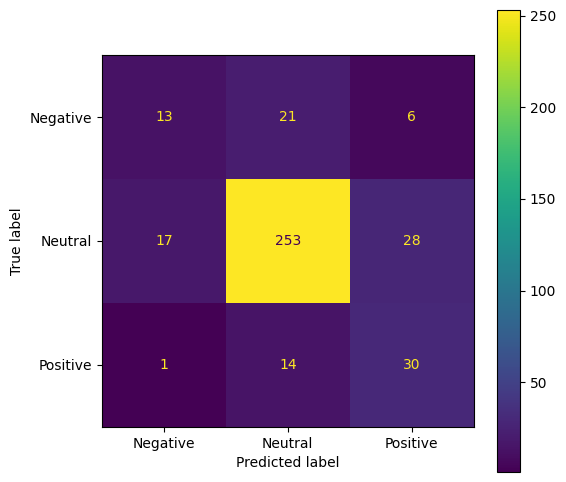

              precision    recall  f1-score   support

    Negative       0.42      0.33      0.37        40
     Neutral       0.88      0.85      0.86       298
    Positive       0.47      0.67      0.55        45

    accuracy                           0.77       383
   macro avg       0.59      0.61      0.59       383
weighted avg       0.78      0.77      0.77       383



In [355]:
model = BertForSequenceClassification.from_pretrained("./grid_results/best/checkpoint-570", num_labels=3)
trainer = Trainer(
    model=model,
)

# Get predictions
predictions = trainer.predict(tokenized_dataset["test"])
predicted_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

# Create and display confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Neutral', 'Positive'])
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax)
plt.show()

# Print classification report
print(classification_report(true_labels, predicted_labels, target_names=['Negative', 'Neutral', 'Positive']))

C:\Users\szymo\AppData\Local\Temp\ipykernel_424\2806912349.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(overall_metrics.keys()),
C:\Users\szymo\AppData\Local\Temp\ipykernel_424\2806912349.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_f1.keys()),


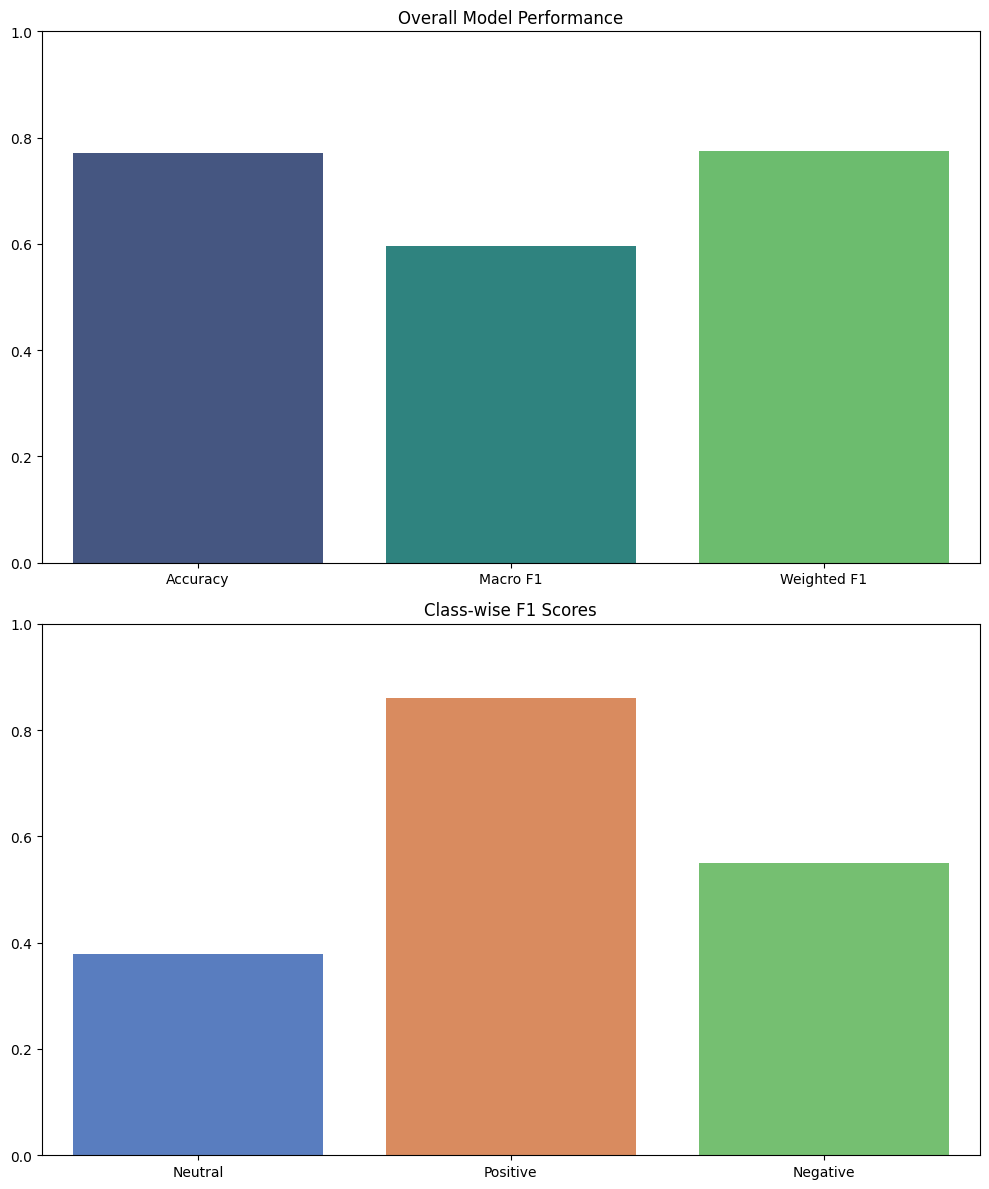

In [350]:
def plot_training_results(results):
  
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
    
   
    overall_metrics = {
        'Accuracy': results['accuracy'],
        'Macro F1': results['macro_f1'],
        'Weighted F1': results['weighted_f1']
    }
    
    sns.barplot(x=list(overall_metrics.keys()), 
                y=list(overall_metrics.values()),
                ax=ax1,
                palette='viridis')
    ax1.set_title('Overall Model Performance')
    ax1.set_ylim(0, 1)
    
    class_f1 = {
        'Neutral': results['neutral_f1'],
        'Positive': results['positive_f1'],
        'Negative': results['negative_f1']
    }
    
    sns.barplot(x=list(class_f1.keys()), 
                y=list(class_f1.values()),
                ax=ax2,
                palette='muted')
    ax2.set_title('Class-wise F1 Scores')
    ax2.set_ylim(0, 1)
    
    plt.tight_layout()
    plt.show()

plot_training_results(result)